In [1]:
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import activations
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Conv2D,BatchNormalization,Lambda,Activation,Input,Flatten,Conv2DTranspose,concatenate,Reshape,LeakyReLU

# Set some options and read data based on selected ones

In [2]:
#constants
IMG_DIM = 28
# manual options
sensitive = 'class' # 'color' or 'class'
prior_dist = 0 # 0: simple gaussian 1: guassian mixture Note: if prior generator model enabled, this option is not used
mnist_type = 'unbalanced' # 'balanced' 'unbalanced
supervised = True #False:Unsupervised (use input data as utility)
data_path = "./Colored_MNIST"

# automatically set variables based on selected options
utility = 'class' if sensitive=='color' else 'color'
prior_type = 'Isotropic' if prior_dist == 0 else 'Mixture'
data_type = 'biased' if mnist_type=='unbalanced' else 'uniform'

exp_info = f"s_{sensitive}_u_{utility}_{prior_type}_{data_type}_supervised" if supervised else f"s_{sensitive}_{prior_type}_{data_type}_unsupervised"
exp_info += "_P1"

data = np.load(f"{data_path}/colored_mnist_{mnist_type}.npz")

x_train = data['x_train']
x_train = x_train.astype(np.float32) / 255.0
s_train = data['s_train'] if(sensitive == 'color') else data['y_train']
u_train = data['s_train'] if(sensitive == 'class') else data['y_train']
if not supervised: u_train = x_train


x_test = data['x_test']
x_test = x_test.astype(np.float32) / 255.0
s_test = data['s_test'] if(sensitive == 'color') else data['y_test']
u_test = data['s_test'] if(sensitive == 'class') else data['y_test']
if not supervised: u_test = x_test


exp_info

's_class_u_color_Isotropic_biased_supervised_P1'

# one hot S and U (if supervised) in order to ready them for the model

In [3]:
def one_hot(labels, num_labels):
    num_labels_data = labels.shape[0]
    one_hot_encoding = np.zeros((num_labels_data,num_labels))
    one_hot_encoding[np.arange(num_labels_data),labels] = 1
    one_hot_encoding = np.reshape(one_hot_encoding, [-1, num_labels])
    return one_hot_encoding

DIM_S = 3 if(sensitive == 'color') else 10
if supervised:
    DIM_U = 10 if(sensitive == 'color') else 3
else:
    DIM_U = x_train[0].shape

if supervised: u_train = one_hot(u_train, DIM_U).astype(np.float32)
s_train = one_hot(s_train, DIM_S).astype(np.float32)
if supervised: u_test = one_hot(u_test, DIM_U).astype(np.float32)
s_test = one_hot(s_test, DIM_S).astype(np.float32)

# Define model

In [4]:
class sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return tf.math.add(z_mean, tf.exp(0.5 * z_log_var) * epsilon, name="sample")

In [5]:
def get_encoder(DIM_Z, input_x):
    stride = 2
#     input_x = Input( shape = [IMG_DIM,IMG_DIM,3], name="x" )

    #first hidden layer
    x = Conv2D(64, 5, strides=stride, padding="same", name="enc_h1")(input_x)
    x = BatchNormalization(name="enc_h1_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h1_activation")(x)
    #second hidden layer
    x = Conv2D(128, 5, strides=stride, padding="same", name="enc_h2")(x)
    x = BatchNormalization(name="enc_h2_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h2_activation")(x)

    shape = K.int_shape(x)
    x = Flatten()(x)
    x = Dense(DIM_Z*4, name="enc_dense_1")(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    z_mean = Dense(DIM_Z, name="z_mean")(x)
    z_log_sigma_sq = Dense(DIM_Z, name="z_sigma")(x)
#     z = Lambda(sampling, output_shape=DIM_Z, name='sample_z')([z_mean, z_log_sigma_sq])
    z = sampling(name="sample_z")([z_mean, z_log_sigma_sq])
#     prior_loss = K.mean(-0.5 * K.sum(1 + z_log_sigma_sq - K.square(z_mean) - K.exp(z_log_sigma_sq), axis=-1))
    
    encoder = Model(input_x, z, name = "Encoder")
#     encoder.add_loss((alpha+beta) * prior_loss)
    
    return (encoder, z_mean, z_log_sigma_sq)

In [6]:
def get_decoder(DIM_Z):
    stride = 2
    input_z = Input(shape = (DIM_Z,), name="z_encoder")
    input_s = Input( shape = (DIM_S,), name="s_input")
    z_with_s = concatenate([input_z, input_s], name="concat_layer")
    x = Dense(7*7*128, name="dec_dense_1")(z_with_s)
    x = BatchNormalization(name="dec_dense_1_normalized")(x)
    x = Activation(LeakyReLU(), name="dec_dense_1_activation")(x)

    #Unflatten
    x = Reshape((7,7,128), name="unflatten1")(x)
    x = BatchNormalization(name="unflatten1_normalized")(x)
    x = Activation(LeakyReLU(), name="unflatten1_activation")(x)

    x = Conv2DTranspose(64, 5, strides=stride, padding = "same", name="dec_h1")(x)
    x = BatchNormalization(name="dec_h1_normalized")(x)
    x = Activation(LeakyReLU(), name="dec_h1_activation")(x)

    x = Conv2DTranspose(3, 5, strides=stride, padding = "same", name="dec_h2")(x)
    x_hat = Activation('sigmoid', name="x_hat")(x)

    decoder = Model([input_z, input_s], x_hat, name = "Uncertainty_Decoder")
    return decoder

In [7]:
if supervised:
    def get_utility_model(DIM_Z):
        model = Sequential(name="Utility_Decoder_supervised")
        model.add(Dense(DIM_Z * 4, input_dim=DIM_Z))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(DIM_U, activation='softmax', name="u_hat"))
        return model
else:
    def get_utility_model(DIM_Z):
        stride = 2
        model = Sequential(name="Utility_Decoder_unsupervised")
        model.add(Dense(7*7*128, input_dim=DIM_Z))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Reshape((7,7,128)))
        
        model.add(Conv2DTranspose(64, 5, strides=stride, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, 5, strides=stride, activation='sigmoid',padding="same", name="u_hat"))
        return model

In [8]:
def get_z_discriminator(DIM_Z):
    model = Sequential(name="Latent_Space_Discriminator")
    
    model.add(Dense(512, input_dim=DIM_Z))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [9]:
def get_utility_discriminator():
    stride = 2
    model = Sequential(name="Attribute_Class_Discriminator")

    model.add(Dense(DIM_U * 4, input_dim=DIM_U))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(DIM_U * 4))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [10]:
def get_visible_space_discriminator():
    stride = 2
    model = Sequential(name="Visible_Space_Discriminator")
    
    model.add(Input(shape = [IMG_DIM,IMG_DIM,3]))
    
    model.add(Conv2D(32, 3, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(64, 3, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, 3, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [11]:
def get_prior_generator(DIM_Z, noise_dim=50):
    model = Sequential(name="Prior_Distribution_Generator")
    
    model.add(Dense(noise_dim, input_dim=noise_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(noise_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(DIM_Z, name="z_prior_generator"))
    
    return model

## Build and train a model for evaluating S performance
The following two block cells are **not** part of the framework, it's an evaluator for sensitivity which is required for the experiments

In [12]:
def get_s_eval_model():
    stride = 2
    model = Sequential(name="CNN_Model_sensitivity_evaluator")
    model.add(Input(shape = [IMG_DIM,IMG_DIM,3]))

    model.add(Conv2D(64, 5, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation(LeakyReLU(alpha=0.2)))

    model.add(Conv2D(128, 5, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation(LeakyReLU(alpha=0.2)))

    model.add(Flatten())

    model.add(Dense(512 * DIM_S))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dense(DIM_S, activation="softmax", name='s_hat'))
    
    return model

In [13]:
s_eval_model = get_s_eval_model()
s_eval_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

force_train = False

if not os.path.exists(f"saved_models/mnist_eval_model_s_{sensitive}.h5") or force_train:
    print("Training sensitive attribute evaluator")
    history = s_eval_model.fit(x_train, s_train, batch_size=1024, epochs=100, shuffle=True, verbose=2)
    s_eval_model.save_weights(f"saved_models/mnist_eval_model_s_{sensitive}.h5")
else:
    print("Loading sensitive attribute evaluator from file")
    s_eval_model.load_weights(f"saved_models/mnist_eval_model_s_{sensitive}.h5")

## Evaluating evaluator!
s_hat_test = s_eval_model.predict(x_test)
print(f"Evaluator accuracy = {(sum(np.argmax(s_hat_test,axis=-1)==np.argmax(s_test,axis=-1)) / s_test.shape[0]) * 100}")

Loading sensitive attribute evaluator from file
Evaluator accuracy = 98.87


# Putting all togther - define CLUB model

In [14]:
z_gen_enabled = False
## utility and reconstruction losses
if supervised:
    def loss_u(u_true, u_pred):
        return K.mean(K.sum(K.square(u_true-u_pred), axis=-1))
else:
    def loss_u(u_true, u_pred):
        return K.mean(K.sum(K.square(u_true-u_pred), axis=(1,2,3)))

def loss_x(alpha):
    def loss(inp_x, out_x):
        return alpha * K.mean(K.sum(K.square(inp_x-out_x), axis=(1,2,3)))
    return loss

bce = tf.keras.losses.BinaryCrossentropy()
# Weighted cross-entropy loss
def loss_wce(coef):
    def loss(y, y_pred):
         return coef * bce(y, y_pred)
    return loss

########## Inputs
def get_full_model(DIM_Z, alpha, beta, learning_rate=0.0001, dim_noise = 100):

    input_x = Input( shape=[IMG_DIM,IMG_DIM,3], name="x" )
    input_s = Input( shape = (DIM_S,), name="s" )
    input_z = Input( shape = (DIM_Z,), name="z" )

    input_noise = Input( shape = (dim_noise,), name="Noise")

    ########## Define AE: Encoder, Utility Decoder and Uncertainty Decoder
    encoder,z_mean,z_log_sigma_sq = get_encoder(DIM_Z, input_x)
    uncertainty_decoder = get_decoder(DIM_Z)
    utility_decoder = get_utility_model(DIM_Z)

    z = encoder(input_x)
    x_hat = uncertainty_decoder([z, input_s])
    u_hat = utility_decoder(z)

    autoencoder = Model([input_x, input_s], [x_hat, u_hat], name="CLUB_Autoencoder")
    prior_loss = (alpha+beta) * K.mean(-0.5 * K.sum(1 + z_log_sigma_sq - K.square(z_mean) - K.exp(z_log_sigma_sq), axis=-1))
    prior_loss = tf.identity(prior_loss, name="kl_loss")
    autoencoder.add_loss(prior_loss)
    autoencoder.compile(loss=[loss_x(alpha), loss_u], optimizer=tf.keras.optimizers.Adam(lr=learning_rate*5))

    ########## Define Latent Space Discriminator
    z_discriminator = get_z_discriminator(DIM_Z)
    z_discriminator.compile(loss=loss_wce(0.1*(alpha+beta)), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    #z_discriminator should train separately
    z_discriminator.trainable = False
    prior_generator = get_prior_generator(DIM_Z, dim_noise)
    prior_gen_zdiscriminator = Model(input_noise, z_discriminator(prior_generator(input_noise)), name="CLUB_generator_zdiscriminator")
    prior_gen_zdiscriminator.compile(loss=loss_wce(-0.1*(alpha+beta)), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    encoder_zdiscriminator = Model(input_x, z_discriminator(encoder(input_x)), name="CLUB_encoder_zdiscriminator")
    encoder_zdiscriminator.compile(loss=loss_wce(-0.1*(alpha+beta)), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    u_dircriminator = get_utility_discriminator() if supervised else get_visible_space_discriminator()
    u_dircriminator.compile(loss=loss_wce(0.1), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

    ##########
    #u_dircriminator should train separately
    u_dircriminator.trainable = False

    if z_gen_enabled:    
        decoder_udiscriminator = Model(input_noise, u_dircriminator(utility_decoder(prior_generator(input_noise))), name="CLUB_decoder_discriminator")
    else:
        decoder_udiscriminator = Model(input_z, u_dircriminator(utility_decoder(input_z)), name="CLUB_decoder_discriminator")

    decoder_udiscriminator.compile(loss=loss_wce(-0.1), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))
    
    return encoder, uncertainty_decoder, utility_decoder,autoencoder,z_discriminator,prior_generator,prior_gen_zdiscriminator,encoder_zdiscriminator,u_dircriminator,decoder_udiscriminator

In [15]:
# for test
# encoder, uncertainty_decoder, utility_decoder,autoencoder,z_discriminator,prior_generator,prior_gen_zdiscriminator,encoder_zdiscriminator,u_dircriminator,decoder_udiscriminator= get_full_model(32,0.1,0.1)
# tf.keras.utils.plot_model(decoder_udiscriminator, expand_nested=True, show_shapes=True)
# tf.keras.utils.plot_model(autoencoder, show_shapes=True)

# Pre-training implementation

In [16]:
def pre_train_ae(dim_z, alpha, beta, force_train=False, max_itr=50, batch_size=1024, verbose=2):
    info_str = f"d_{dim_z}_beta_{beta}_alpha_{alpha}_{exp_info}"
    if not os.path.exists(f"saved_models/mnist_pretrain_{info_str}.h5") or force_train:
        print(f"Pre-Training with {info_str}")
        autoencoder.fit([x_train, s_train], [x_train, u_train], batch_size=batch_size, epochs=max_itr, shuffle=True, verbose=verbose)
        autoencoder.save_weights(f"saved_models/mnist_pretrain_{info_str}.h5")
    else:
        print(f"Loading model from file with {info_str}")
        autoencoder.load_weights(f"saved_models/mnist_pretrain_{info_str}.h5")

# Full model training loop 

## set prior distribution function based on user config (The following cell will be ignored if the prior-generator network enabled)

In [17]:
from utils.sampler import gaussian, gaussian_mixture

def sample_prior(latent_dim, batch_size):
    if prior_dist == 0:
        return gaussian(batch_size, latent_dim)
    elif prior_dist == 1:
        return gaussian_mixture(batch_size, latent_dim, num_labels=min(10, DIM_U))

## customized training loop for block-wised algorithm

In [18]:
def main_train(dim_z, max_itr=2000, batch_size=1024, z_disc_enabled=True,u_disc_enabled=True,verbose=0, dim_noise=100):
    ones = np.ones((batch_size, 1))
    zeros = np.zeros((batch_size, 1))
    start_time = time.time()
    for epoch in range(max_itr):
        start_time_epoch = time.time()
        # Select a random batch of images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        x = x_train[idx]
        s = s_train[idx]
        u = u_train[idx]

        # ---------------------
        #  1- Train the Encoder, Utility Decoder, Uncertainty Decoder
        # ---------------------
        ae_loss = autoencoder.train_on_batch([x, s], [x, u])

        if z_disc_enabled:
        # ---------------------
        #  2- Train the Latent Space Discriminator
        # ---------------------

            if z_gen_enabled:
                noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
                latent_prior = prior_generator(noise)
            else:
                latent_prior = sample_prior(dim_z, batch_size)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            x = x_train[idx]
            latent_enc = encoder(x)

            d_loss_prior = z_discriminator.train_on_batch(latent_prior, zeros)
            d_loss_enc = z_discriminator.train_on_batch(latent_enc, ones)
            dz_loss = np.add(d_loss_prior, d_loss_enc)

            # ---------------------
            # 3- Train the Encoder and Prior Distribution Generator Adversarially
            # ---------------------
            
            if z_gen_enabled:
                noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
                prior_loss = prior_gen_zdiscriminator.train_on_batch(noise, zeros)
            else:
                prior_loss = 0.

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            x = x_train[idx]
            edz_loss = encoder_zdiscriminator.train_on_batch(x, ones)
        else:
            dz_loss = 0.
            prior_loss = 0.
            edz_loss = 0.

        if u_disc_enabled:
        # ---------------------
        #  4- Train Visible_Space/Attribute_Class Discriminator 
        # ---------------------

            if z_gen_enabled:
                noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
                latent = prior_generator(noise)
            else:
                latent = sample_prior(dim_z, batch_size)
            u_dec = utility_decoder(latent)

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            u = u_train[idx]

            d_loss_real = u_dircriminator.train_on_batch(u, ones)
            d_loss_fake = u_dircriminator.train_on_batch(u_dec, zeros)
            du_loss = np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  5- Train the Prior Distribution Generator and Utility Decoder Adversarially
        # ---------------------
            if z_gen_enabled:
                noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
                gdu_loss = decoder_udiscriminator.train_on_batch(noise, zeros)
            else:    
                latent = sample_prior(dimz, batch_size)
                gdu_loss = decoder_udiscriminator.train_on_batch(latent, zeros)
        else:
            gdu_loss = 0
            du_loss = 0

        # ---------------------
        #  Print stats info
        # ---------------------
        if verbose != 0 and epoch % 20 == 0:
            print(f"{epoch}, mse:{ae_loss[1]:.4f}, u:{ae_loss[2]:.4f}, dz:{dz_loss:.4f}, edz:{edz_loss:.4f}, prior:{prior_loss:.4f}, du:{du_loss:.4f}, gdu:{gdu_loss:.4f}")
            print(f"One epoch execution time: {(time.time() - start_time_epoch):.5f} seconds")

    total_time = (time.time() - start_time) / 60
    print(f"Total Execution Time: {total_time:.4f} minutes")

## The following function used for showing the uncertainty-decoder outputs (reconsterction) with different S values on the list of test data

In [19]:
from utils.pics_tools import plot_image_grid
def save_figures(model, dim_z, alpha, beta):
    info_str = f"d_{dim_z}_beta_{beta}_alpha_{alpha}_{exp_info}"
    n_plot_samps = 10
    ind_list = [3, 2, 1, 18, 4 ,15, 11, 0, 128, 9]
    if sensitive == 'color':    
        x_hat_no_color, *_ = model.predict([x_test[ind_list], np.zeros((n_plot_samps,DIM_S)) ])
        x_hat_all_color, *_ = model.predict([x_test[ind_list], np.ones((n_plot_samps,DIM_S)) ])
        s0 = np.zeros((n_plot_samps,3))
        s0[:, 0] = 1
        s1 = np.zeros((n_plot_samps,3))
        s1[:, 1] = 1
        s2 = np.zeros((n_plot_samps,3))
        s2[:, 2] = 1
        x_hat_0, *_ = model.predict([x_test[ind_list], s0 ])
        x_hat_1, *_ = model.predict([x_test[ind_list], s1 ])
        x_hat_2, *_ = model.predict([x_test[ind_list], s2 ])

        fig = plot_image_grid(np.concatenate([x_test[ind_list], x_hat_no_color, x_hat_all_color, x_hat_0, x_hat_1, x_hat_2], axis=0),
          [IMG_DIM, IMG_DIM, 3], (6,n_plot_samps))
        fig.set_size_inches(16.2, 10)

    else:
        x_hat_no_color, *_ = model.predict([x_test[ind_list], np.zeros((n_plot_samps,DIM_S)) ])
        x_inp = x_test[ind_list]

        for i in range(DIM_S):
            s = np.zeros((n_plot_samps,DIM_S))
            s[:, i] = 1
            x_hat, *_ = model.predict([x_test[ind_list], s ])
            x_inp = np.concatenate([x_inp, x_hat], axis=0)

        fig = plot_image_grid( x_inp, [IMG_DIM, IMG_DIM, 3], (11, n_plot_samps))
        fig.set_size_inches(10.6, 12)

    plt.subplots_adjust(wspace=0, hspace=0)    
    plt.savefig(f'./saved_figures_mnist/colored_mnist_{info_str}.eps', format='eps')
    plt.savefig(f'./saved_figures_mnist/colored_mnist_{info_str}.png', format='png')
    plt.show()

# Experiment 1

Pre-Training with d_8_beta_0.0001_alpha_0.005_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:0.0847, u:0.0004, dz:0.0008, edz:-0.0004, prior:0.0000, du:0.1692, gdu:-0.0688
One epoch execution time: 5.46154 seconds
20, mse:0.0847, u:0.0001, dz:0.0007, edz:-0.0004, prior:0.0000, du:0.1655, gdu:-0.0685
One epoch execution time: 0.28099 seconds
40, mse:0.0840, u:0.0001, dz:0.0007, edz:-0.0004, prior:0.0000, du:0.1604, gdu:-0.0680
One epoch execution time: 0.20242 seconds
60, mse:0.0840, u:0.0001, dz:0.0007, edz:-0.0004, prior:0.0000, du:0.1571, gdu:-0.0686
One epoch execution time: 0.35989 seconds
80, mse:0.0861, u:0.0019, dz:0.0007, edz:-0.0004, prior:0.0000, du:0.1552, gdu:-0.0683
One epoch execution time: 0.20528 seconds
Total Execution Time: 0.4902 minutes
Evaluate performance U


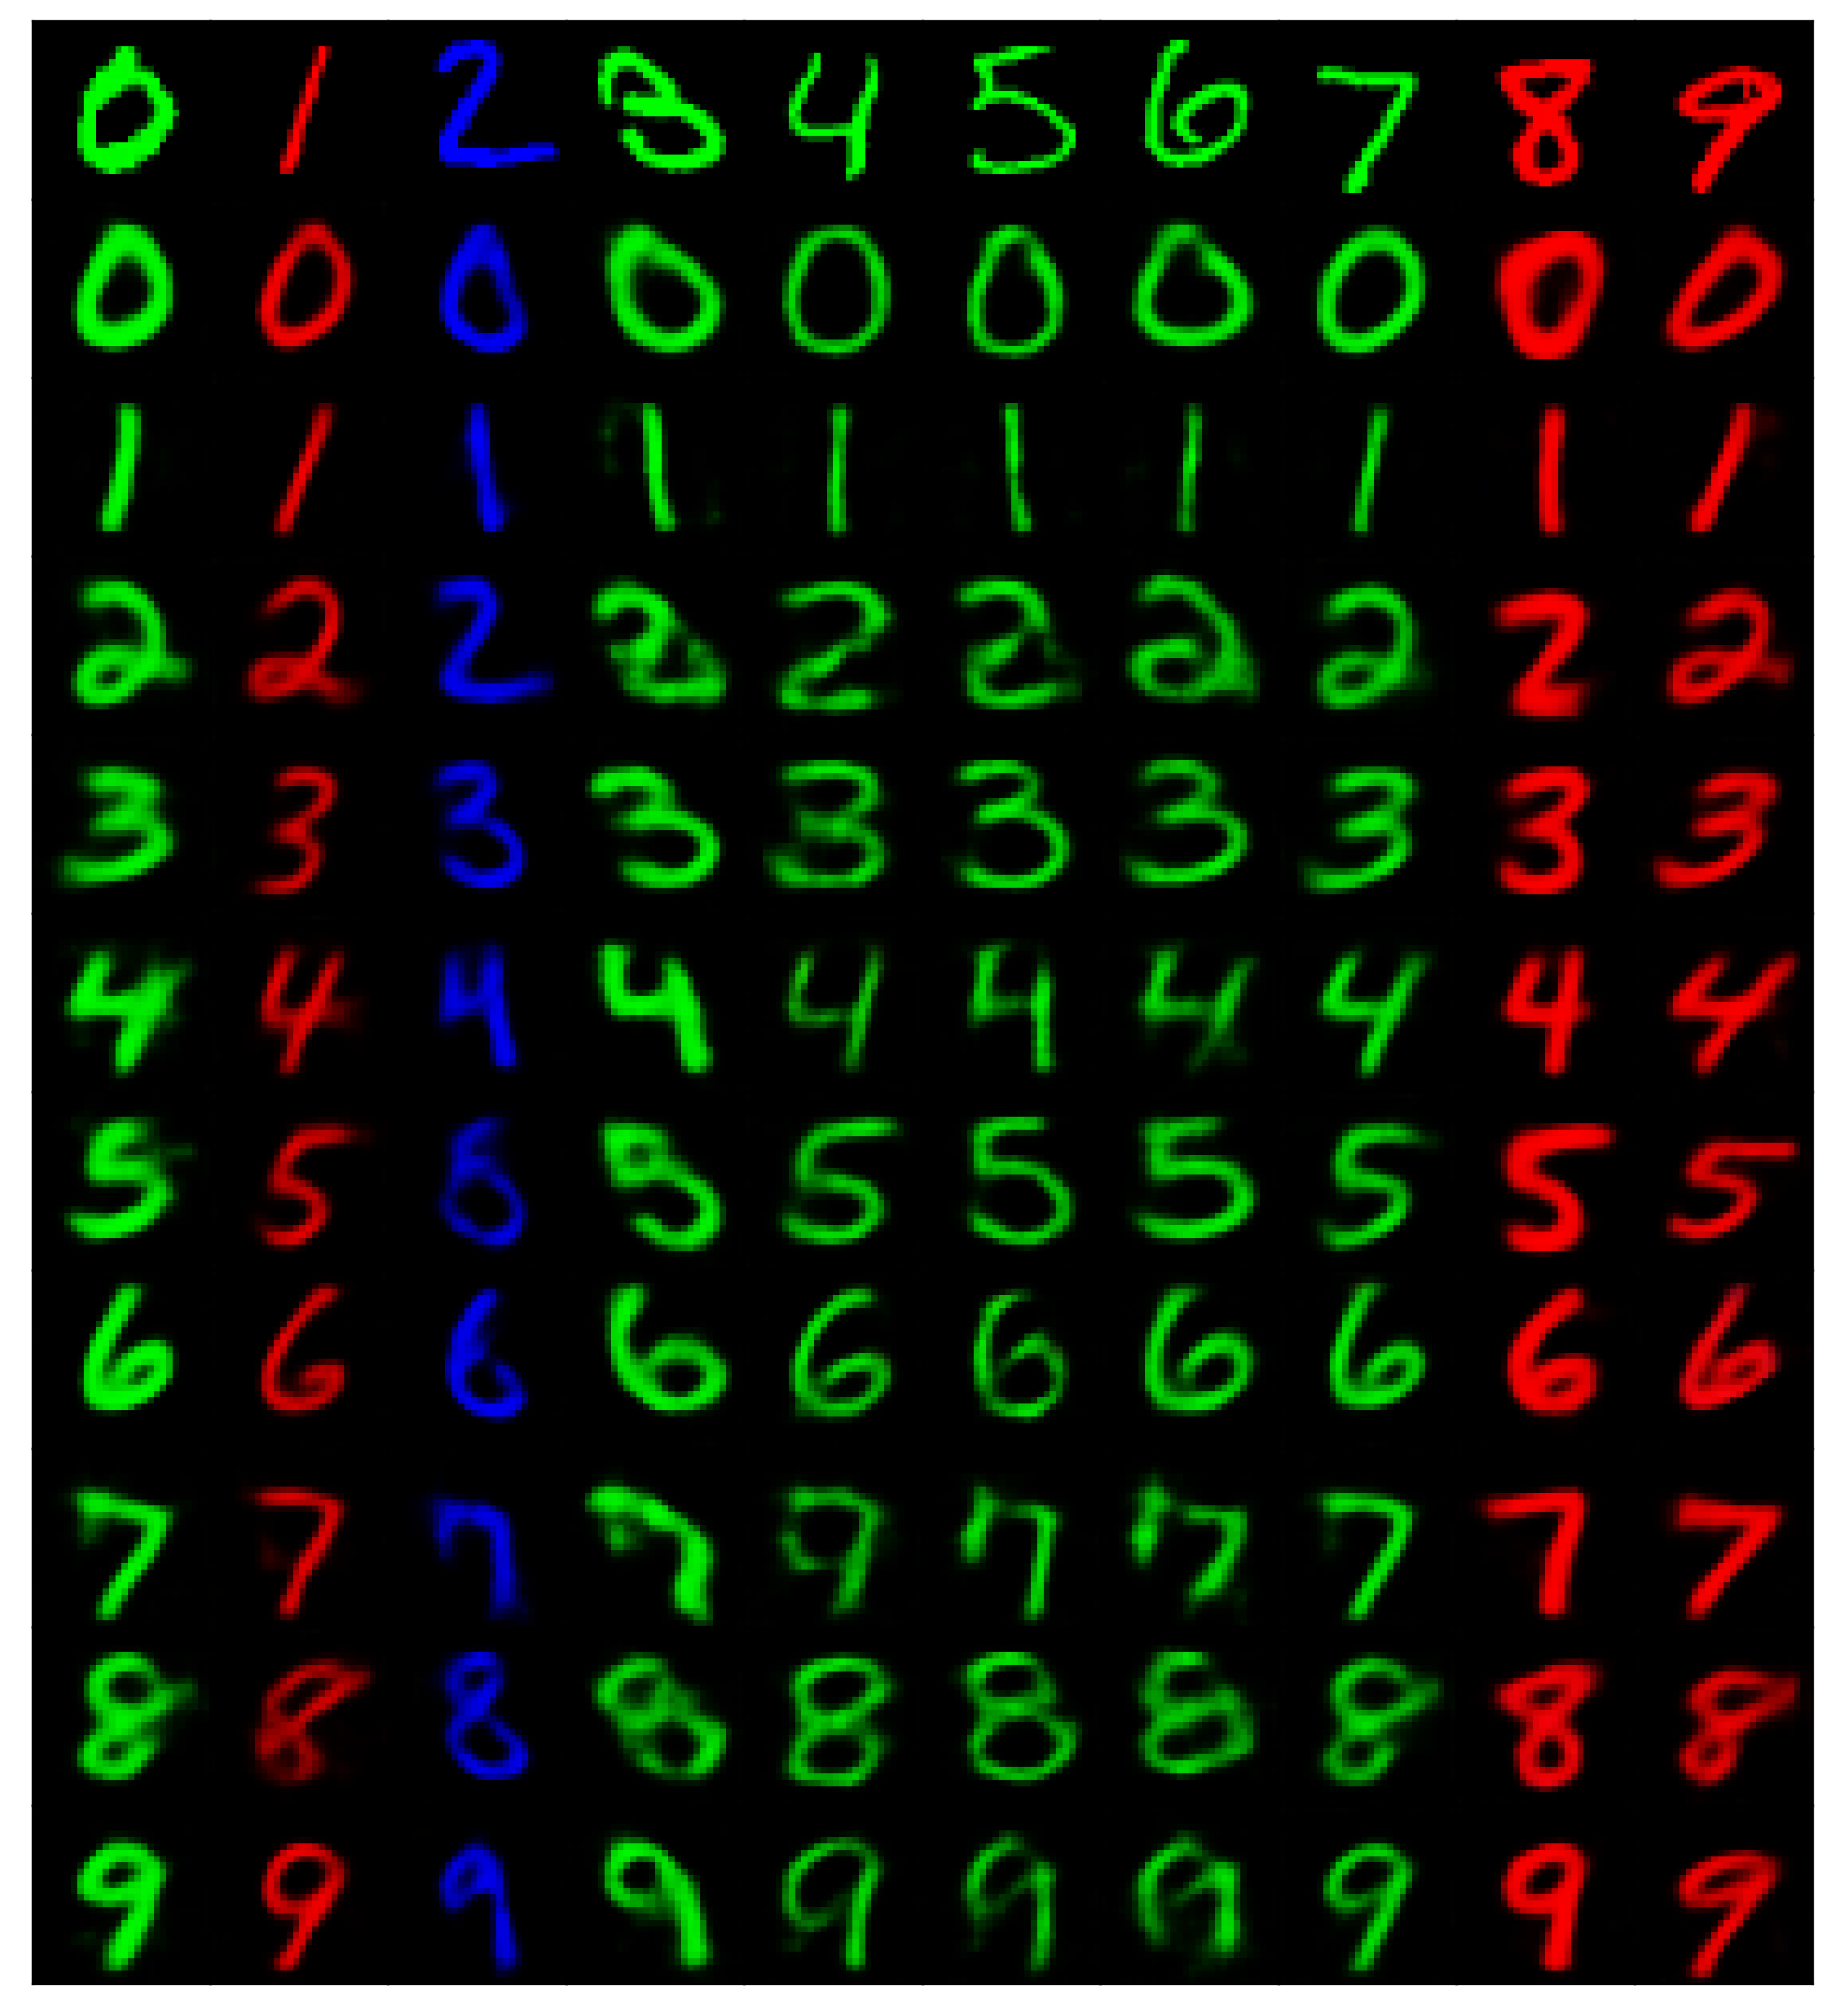

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.1_alpha_0.005_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:0.2104, u:0.0157, dz:0.0165, edz:-0.0075, prior:0.0000, du:0.1529, gdu:-0.0694
One epoch execution time: 5.94217 seconds
20, mse:0.2074, u:0.0204, dz:0.0147, edz:-0.0075, prior:0.0000, du:0.1468, gdu:-0.0716
One epoch execution time: 0.19349 seconds
40, mse:0.2107, u:0.0205, dz:0.0146, edz:-0.0077, prior:0.0000, du:0.1446, gdu:-0.0741
One epoch execution time: 0.19124 seconds
60, mse:0.2110, u:0.0210, dz:0.0146, edz:-0.0079, prior:0.0000, du:0.1428, gdu:-0.0758
One epoch execution time: 0.20587 seconds
80, mse:0.2118, u:0.0167, dz:0.0145, edz:-0.0079, prior:0.0000, du:0.1433, gdu:-0.0788
One epoch execution time: 0.19539 seconds
Total Execution Time: 0.4211 minutes
Evaluate performance U


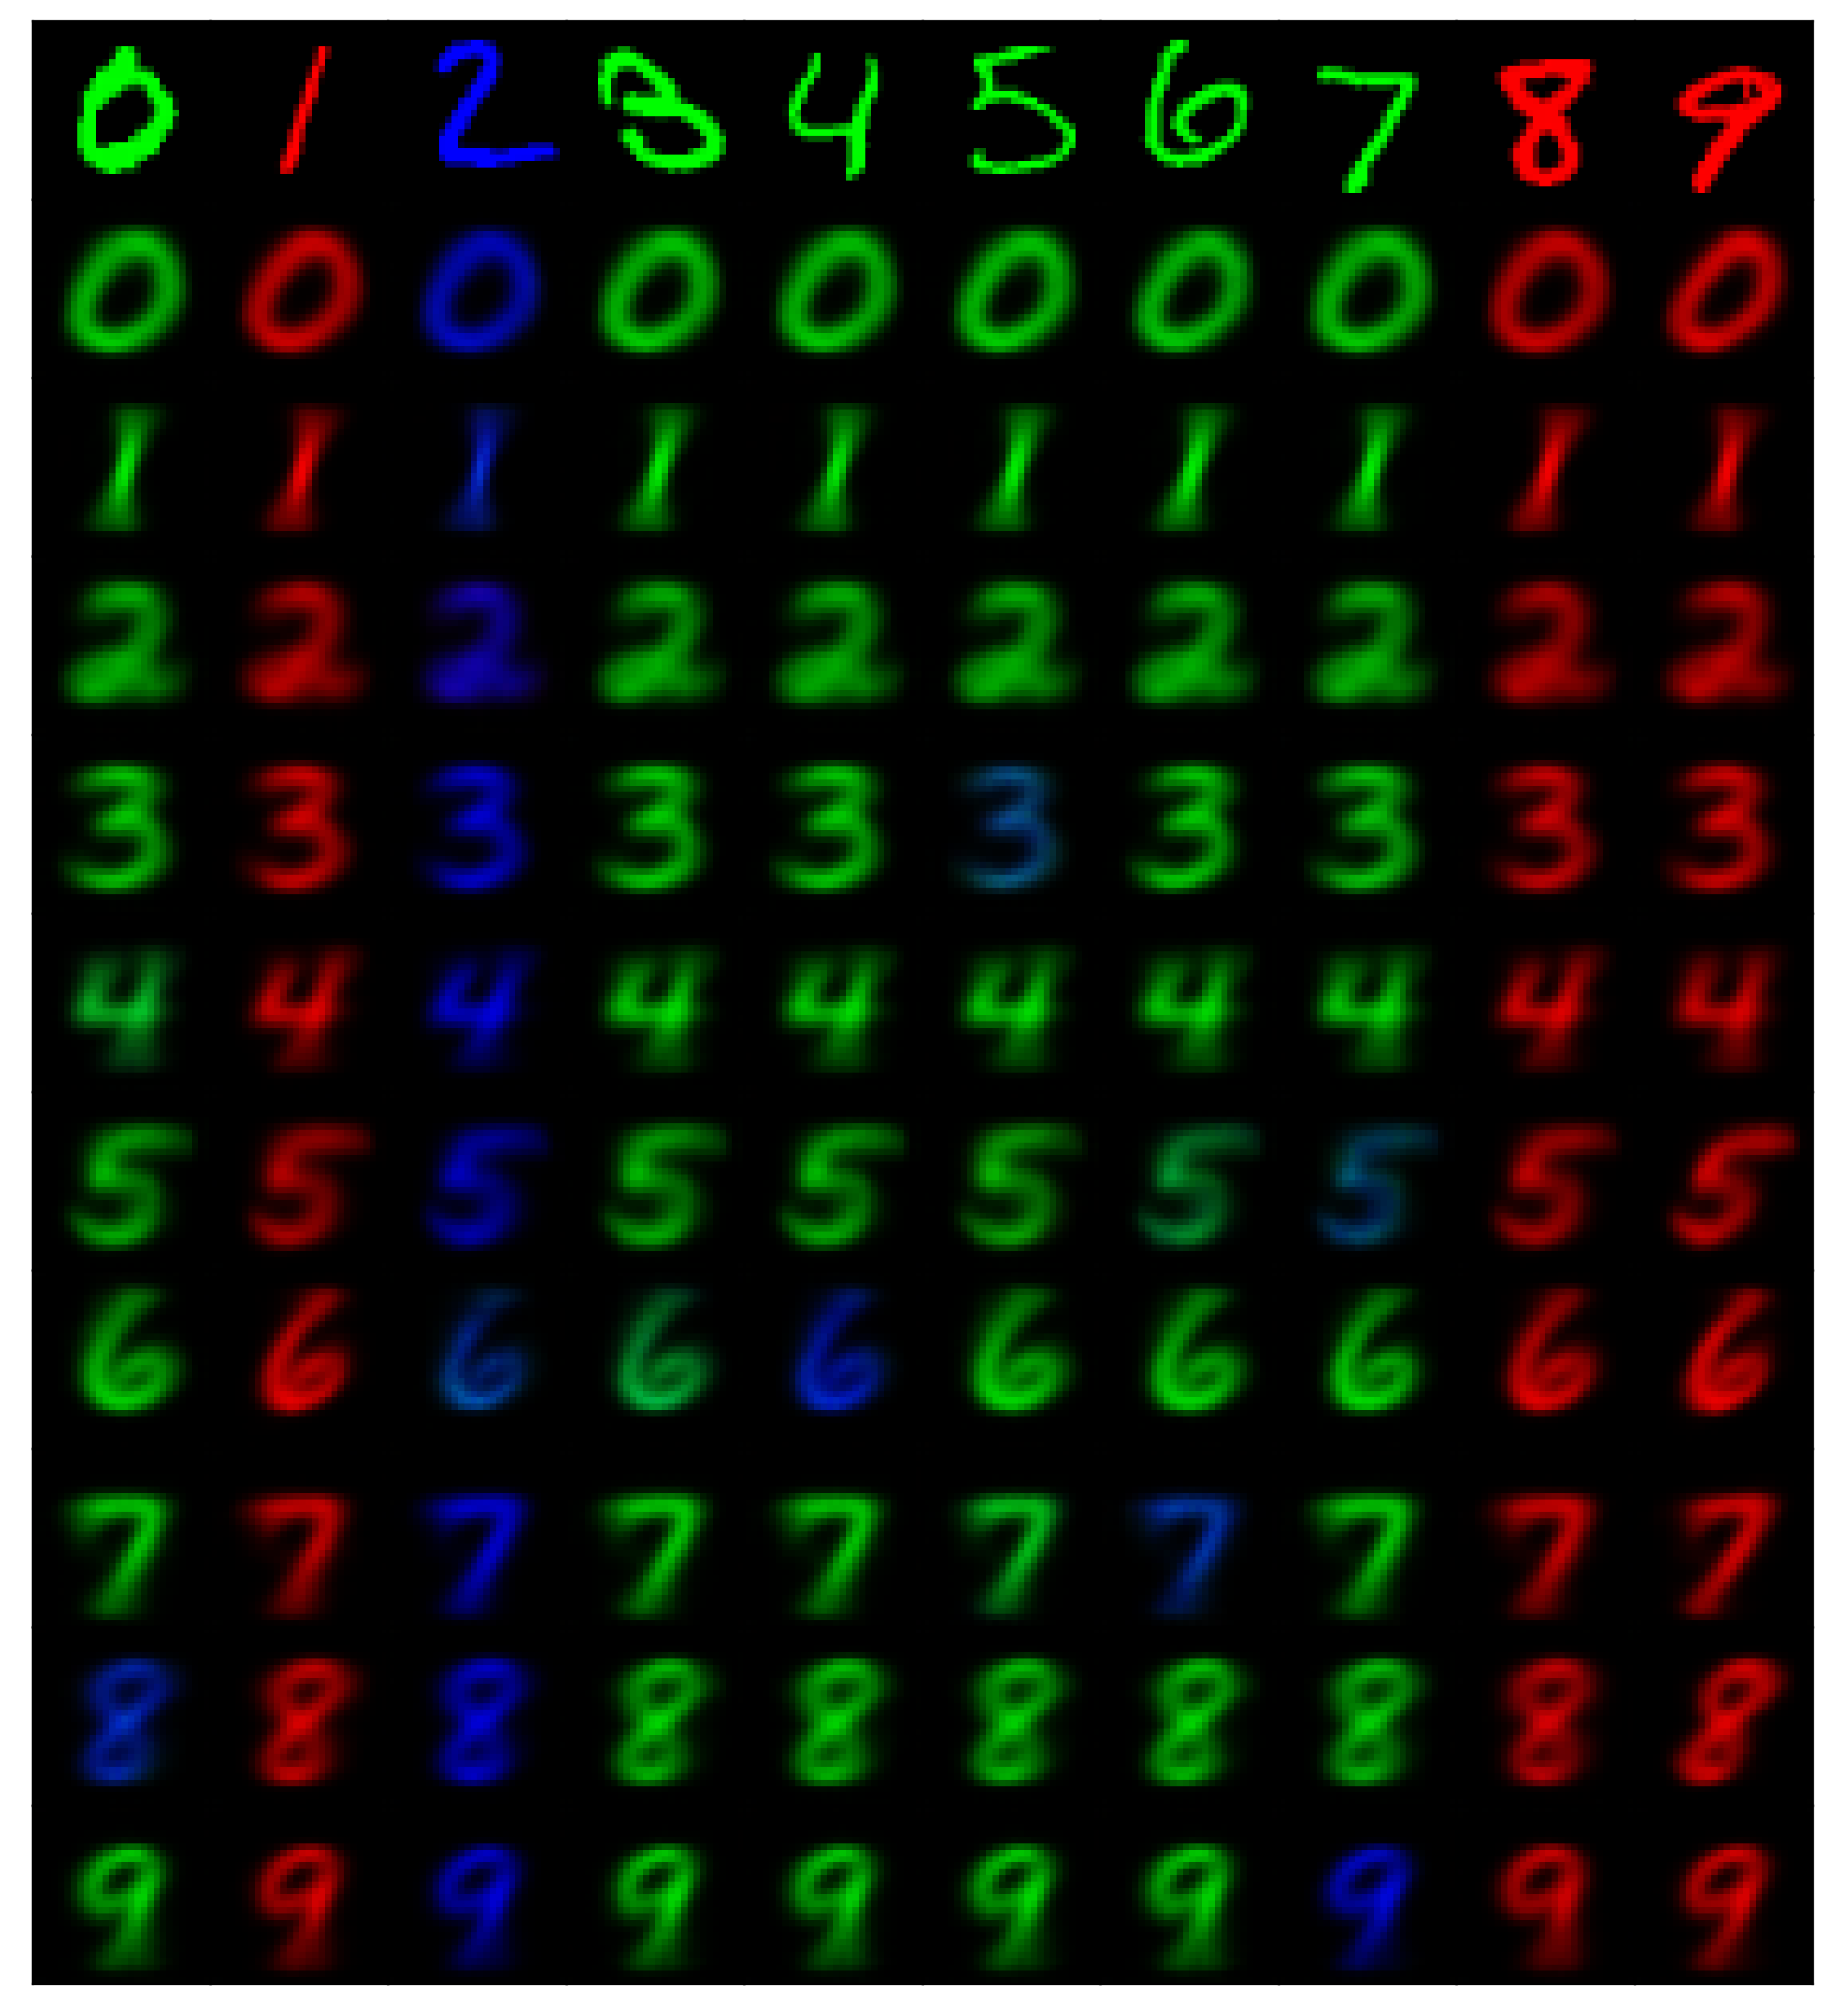

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.3_alpha_0.005_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:0.2250, u:0.0714, dz:0.0512, edz:-0.0178, prior:0.0000, du:0.1678, gdu:-0.0726
One epoch execution time: 4.11711 seconds
20, mse:0.2239, u:0.0657, dz:0.0458, edz:-0.0213, prior:0.0000, du:0.1657, gdu:-0.0758
One epoch execution time: 0.19230 seconds
40, mse:0.2278, u:0.0750, dz:0.0451, edz:-0.0189, prior:0.0000, du:0.1607, gdu:-0.0804
One epoch execution time: 0.20850 seconds
60, mse:0.2252, u:0.0622, dz:0.0444, edz:-0.0178, prior:0.0000, du:0.1574, gdu:-0.0846
One epoch execution time: 0.20019 seconds
80, mse:0.2228, u:0.0718, dz:0.0439, edz:-0.0170, prior:0.0000, du:0.1548, gdu:-0.0865
One epoch execution time: 0.20752 seconds
Total Execution Time: 0.4123 minutes
Evaluate performance U


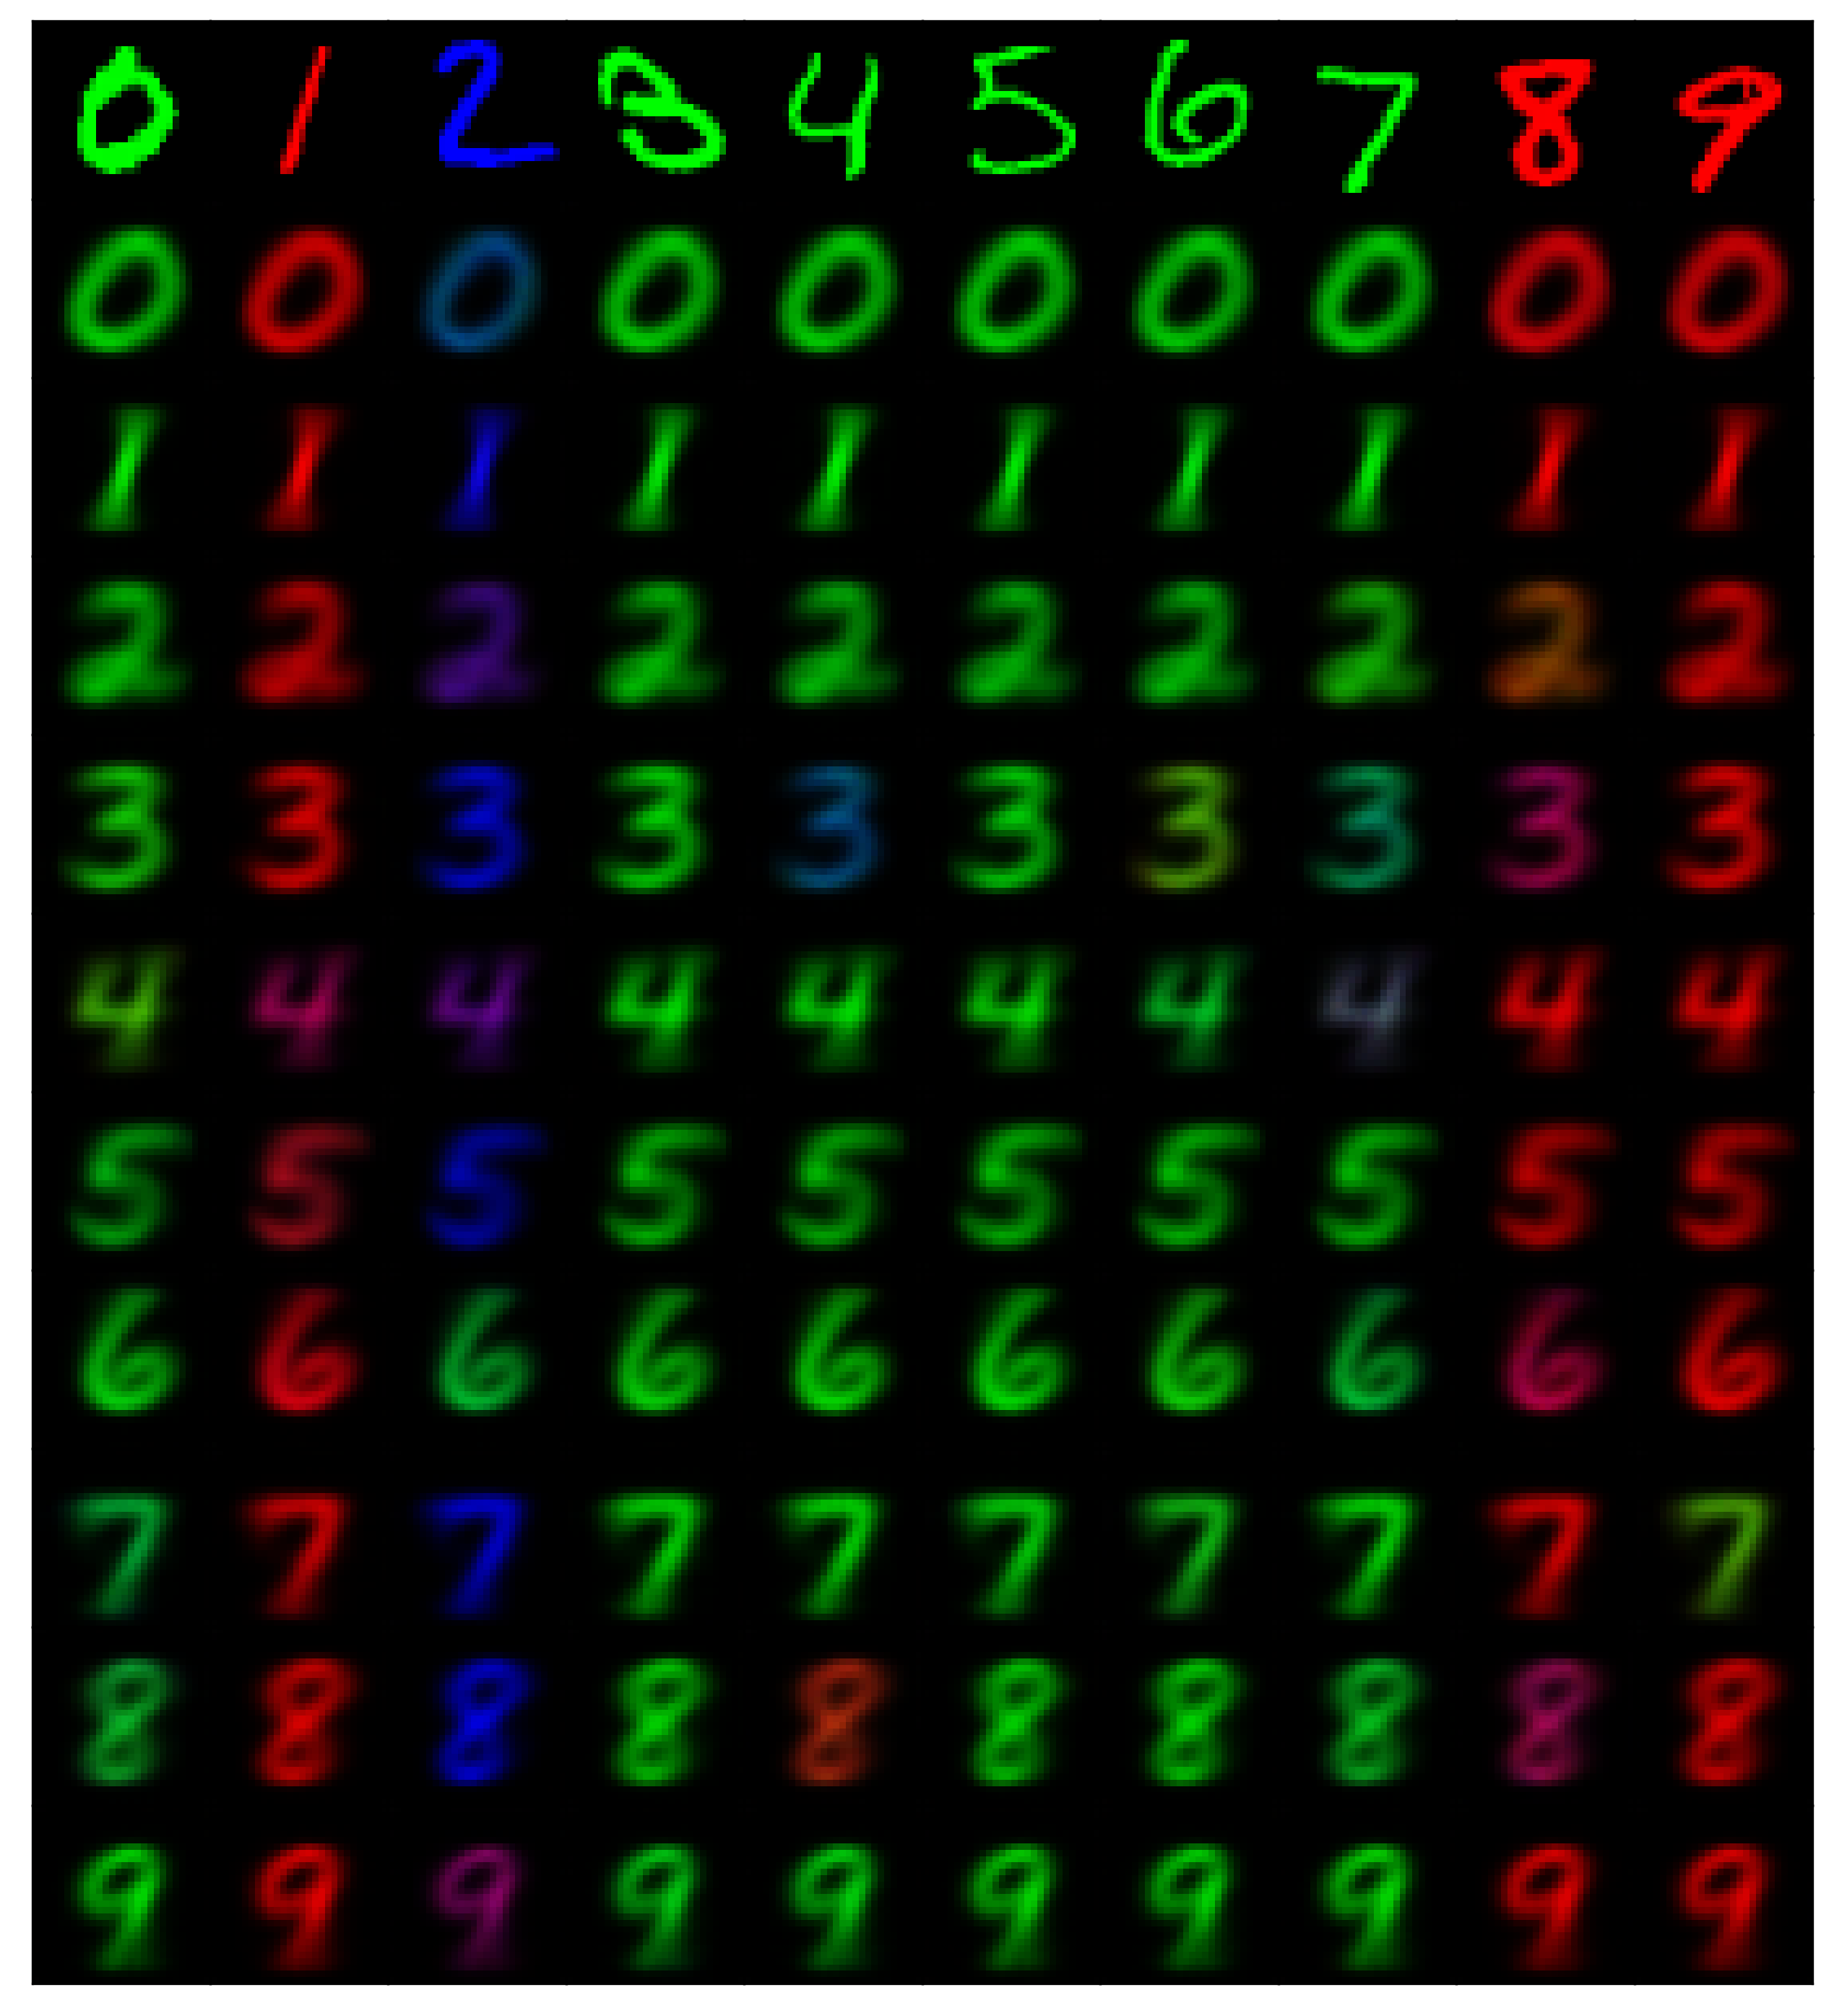

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.5_alpha_0.005_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:0.2474, u:0.1713, dz:0.0757, edz:-0.0359, prior:0.0000, du:0.1600, gdu:-0.0795
One epoch execution time: 4.70206 seconds
20, mse:0.2563, u:0.2141, dz:0.0716, edz:-0.0367, prior:0.0000, du:0.1554, gdu:-0.0764
One epoch execution time: 0.20448 seconds
40, mse:0.2486, u:0.1703, dz:0.0711, edz:-0.0382, prior:0.0000, du:0.1506, gdu:-0.0762
One epoch execution time: 0.19667 seconds
60, mse:0.2545, u:0.1876, dz:0.0707, edz:-0.0390, prior:0.0000, du:0.1481, gdu:-0.0761
One epoch execution time: 0.19197 seconds
80, mse:0.2478, u:0.1790, dz:0.0705, edz:-0.0390, prior:0.0000, du:0.1458, gdu:-0.0752
One epoch execution time: 0.19815 seconds
Total Execution Time: 0.4059 minutes
Evaluate performance U


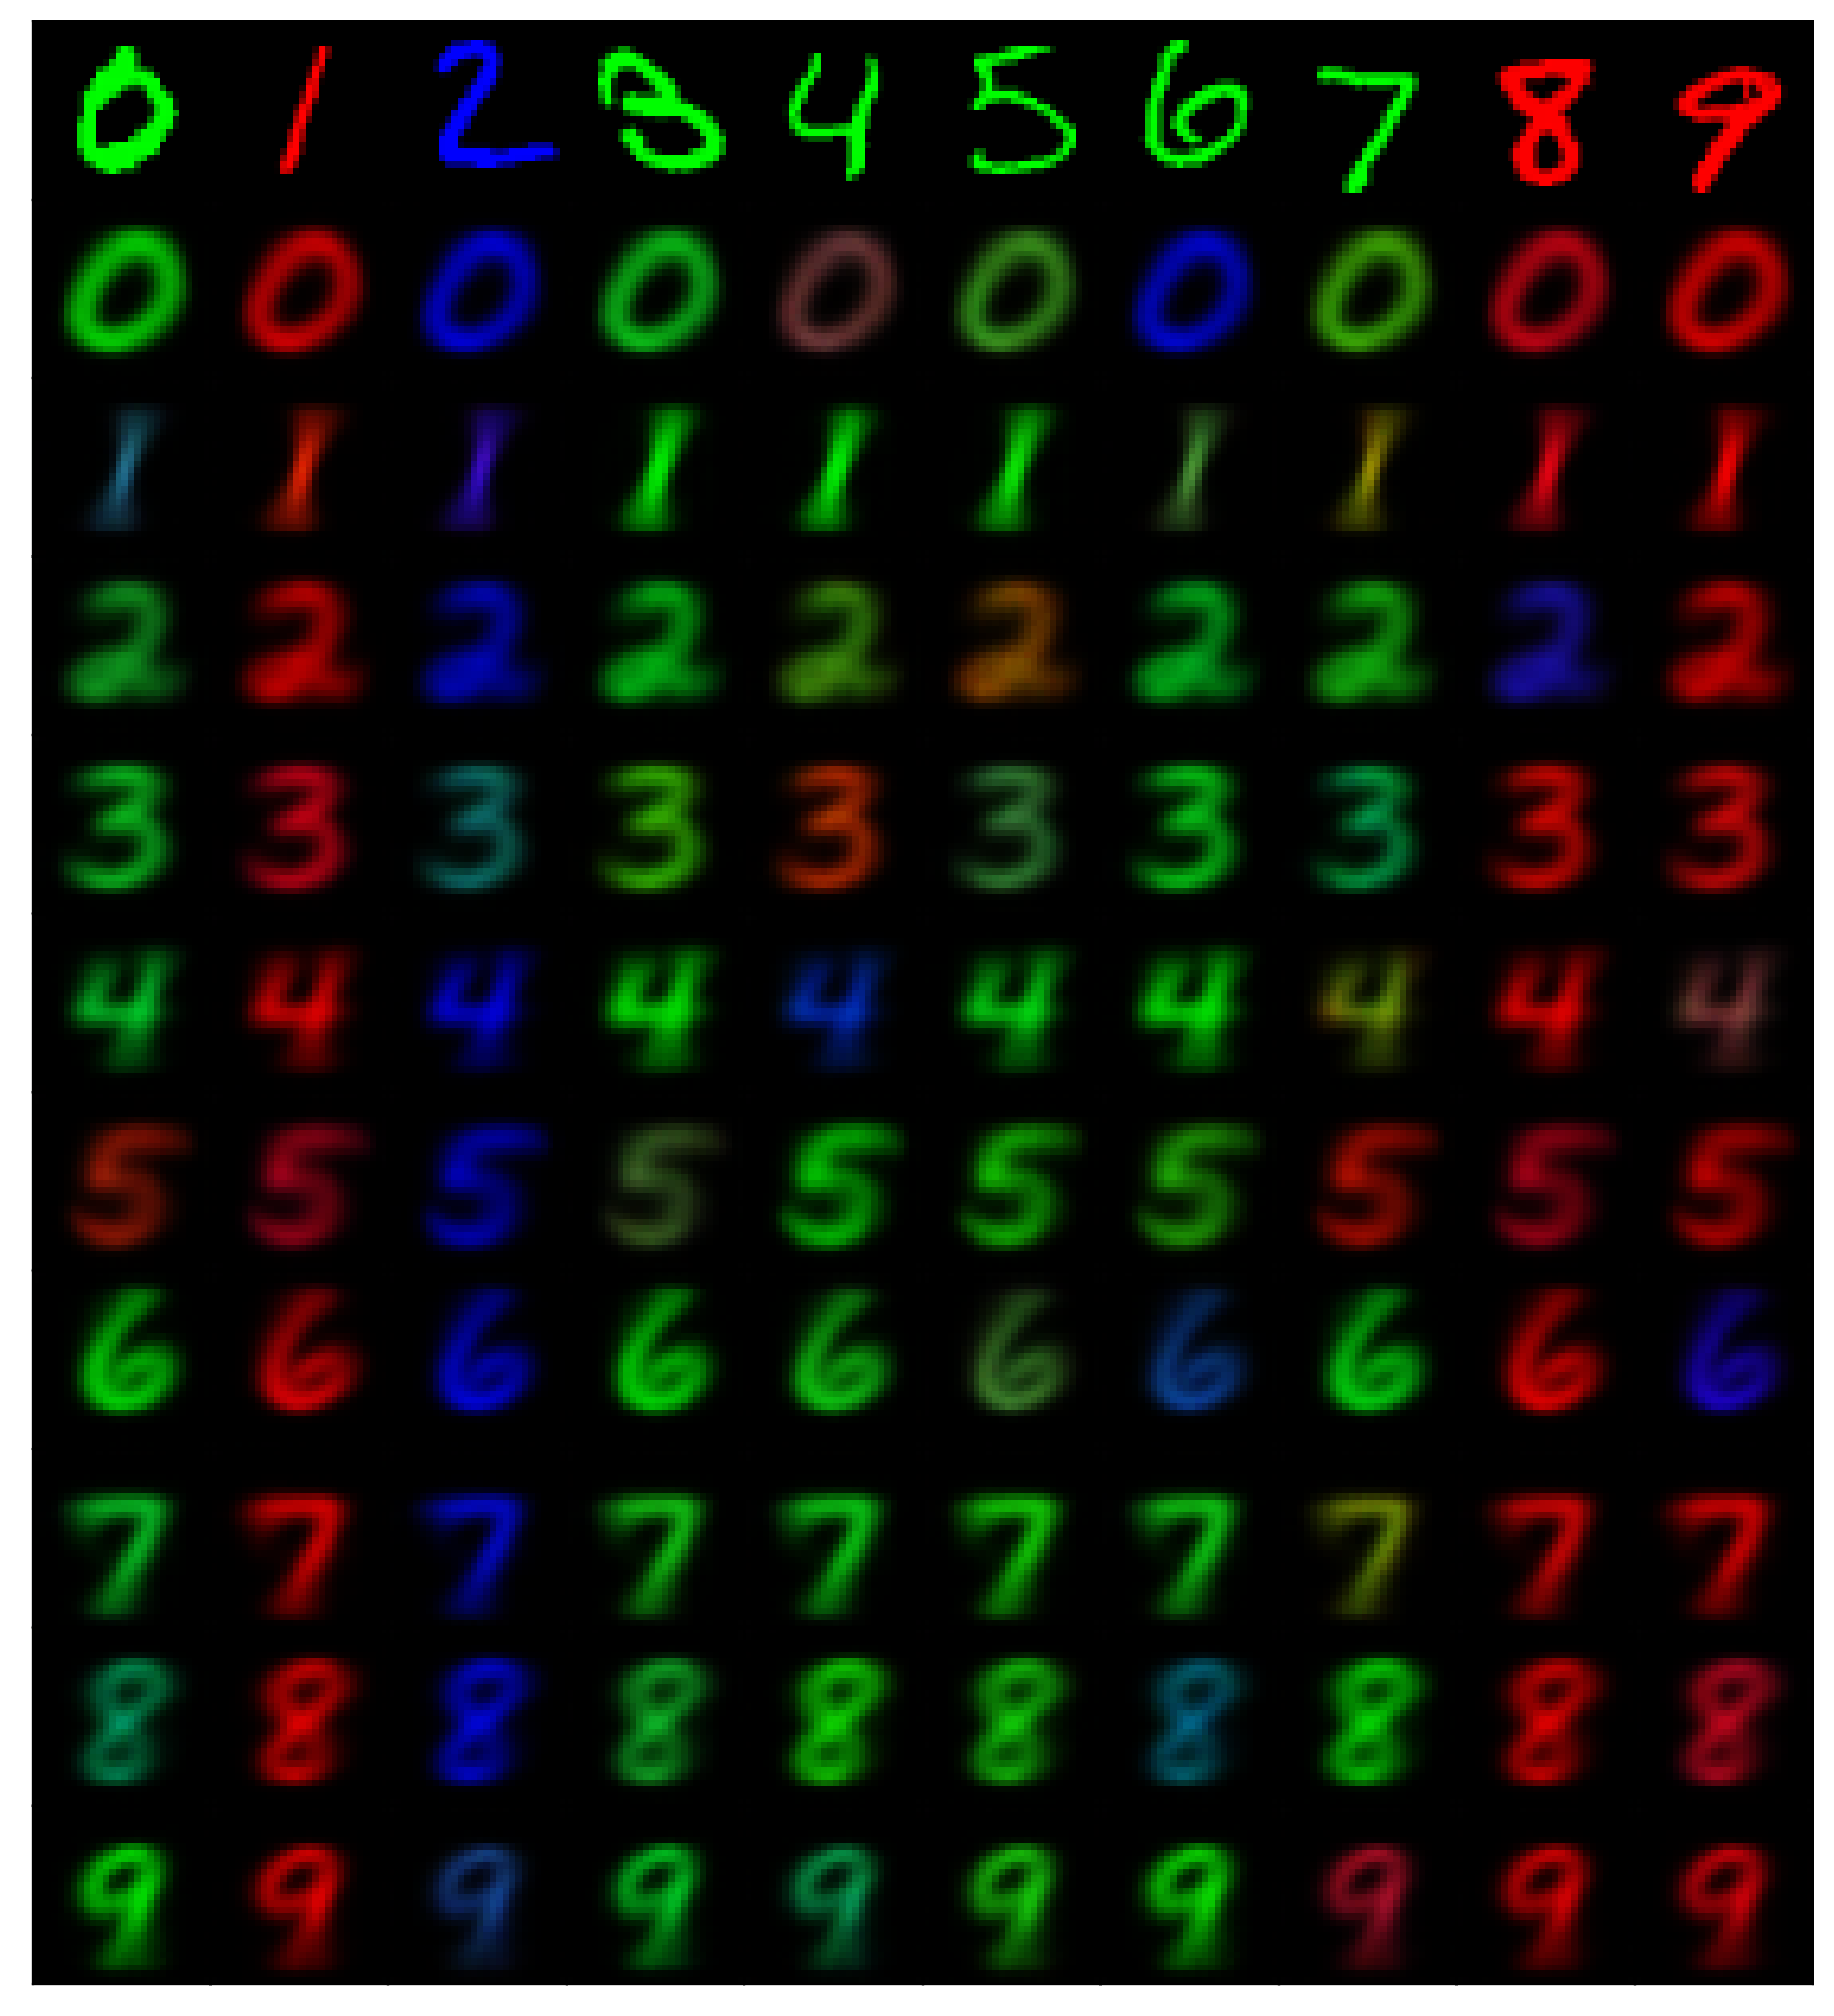

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.8_alpha_0.005_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:0.3205, u:0.4883, dz:0.1265, edz:-0.0529, prior:0.0000, du:0.1462, gdu:-0.0604
One epoch execution time: 5.27829 seconds
20, mse:0.3106, u:0.4735, dz:0.1156, edz:-0.0555, prior:0.0000, du:0.1454, gdu:-0.0615
One epoch execution time: 0.19306 seconds
40, mse:0.3217, u:0.4922, dz:0.1148, edz:-0.0515, prior:0.0000, du:0.1446, gdu:-0.0615
One epoch execution time: 0.41095 seconds
60, mse:0.3214, u:0.4891, dz:0.1142, edz:-0.0498, prior:0.0000, du:0.1429, gdu:-0.0615
One epoch execution time: 0.19166 seconds
80, mse:0.3213, u:0.5007, dz:0.1138, edz:-0.0494, prior:0.0000, du:0.1427, gdu:-0.0615
One epoch execution time: 0.19788 seconds
Total Execution Time: 0.4155 minutes
Evaluate performance U


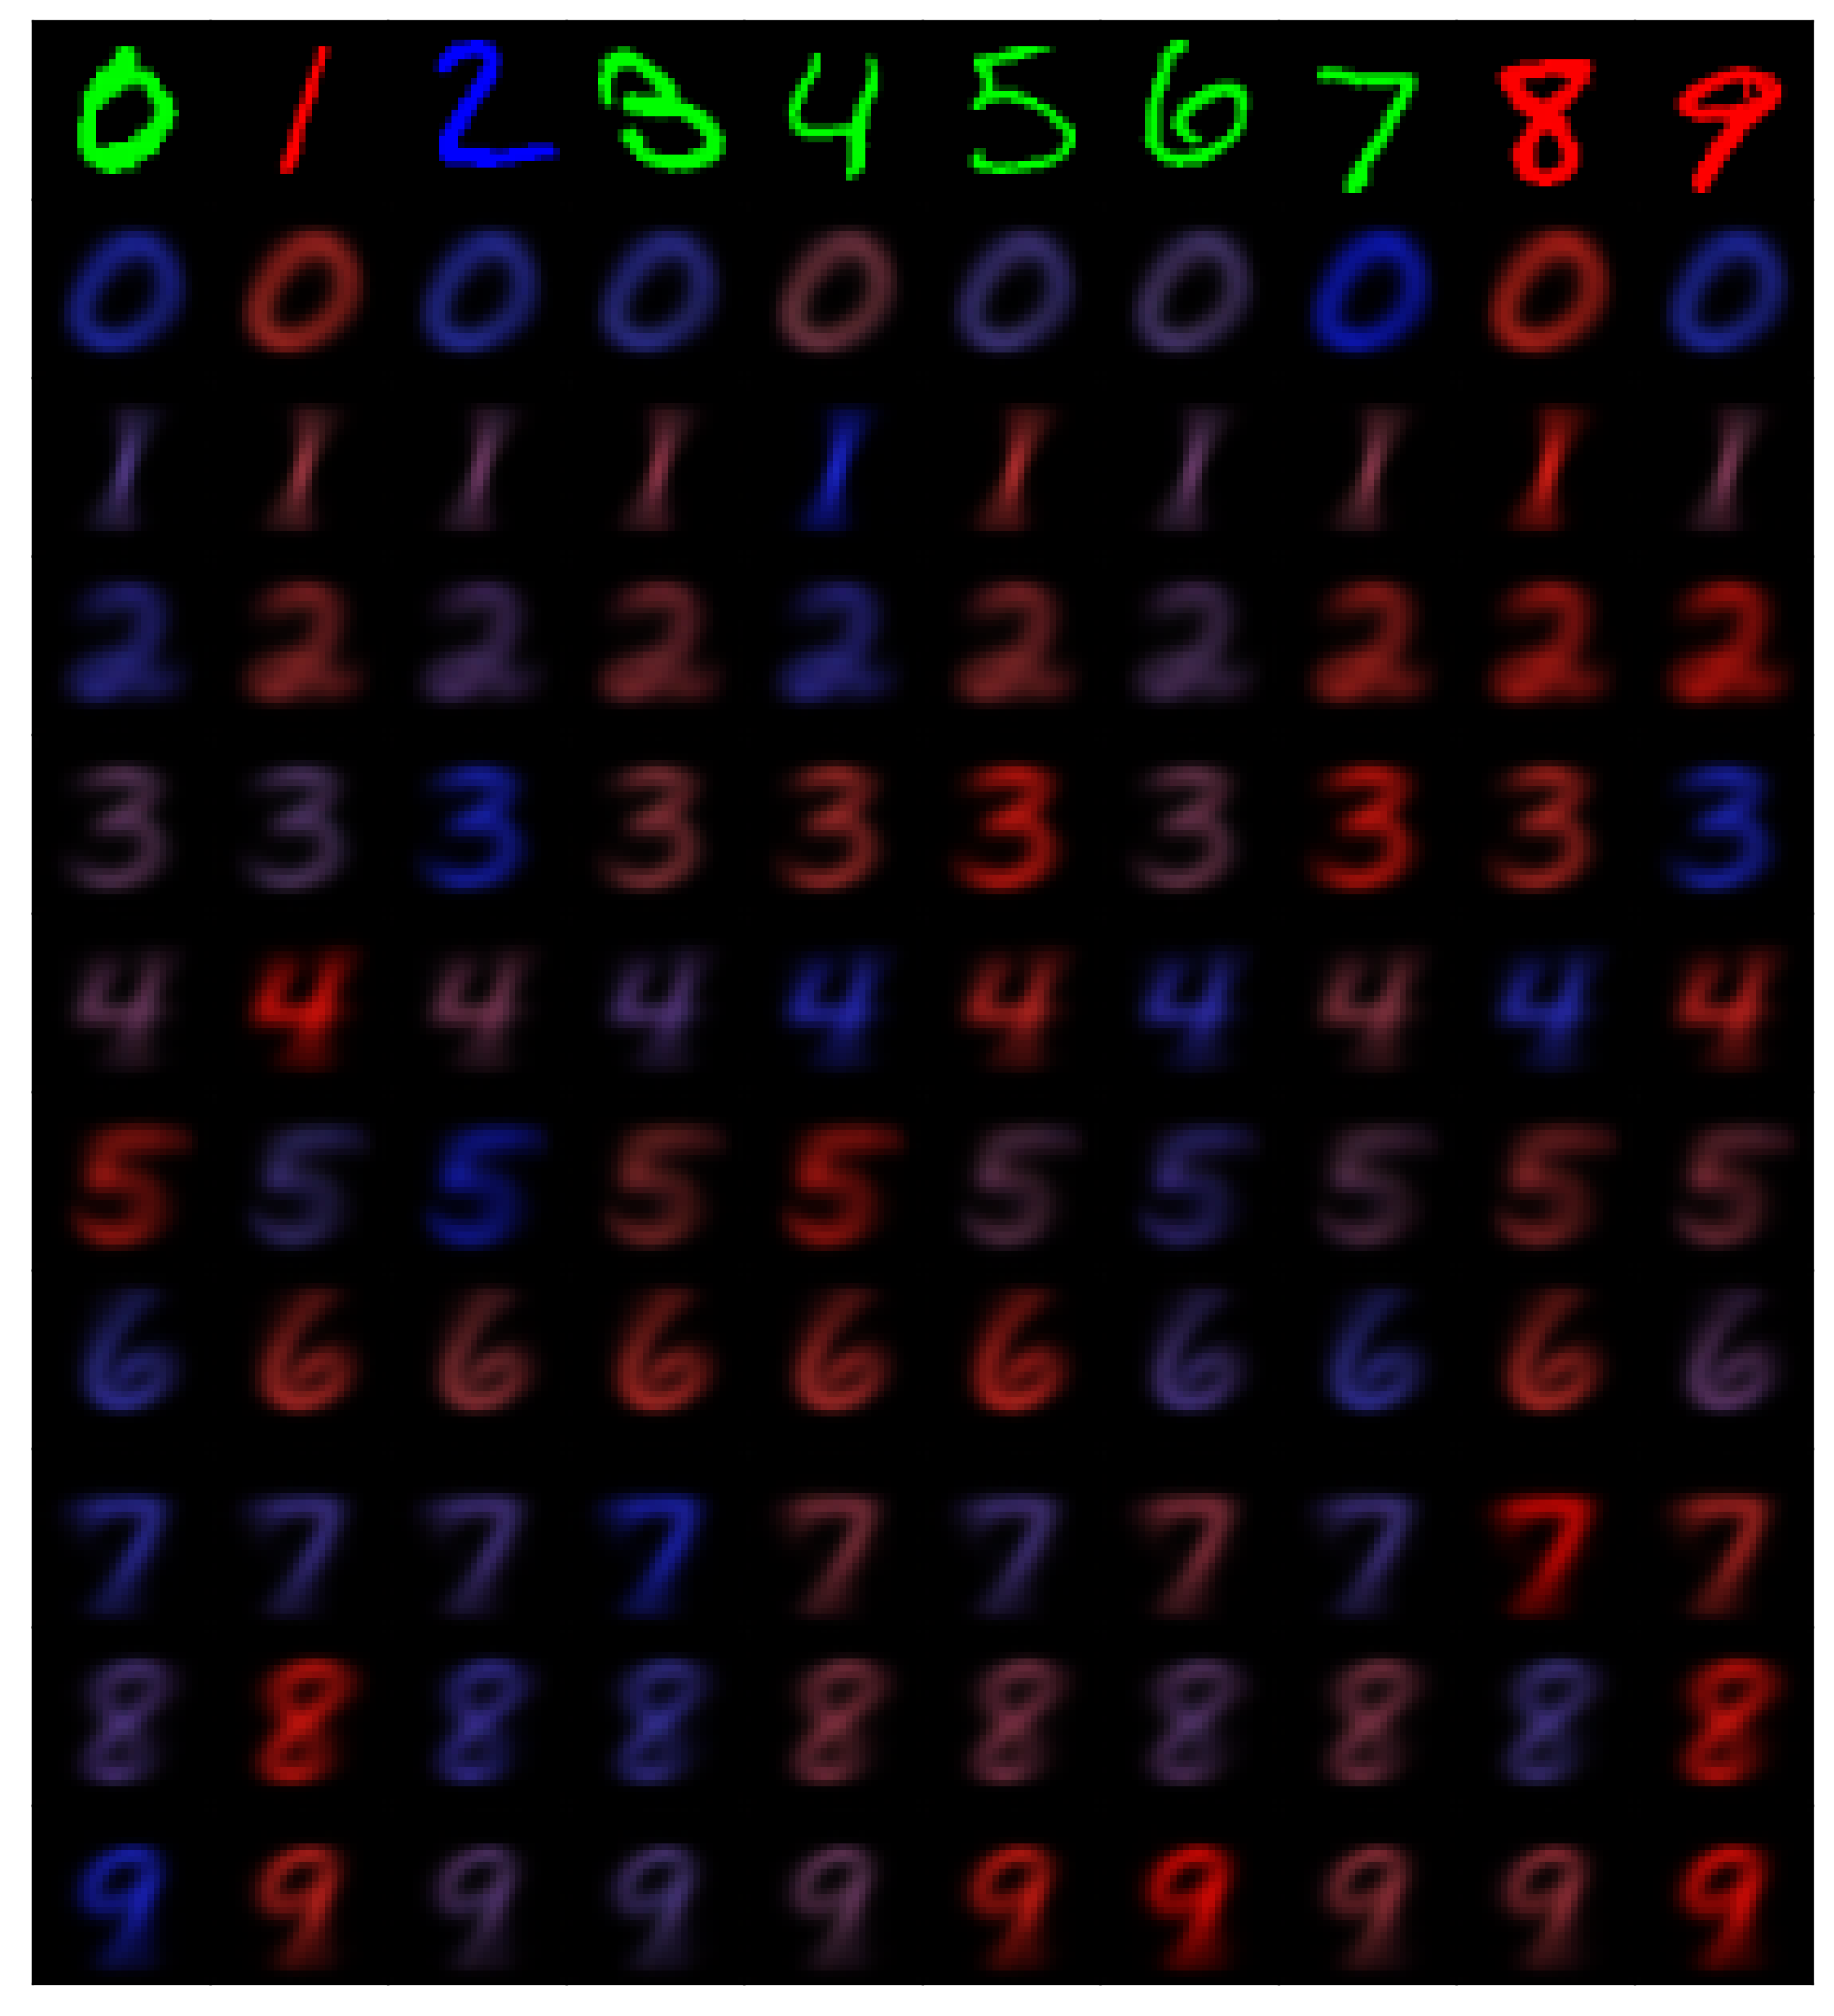

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.95_alpha_0.005_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:0.3458, u:0.5947, dz:0.1438, edz:-0.0674, prior:0.0000, du:0.1847, gdu:-0.0690
One epoch execution time: 4.63634 seconds
20, mse:0.3402, u:0.6101, dz:0.1335, edz:-0.0644, prior:0.0000, du:0.1776, gdu:-0.0650
One epoch execution time: 0.20600 seconds
40, mse:0.3436, u:0.5847, dz:0.1333, edz:-0.0639, prior:0.0000, du:0.1689, gdu:-0.0637
One epoch execution time: 0.20012 seconds
60, mse:0.3436, u:0.5916, dz:0.1334, edz:-0.0637, prior:0.0000, du:0.1639, gdu:-0.0639
One epoch execution time: 0.20183 seconds
80, mse:0.3463, u:0.5880, dz:0.1332, edz:-0.0638, prior:0.0000, du:0.1586, gdu:-0.0654
One epoch execution time: 0.19914 seconds
Total Execution Time: 0.4069 minutes
Evaluate performance U


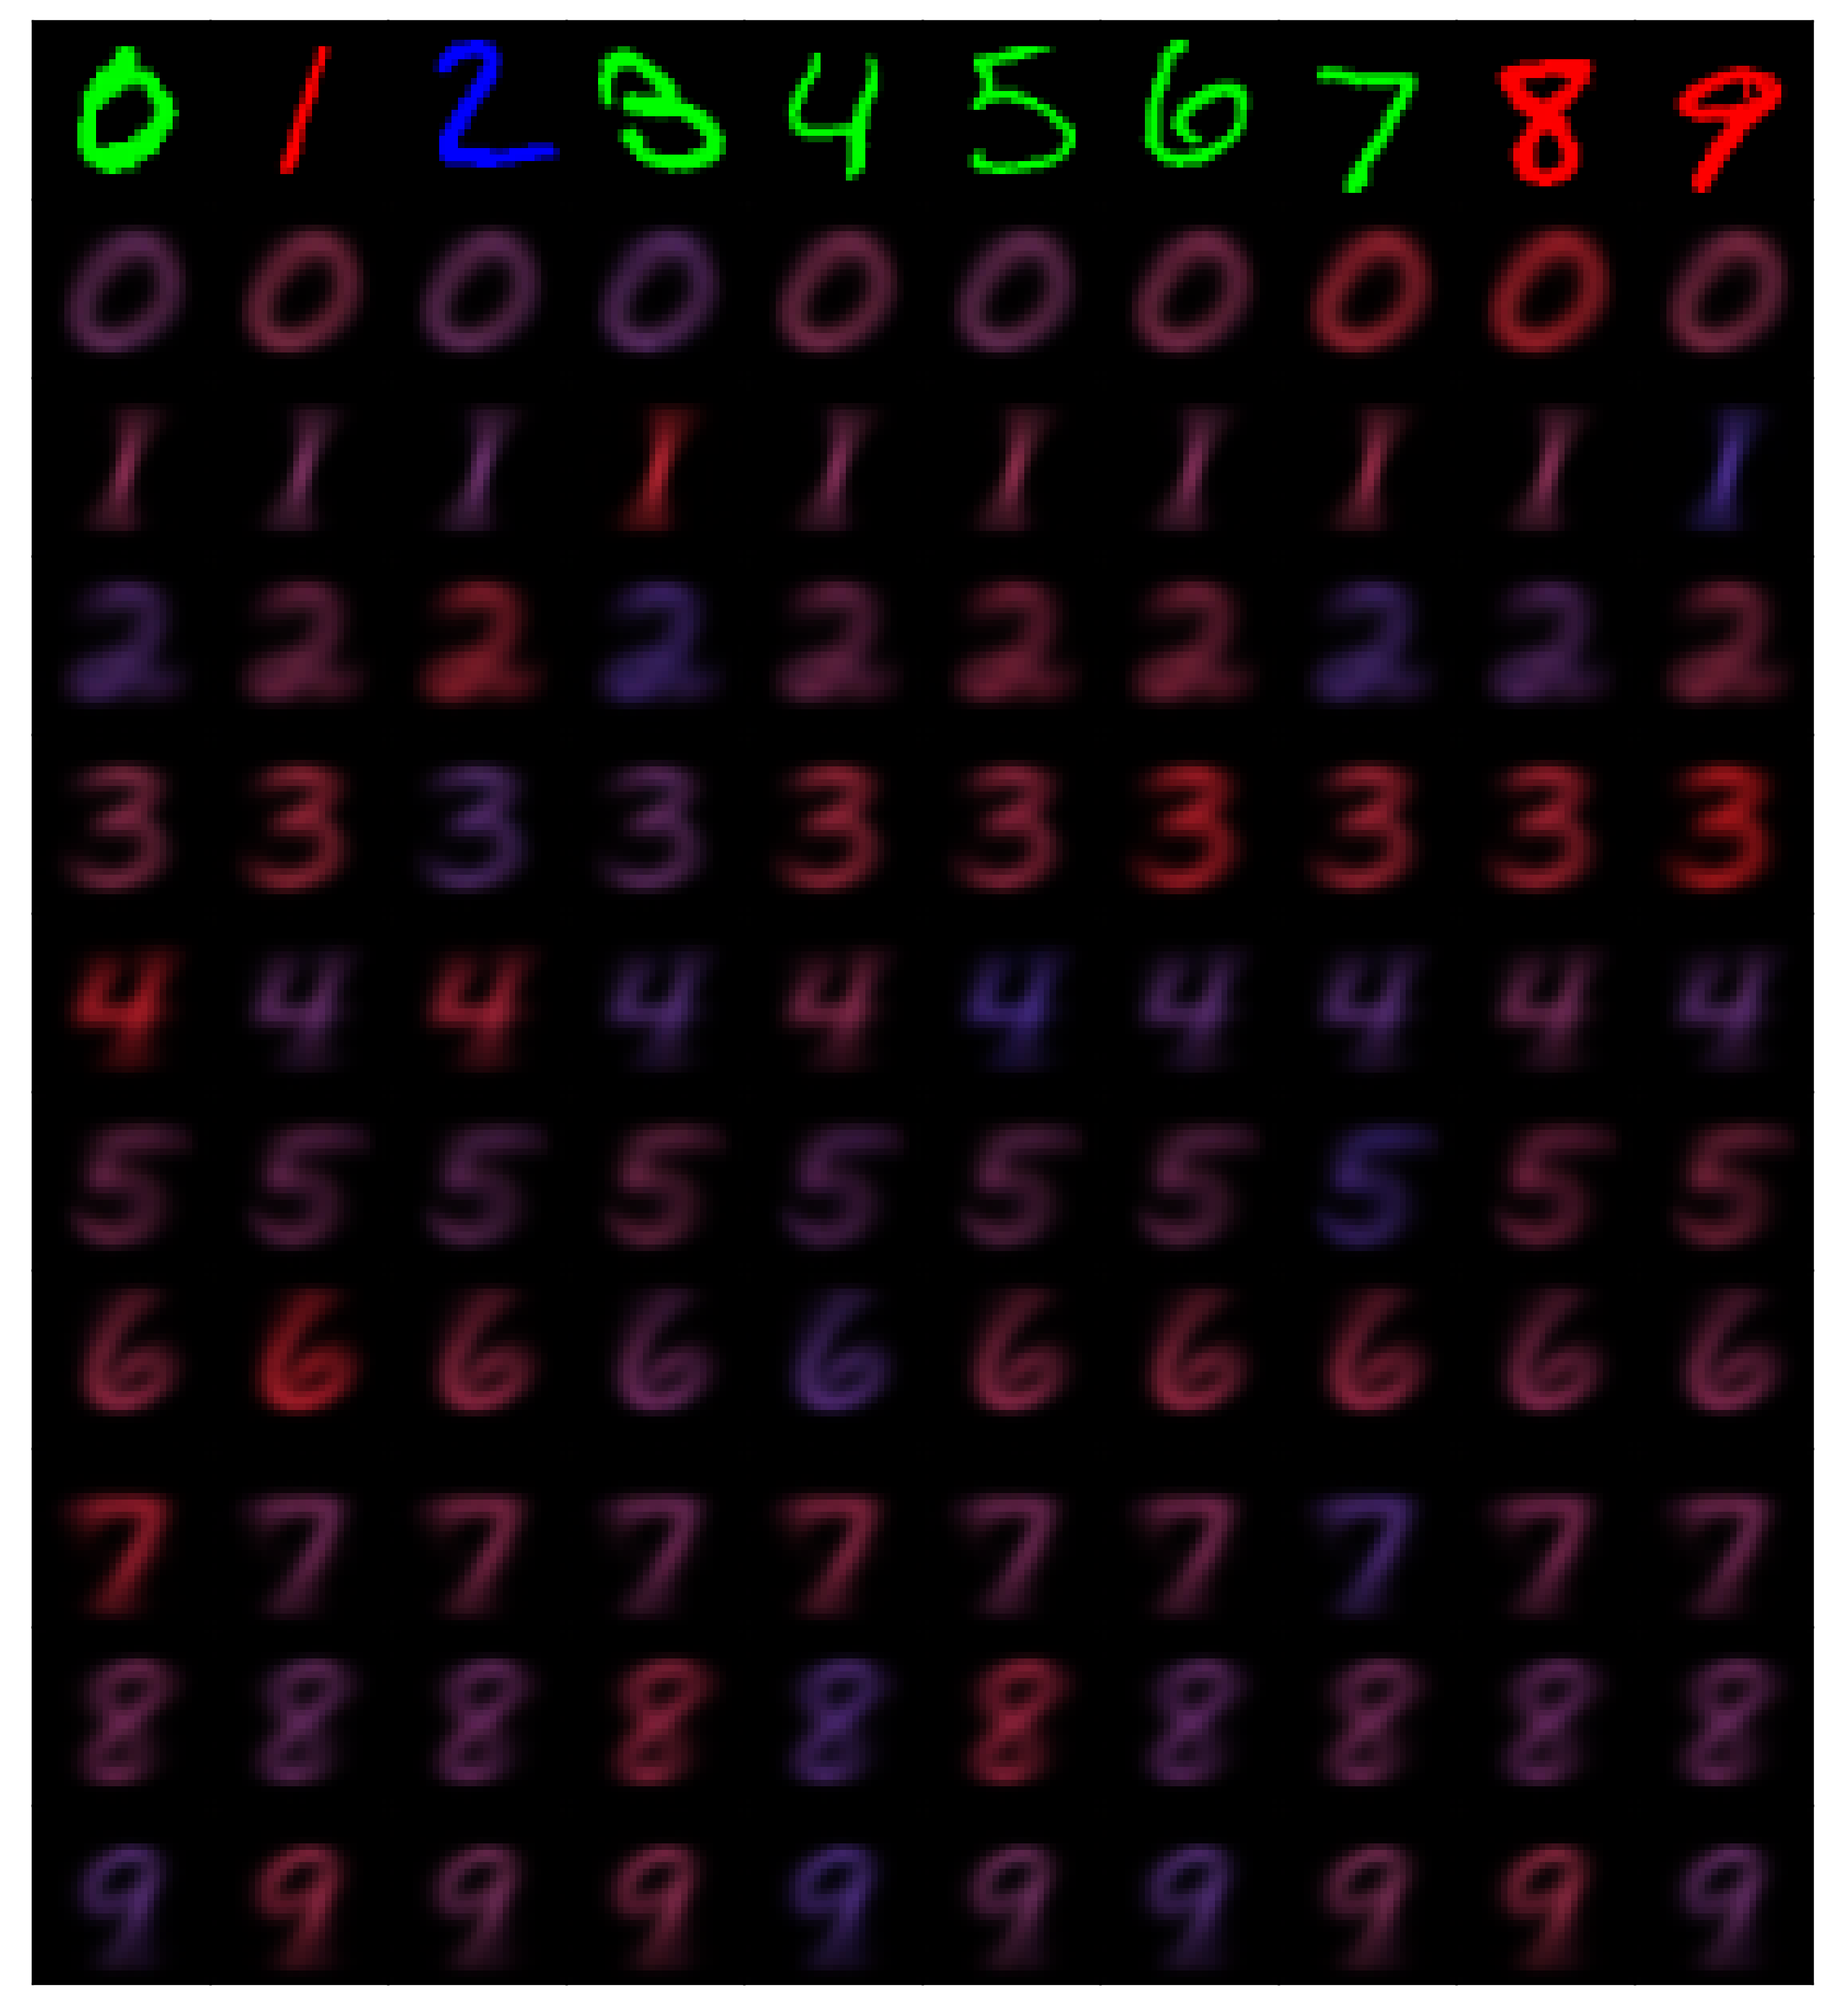

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.0001_alpha_0.2_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:3.2602, u:0.0016, dz:0.0306, edz:-0.0135, prior:0.0000, du:0.1470, gdu:-0.0555
One epoch execution time: 4.91251 seconds
20, mse:3.2964, u:0.0047, dz:0.0280, edz:-0.0147, prior:0.0000, du:0.1459, gdu:-0.0618
One epoch execution time: 0.20076 seconds
40, mse:3.2756, u:0.0003, dz:0.0279, edz:-0.0150, prior:0.0000, du:0.1445, gdu:-0.0647
One epoch execution time: 0.21406 seconds
60, mse:3.2016, u:0.0024, dz:0.0277, edz:-0.0151, prior:0.0000, du:0.1439, gdu:-0.0650
One epoch execution time: 0.21059 seconds
80, mse:3.2605, u:0.0025, dz:0.0274, edz:-0.0152, prior:0.0000, du:0.1435, gdu:-0.0654
One epoch execution time: 0.20522 seconds
Total Execution Time: 0.4175 minutes
Evaluate performance U


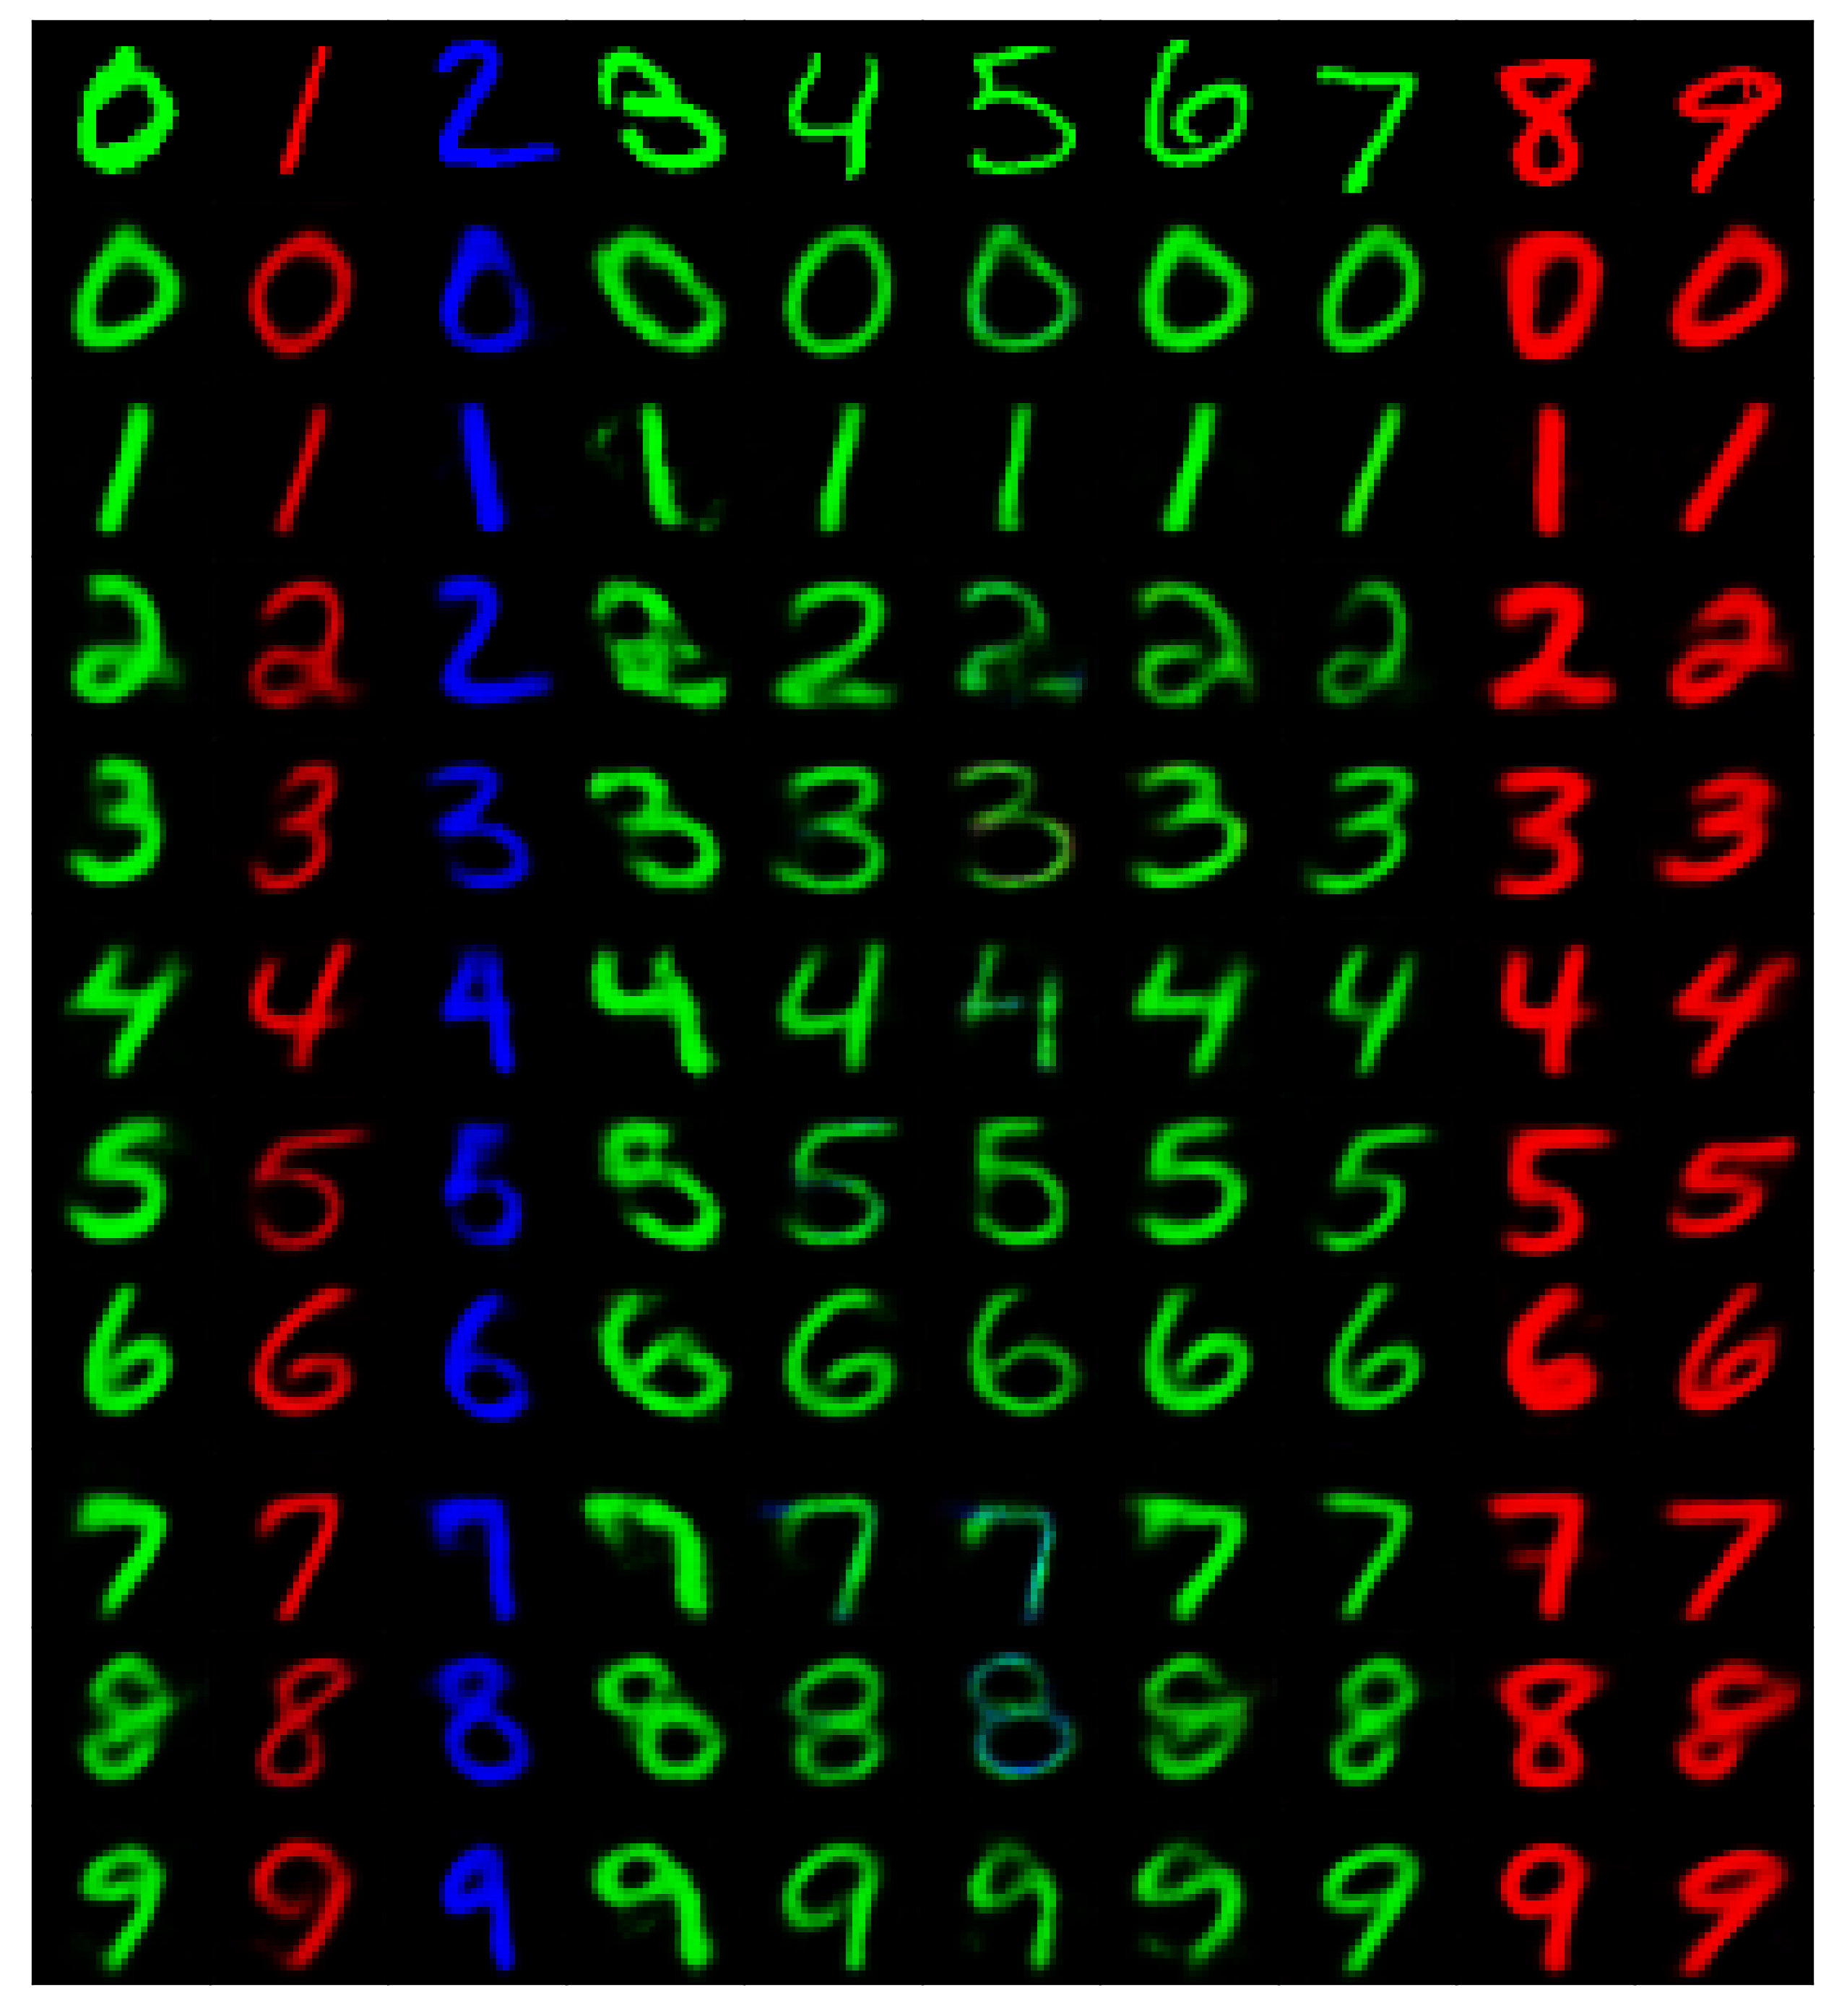

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.1_alpha_0.2_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:3.8295, u:0.0032, dz:0.0496, edz:-0.0217, prior:0.0000, du:0.1600, gdu:-0.0665
One epoch execution time: 5.37753 seconds
20, mse:3.8062, u:0.0019, dz:0.0428, edz:-0.0214, prior:0.0000, du:0.1500, gdu:-0.0656
One epoch execution time: 0.20858 seconds
40, mse:3.7420, u:0.0055, dz:0.0422, edz:-0.0228, prior:0.0000, du:0.1448, gdu:-0.0676
One epoch execution time: 0.19642 seconds
60, mse:3.7986, u:0.0051, dz:0.0420, edz:-0.0237, prior:0.0000, du:0.1417, gdu:-0.0693
One epoch execution time: 0.20072 seconds
80, mse:3.8761, u:0.0046, dz:0.0416, edz:-0.0240, prior:0.0000, du:0.1411, gdu:-0.0698
One epoch execution time: 0.21557 seconds
Total Execution Time: 0.4159 minutes
Evaluate performance U


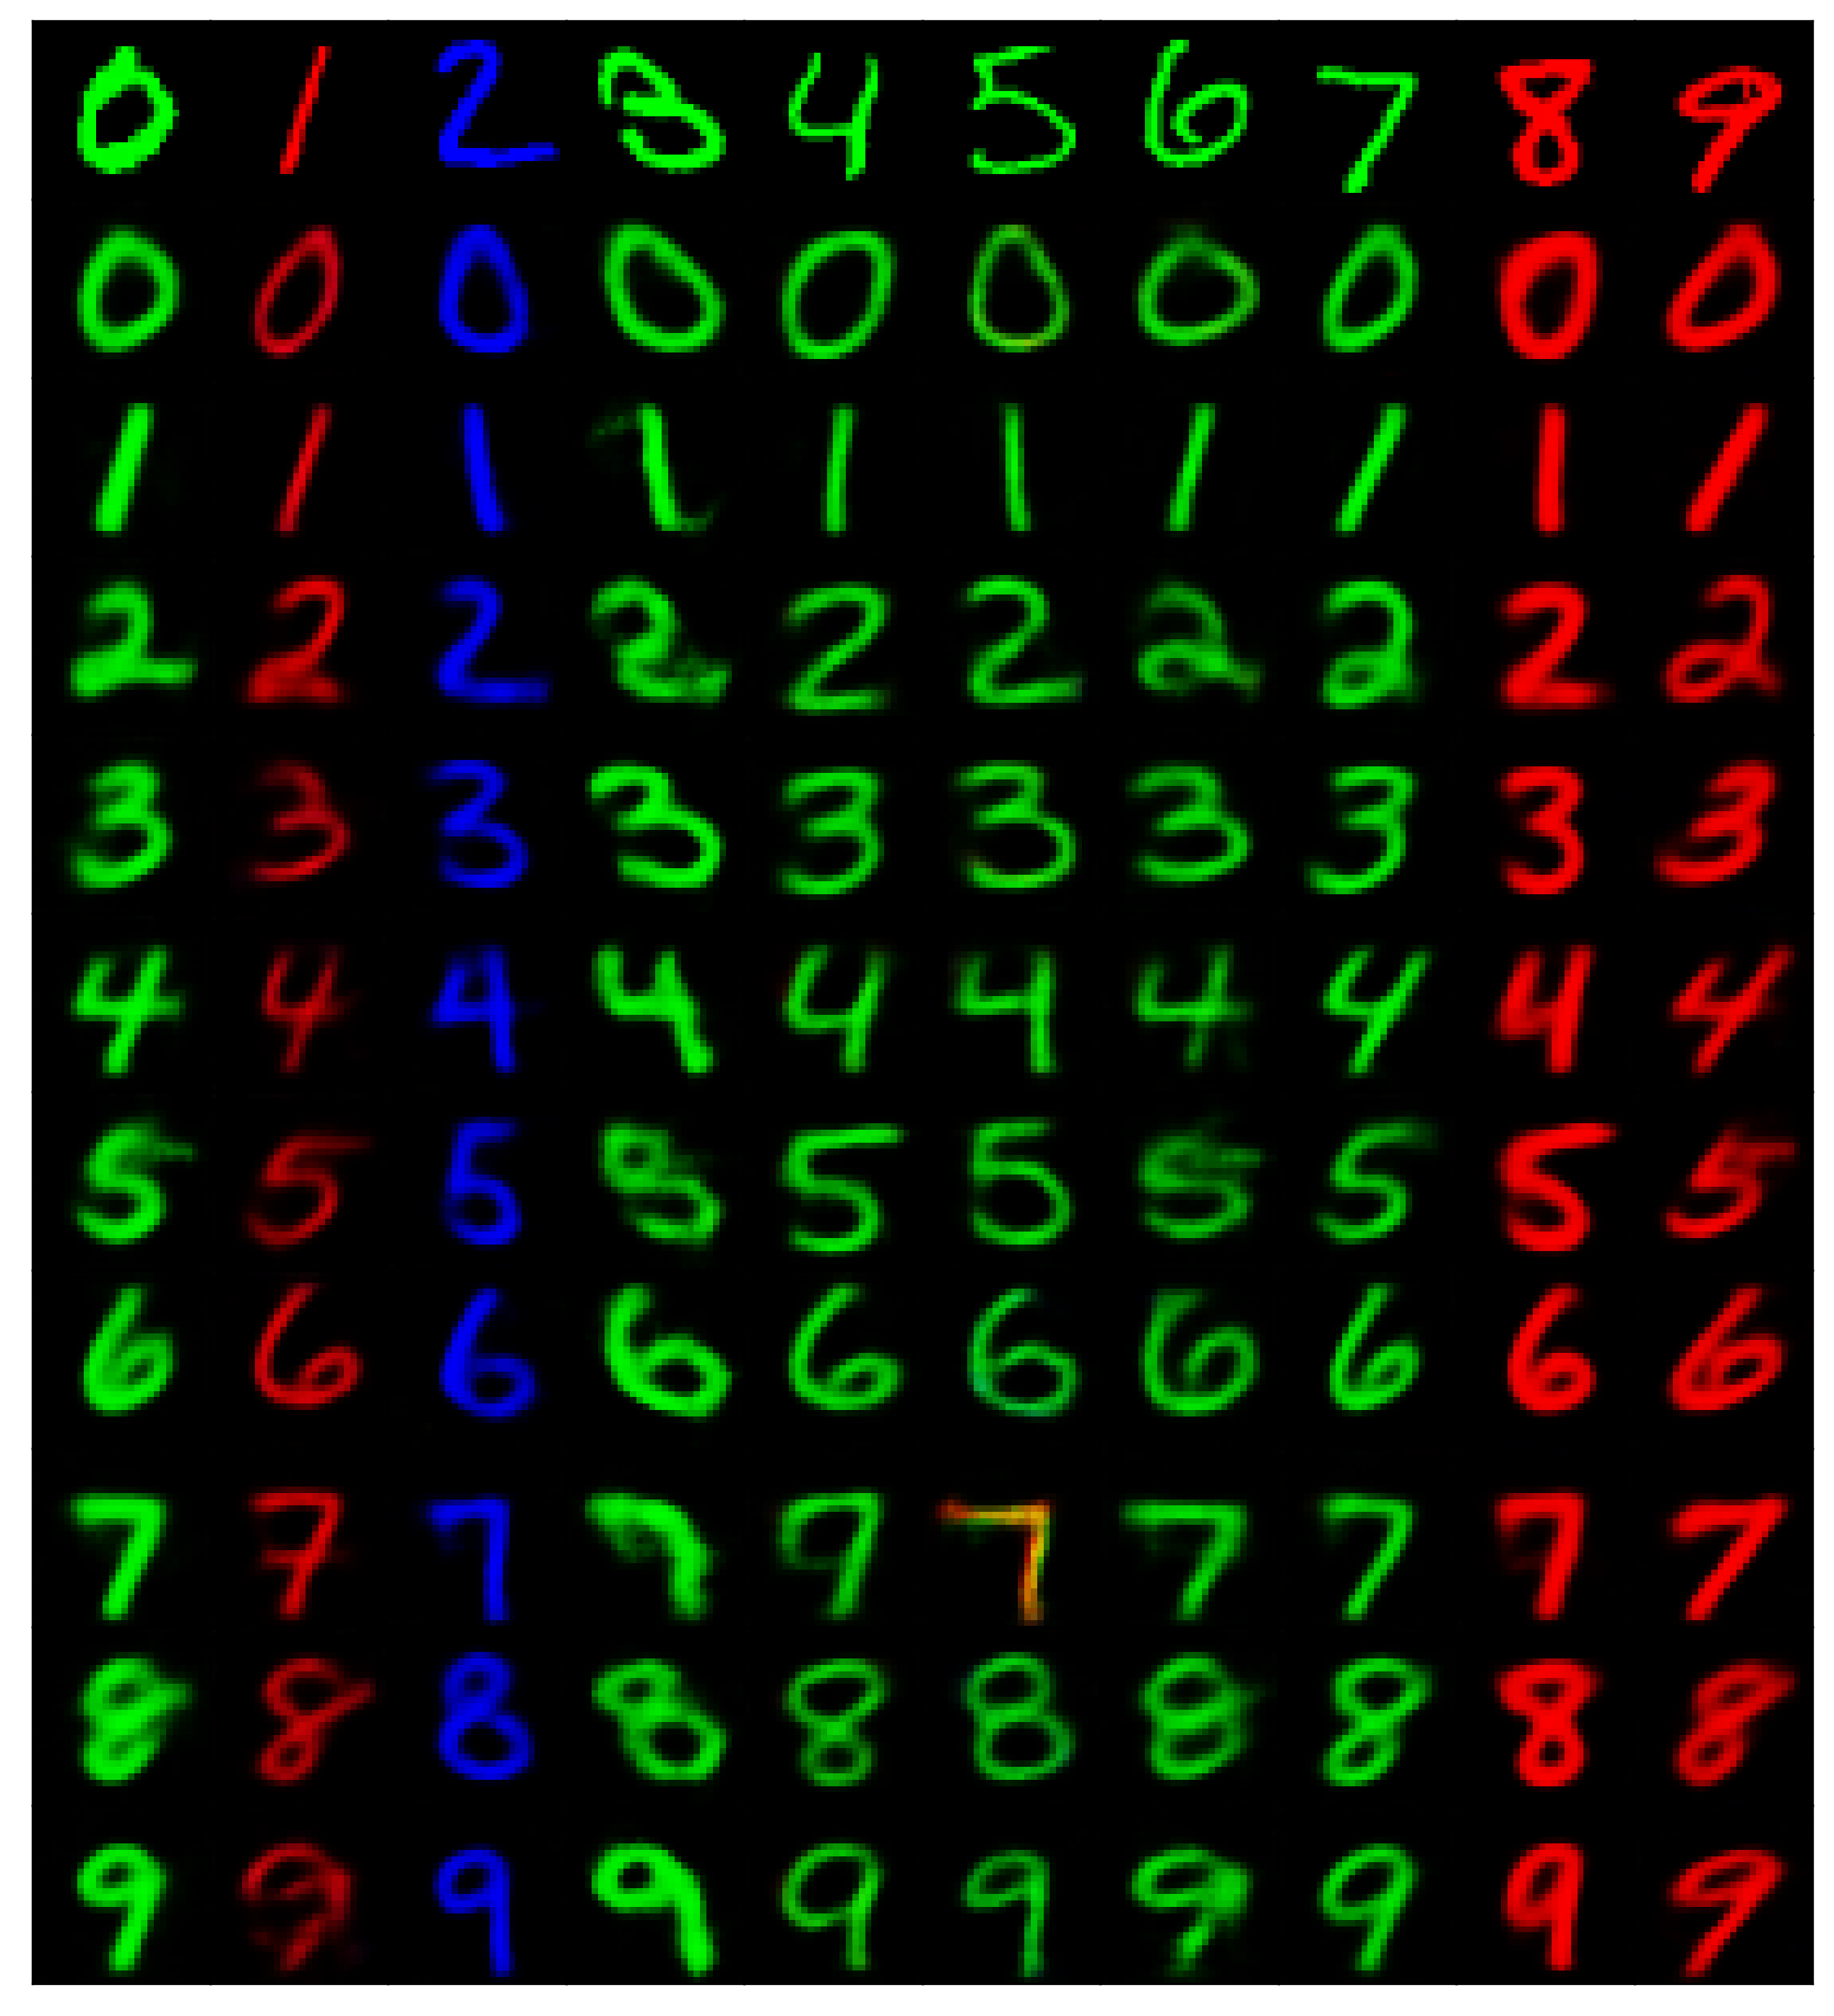

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.3_alpha_0.2_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:4.9923, u:0.0058, dz:0.0791, edz:-0.0362, prior:0.0000, du:0.1422, gdu:-0.0579
One epoch execution time: 4.54840 seconds
20, mse:4.9663, u:0.0054, dz:0.0733, edz:-0.0381, prior:0.0000, du:0.1443, gdu:-0.0619
One epoch execution time: 0.19397 seconds
40, mse:4.9328, u:0.0053, dz:0.0724, edz:-0.0416, prior:0.0000, du:0.1402, gdu:-0.0642
One epoch execution time: 0.20412 seconds
60, mse:4.9273, u:0.0071, dz:0.0716, edz:-0.0434, prior:0.0000, du:0.1394, gdu:-0.0654
One epoch execution time: 0.20517 seconds
80, mse:4.9705, u:0.0056, dz:0.0705, edz:-0.0442, prior:0.0000, du:0.1404, gdu:-0.0661
One epoch execution time: 0.20269 seconds
Total Execution Time: 0.4231 minutes
Evaluate performance U


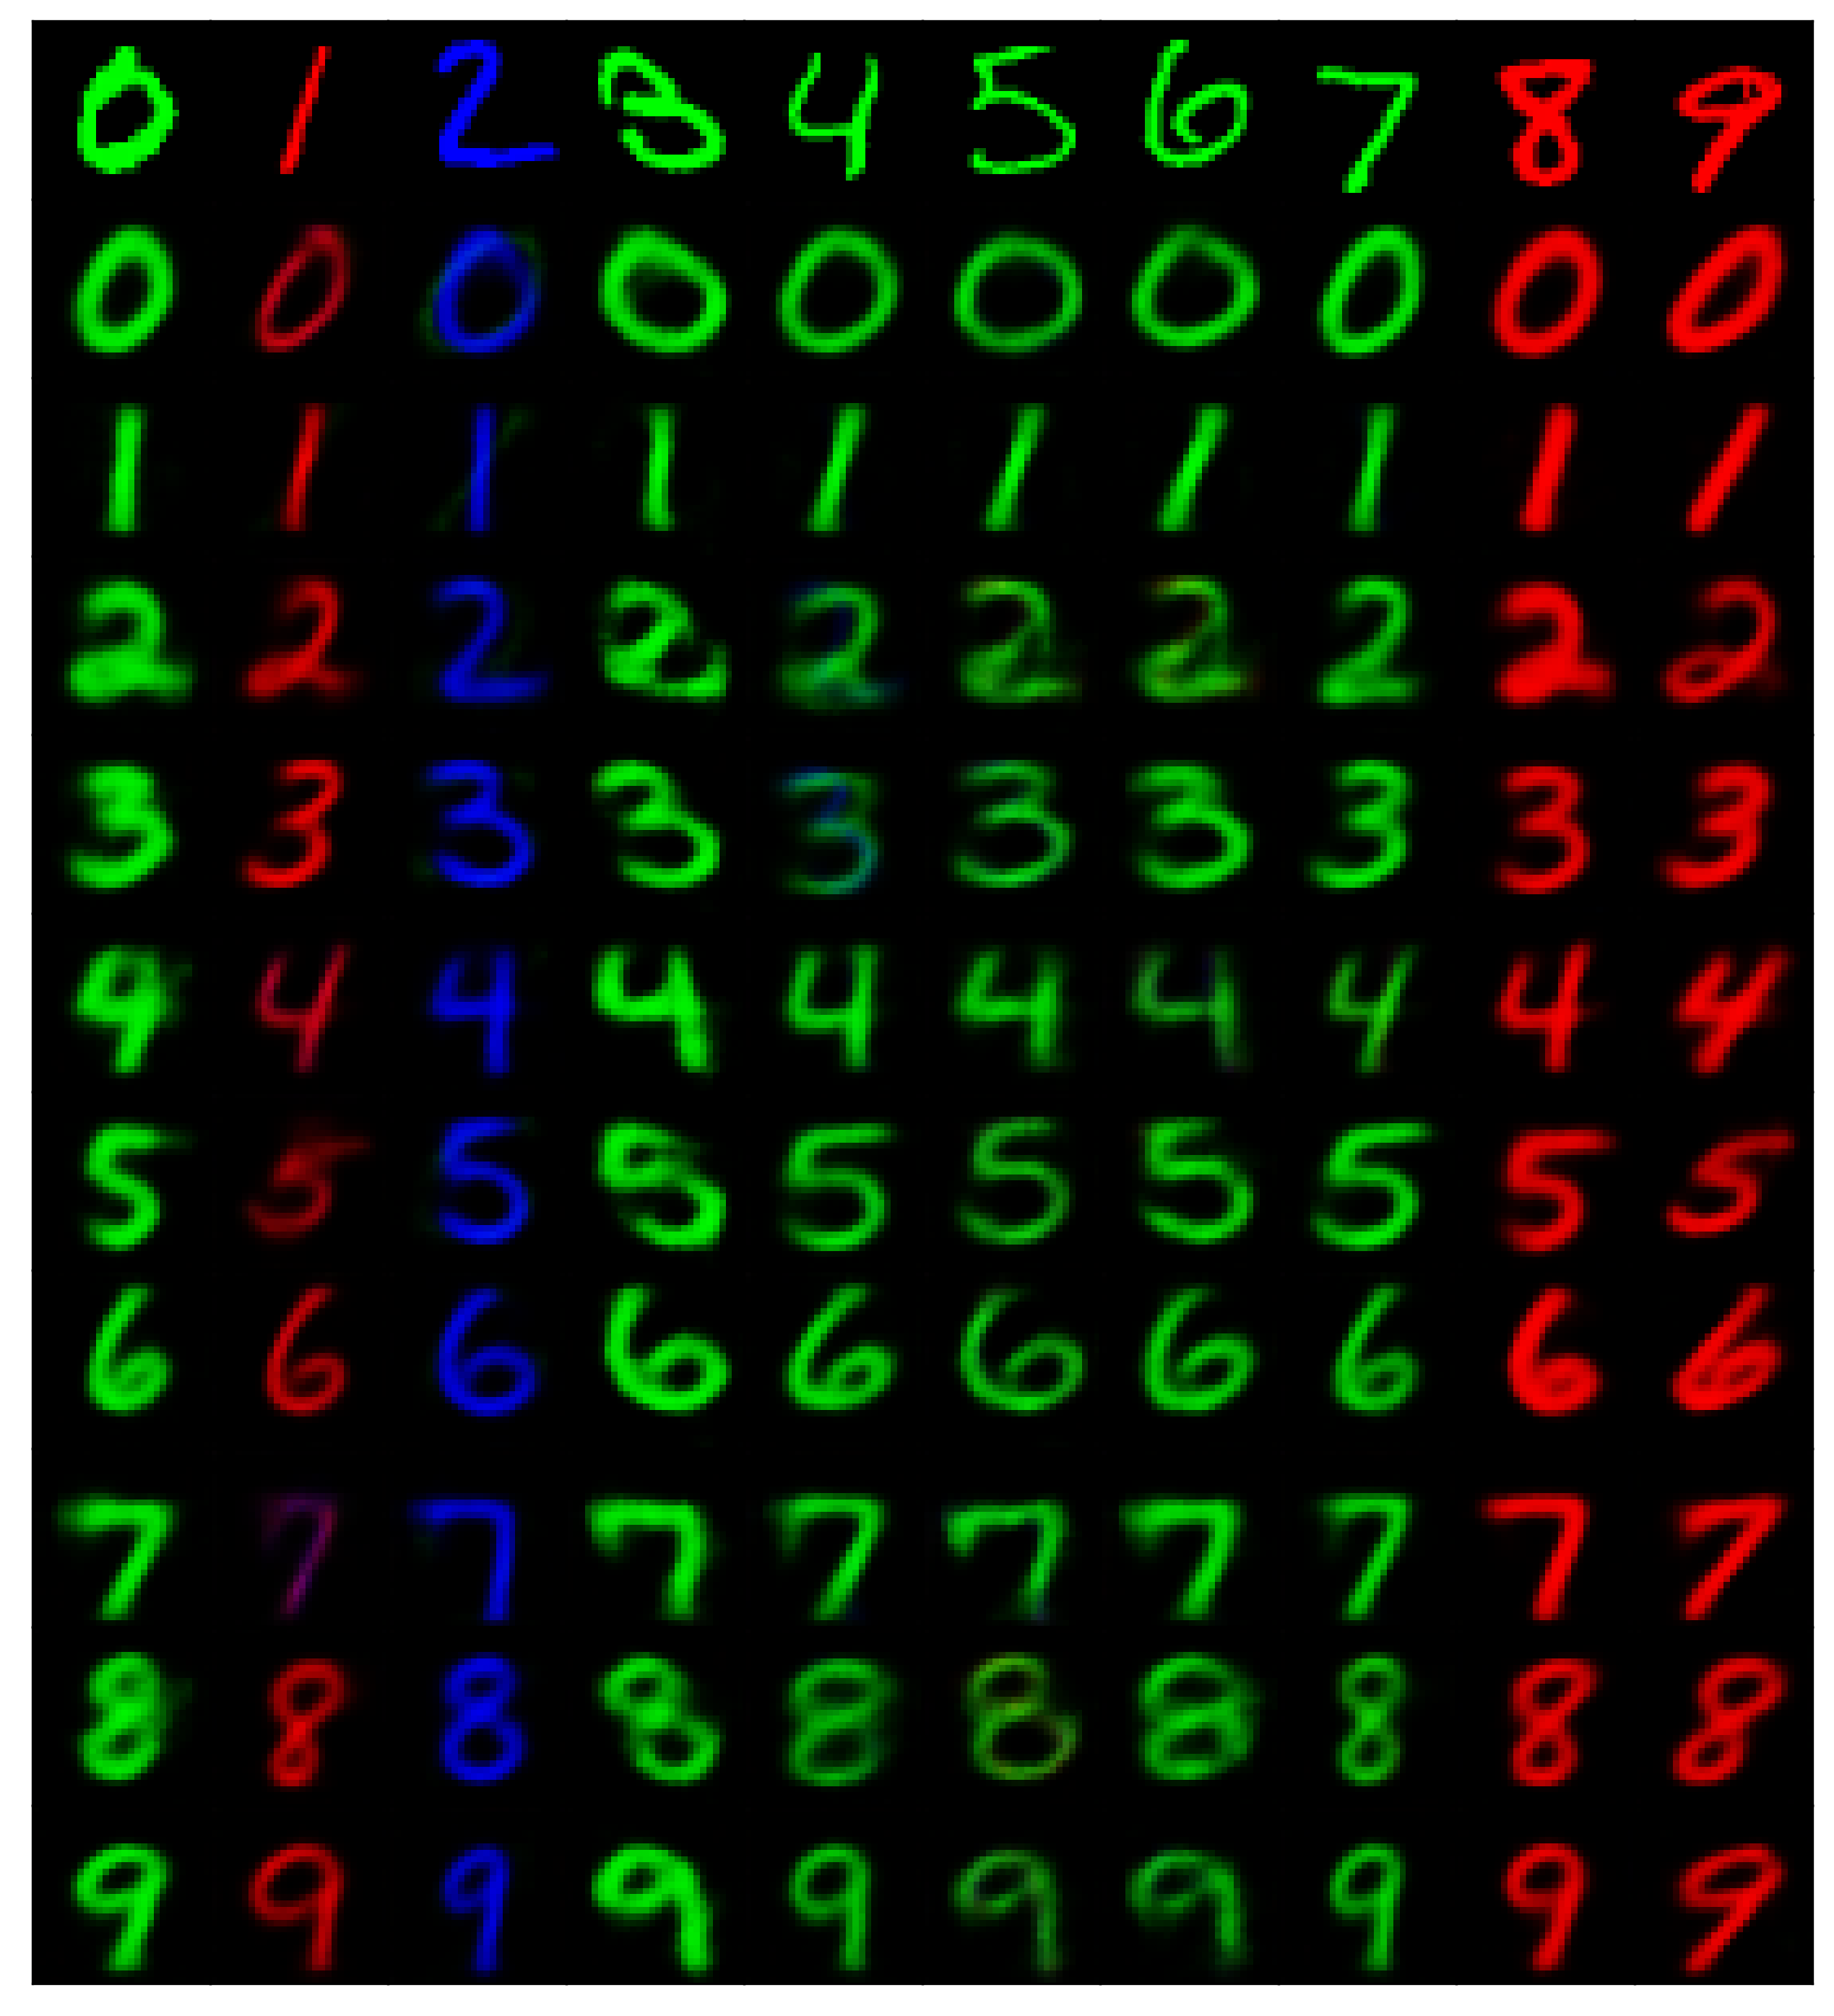

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.5_alpha_0.2_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:5.9051, u:0.0109, dz:0.1081, edz:-0.0478, prior:0.0000, du:0.2049, gdu:-0.0688
One epoch execution time: 5.85813 seconds
20, mse:5.7086, u:0.0099, dz:0.0979, edz:-0.0486, prior:0.0000, du:0.2015, gdu:-0.0738
One epoch execution time: 0.20535 seconds
40, mse:6.0198, u:0.0099, dz:0.0978, edz:-0.0464, prior:0.0000, du:0.1949, gdu:-0.0792
One epoch execution time: 0.21080 seconds
60, mse:5.8799, u:0.0087, dz:0.0975, edz:-0.0454, prior:0.0000, du:0.1900, gdu:-0.0836
One epoch execution time: 0.21592 seconds
80, mse:5.9497, u:0.0075, dz:0.0972, edz:-0.0450, prior:0.0000, du:0.1846, gdu:-0.0862
One epoch execution time: 0.20228 seconds
Total Execution Time: 0.4438 minutes
Evaluate performance U


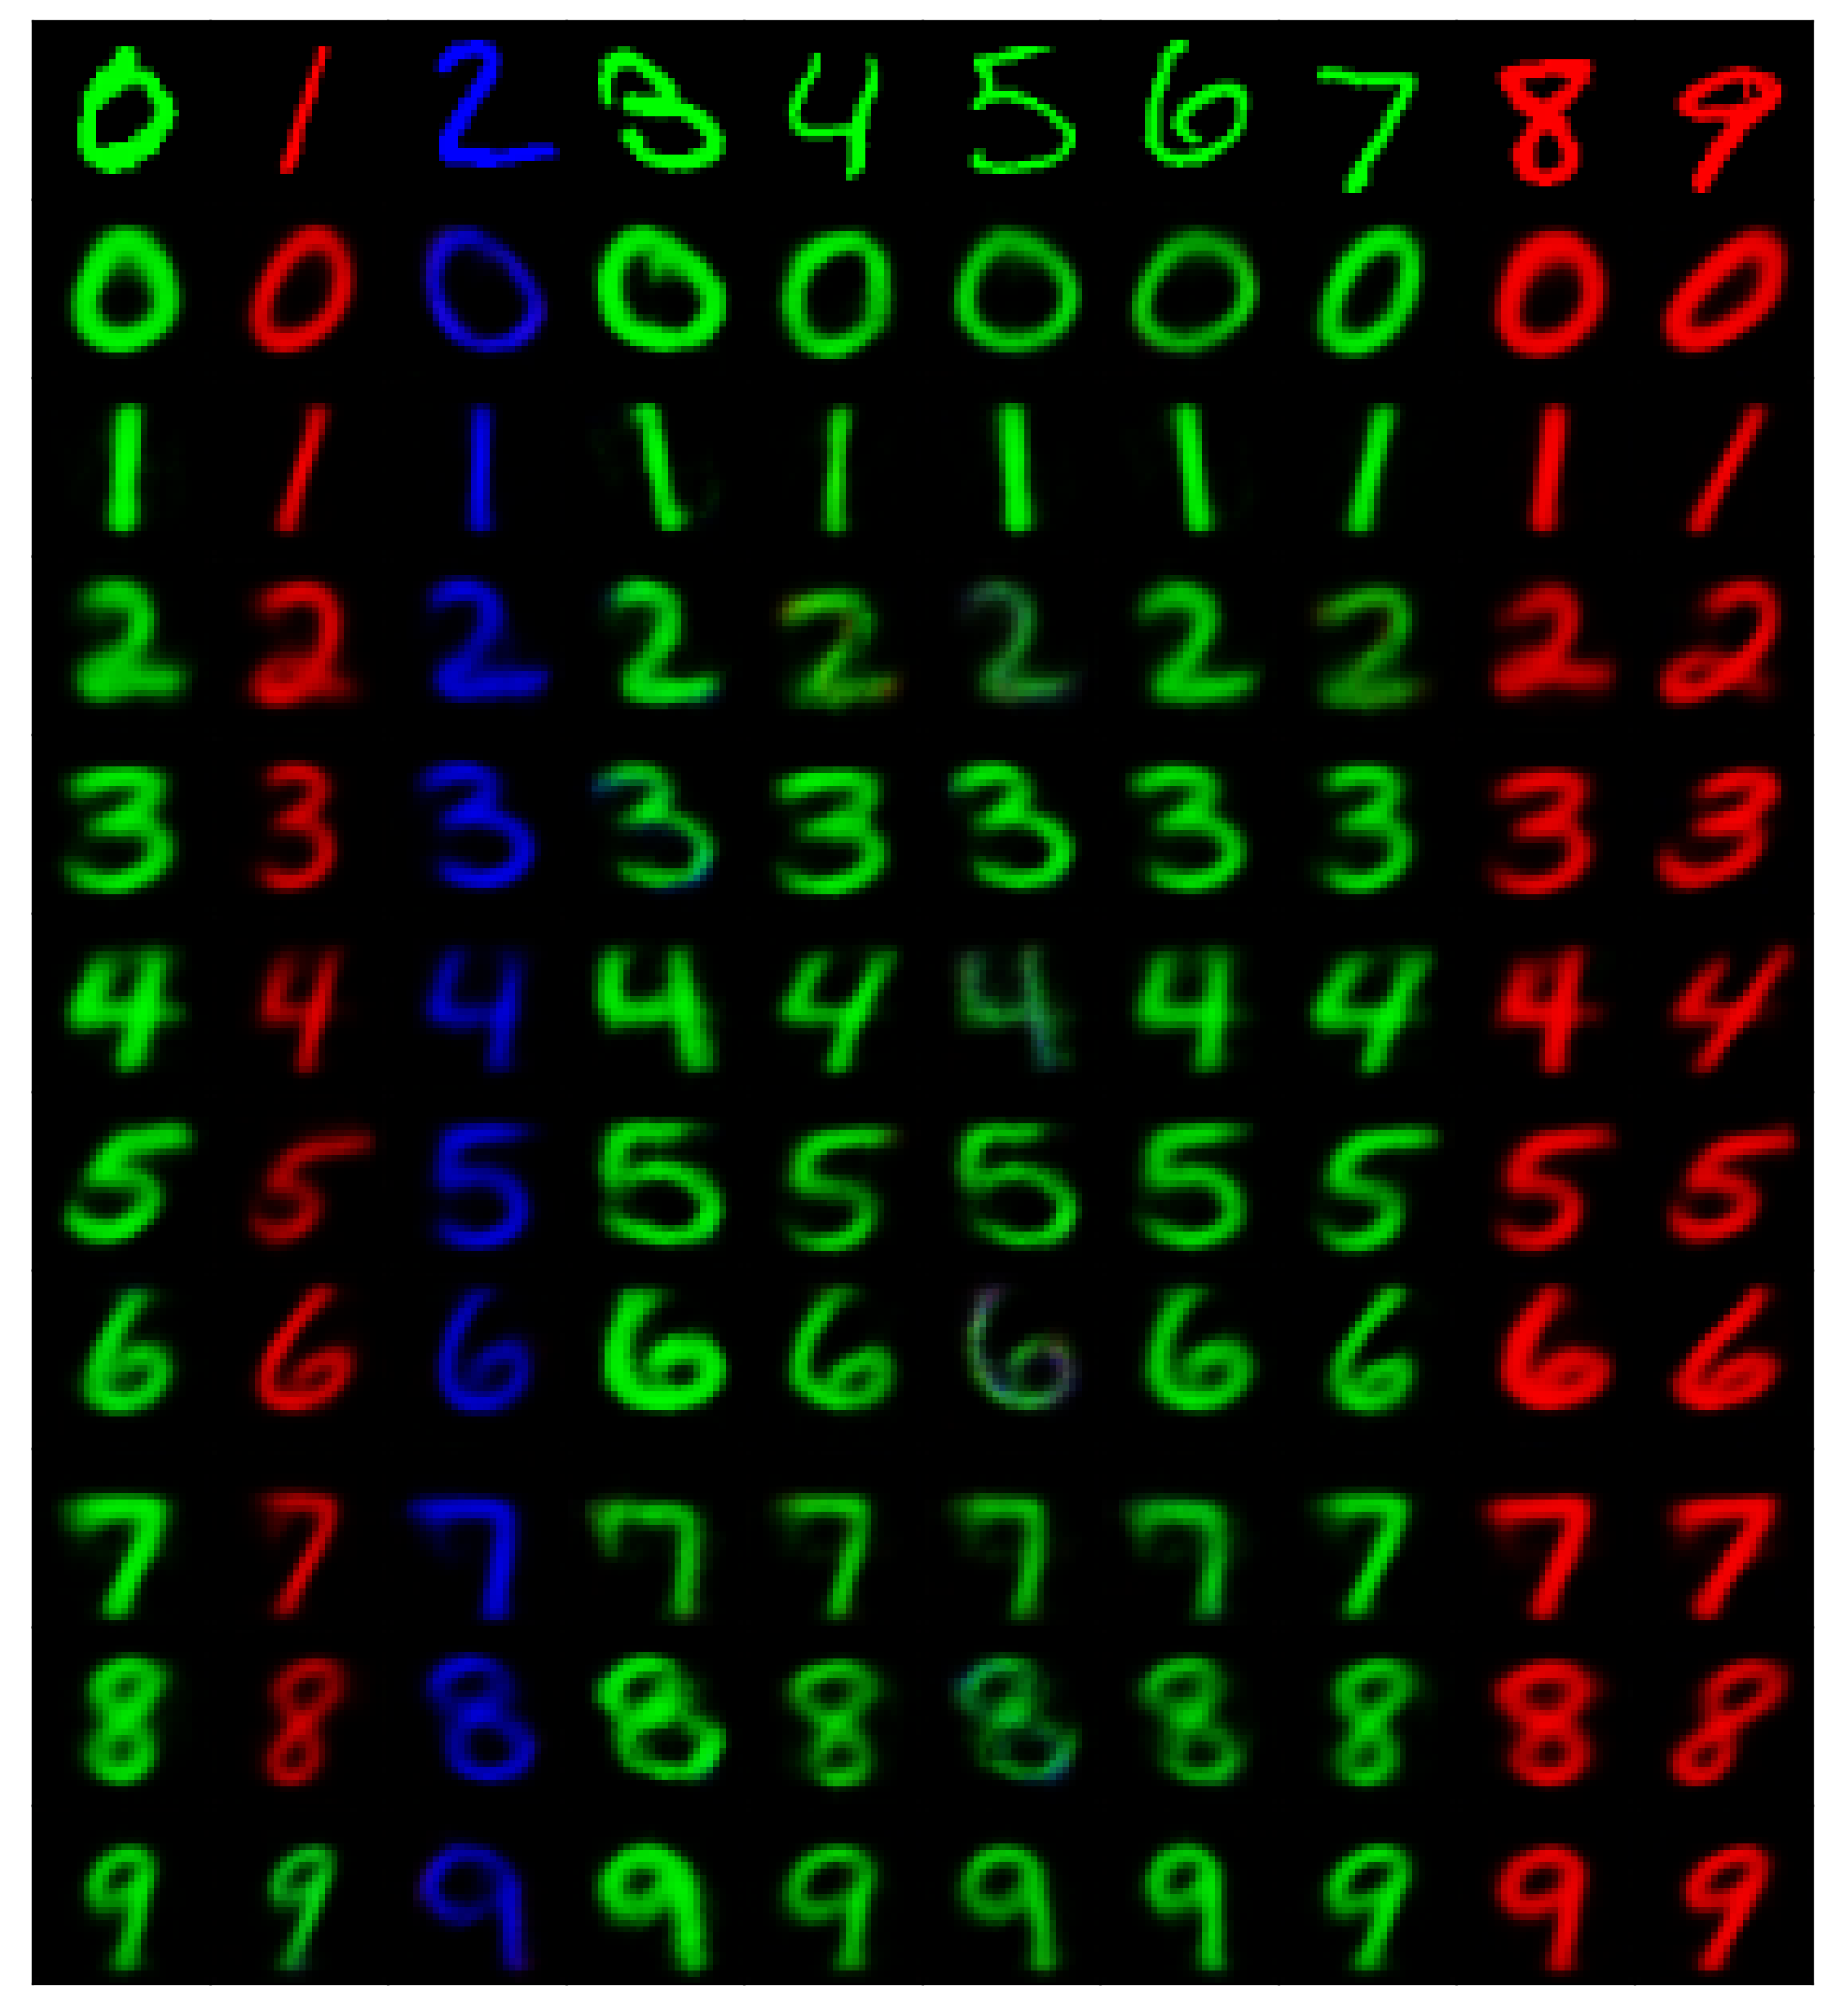

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.8_alpha_0.2_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:6.7099, u:0.0181, dz:0.1513, edz:-0.0688, prior:0.0000, du:0.1475, gdu:-0.0710
One epoch execution time: 6.52774 seconds
20, mse:6.6882, u:0.0162, dz:0.1394, edz:-0.0695, prior:0.0000, du:0.1435, gdu:-0.0693
One epoch execution time: 0.21816 seconds
40, mse:6.7272, u:0.0297, dz:0.1394, edz:-0.0699, prior:0.0000, du:0.1418, gdu:-0.0689
One epoch execution time: 0.23121 seconds
60, mse:6.6795, u:0.0223, dz:0.1385, edz:-0.0702, prior:0.0000, du:0.1407, gdu:-0.0694
One epoch execution time: 0.21398 seconds
80, mse:6.5423, u:0.0120, dz:0.1382, edz:-0.0699, prior:0.0000, du:0.1401, gdu:-0.0693
One epoch execution time: 0.20939 seconds
Total Execution Time: 0.4679 minutes
Evaluate performance U


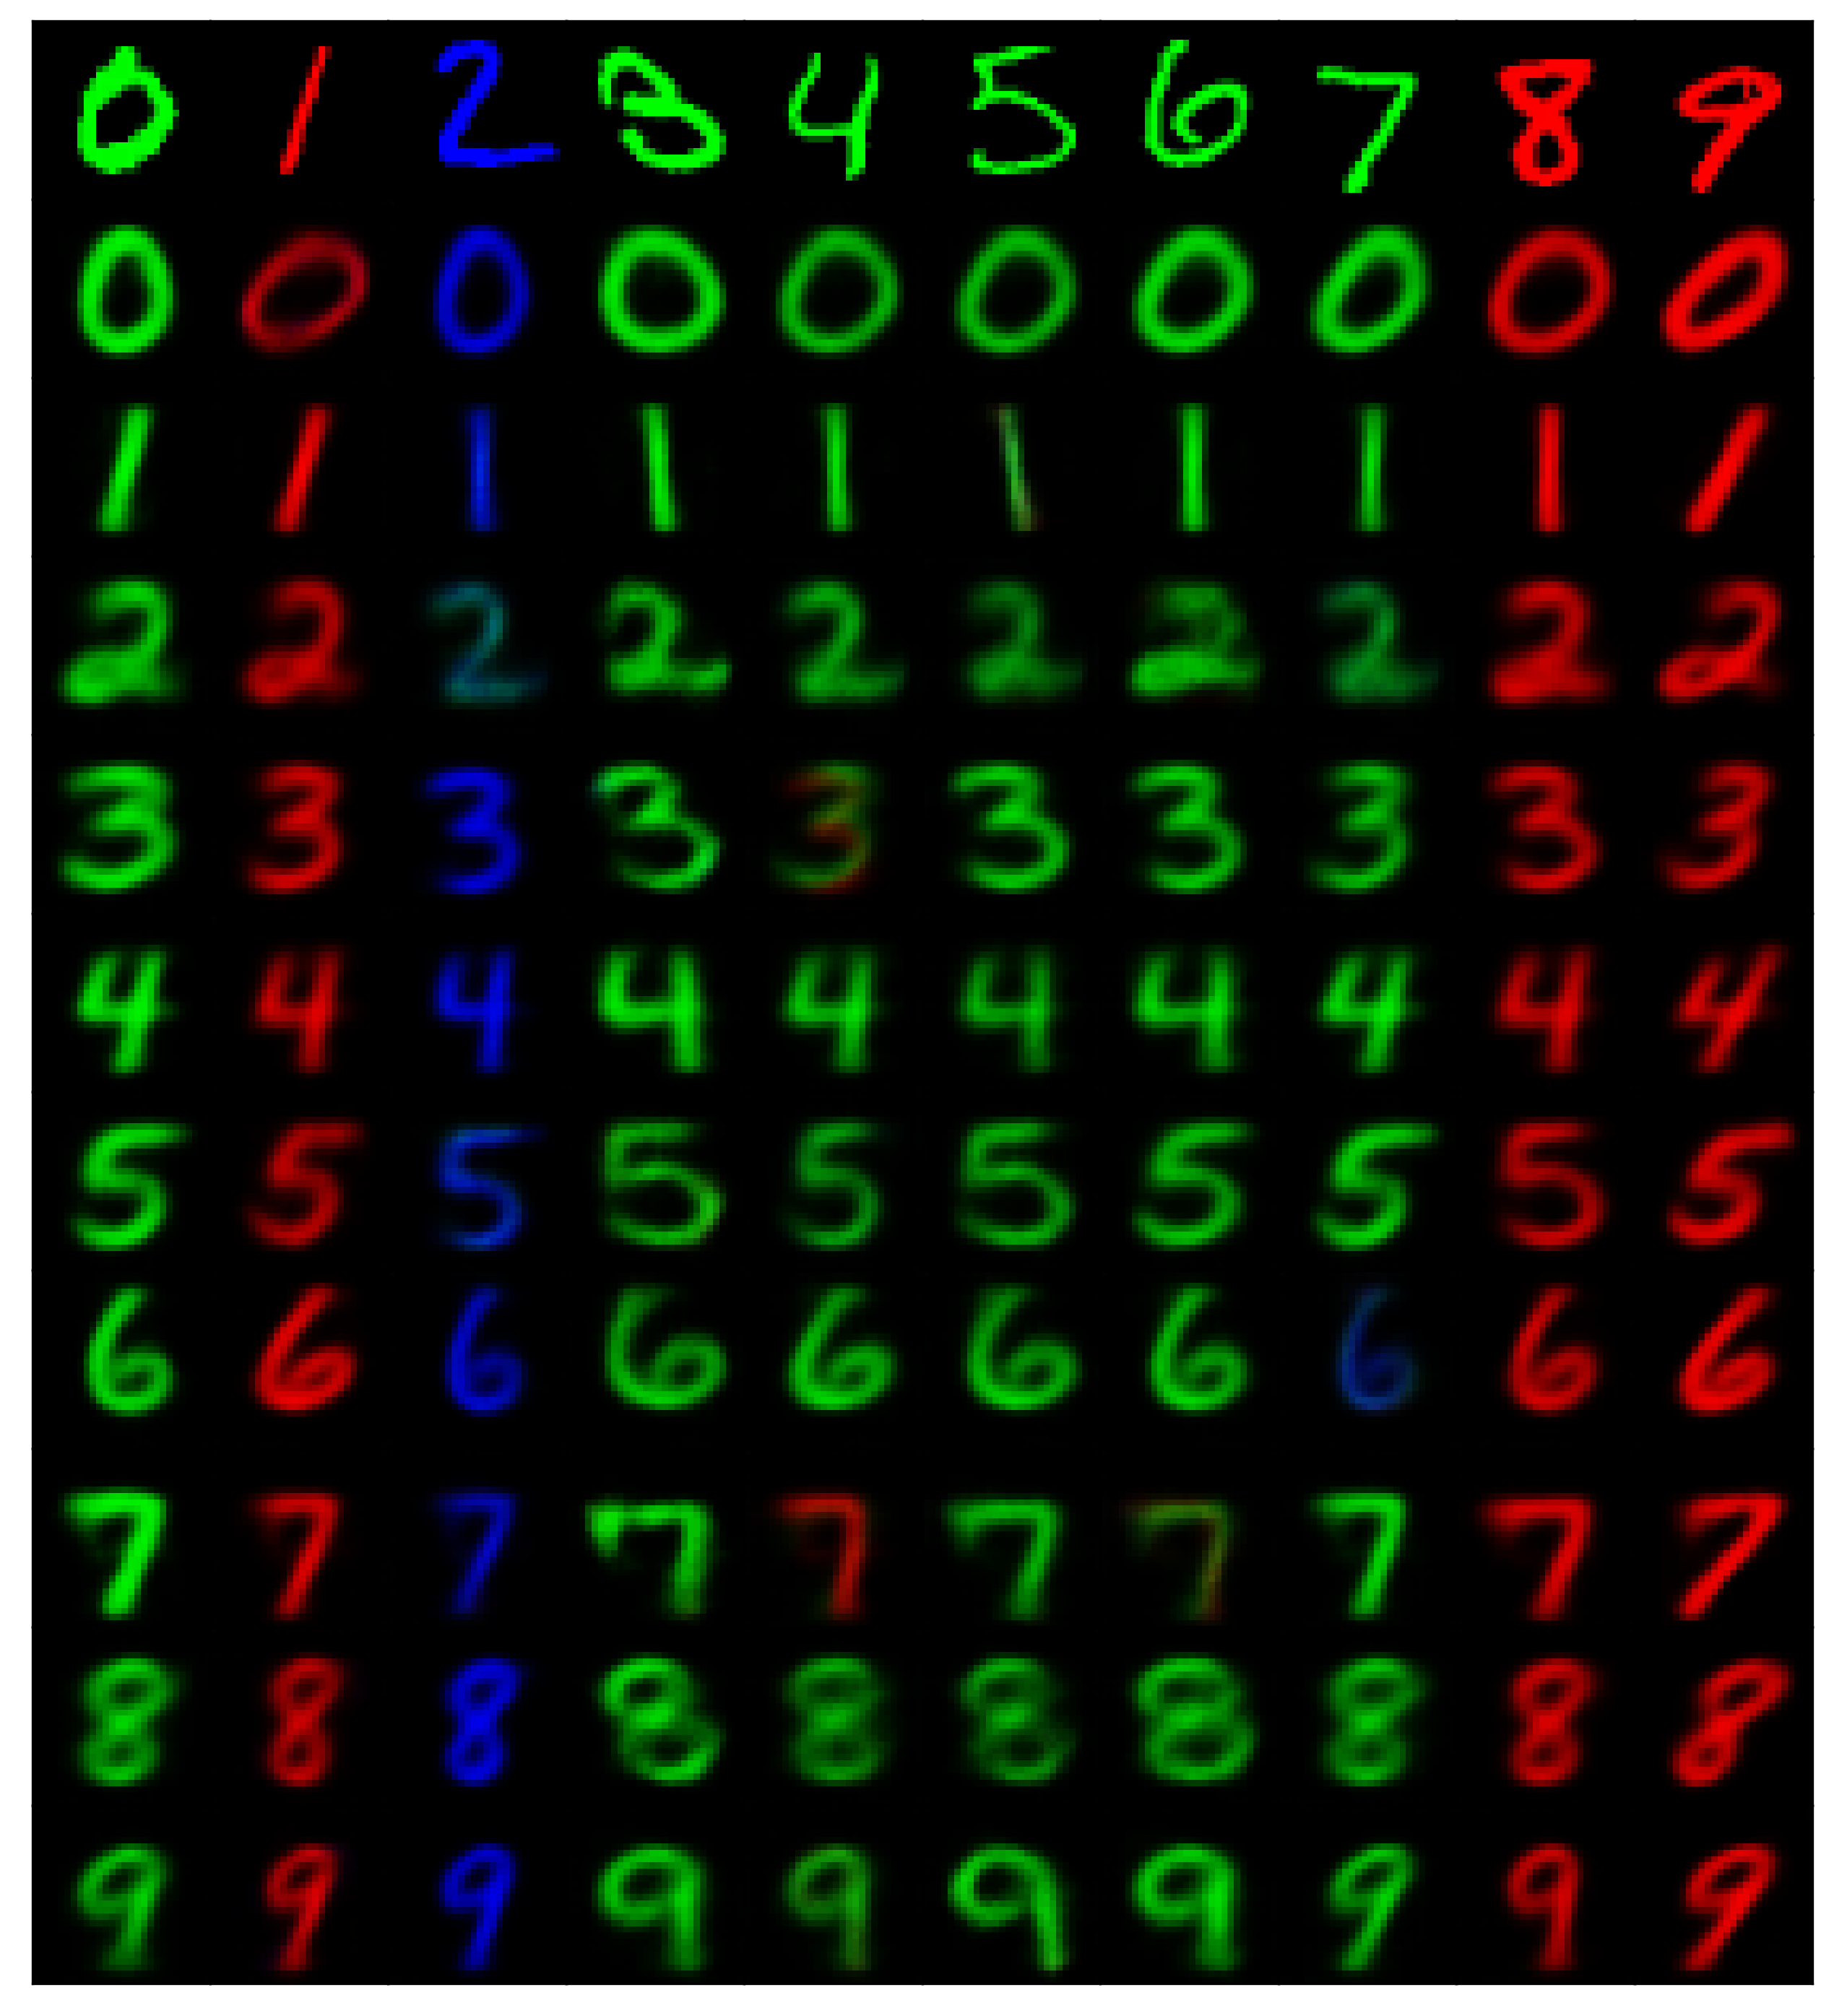

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.95_alpha_0.2_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:7.0563, u:0.0192, dz:0.1815, edz:-0.0808, prior:0.0000, du:0.1506, gdu:-0.0683
One epoch execution time: 6.25551 seconds
20, mse:7.1433, u:0.0160, dz:0.1645, edz:-0.0860, prior:0.0000, du:0.1436, gdu:-0.0674
One epoch execution time: 0.20759 seconds
40, mse:7.2223, u:0.0286, dz:0.1635, edz:-0.0887, prior:0.0000, du:0.1432, gdu:-0.0664
One epoch execution time: 0.21271 seconds
60, mse:6.9137, u:0.0172, dz:0.1625, edz:-0.0901, prior:0.0000, du:0.1418, gdu:-0.0667
One epoch execution time: 0.20180 seconds
80, mse:7.0450, u:0.0154, dz:0.1617, edz:-0.0906, prior:0.0000, du:0.1406, gdu:-0.0669
One epoch execution time: 0.28079 seconds
Total Execution Time: 0.4694 minutes
Evaluate performance U


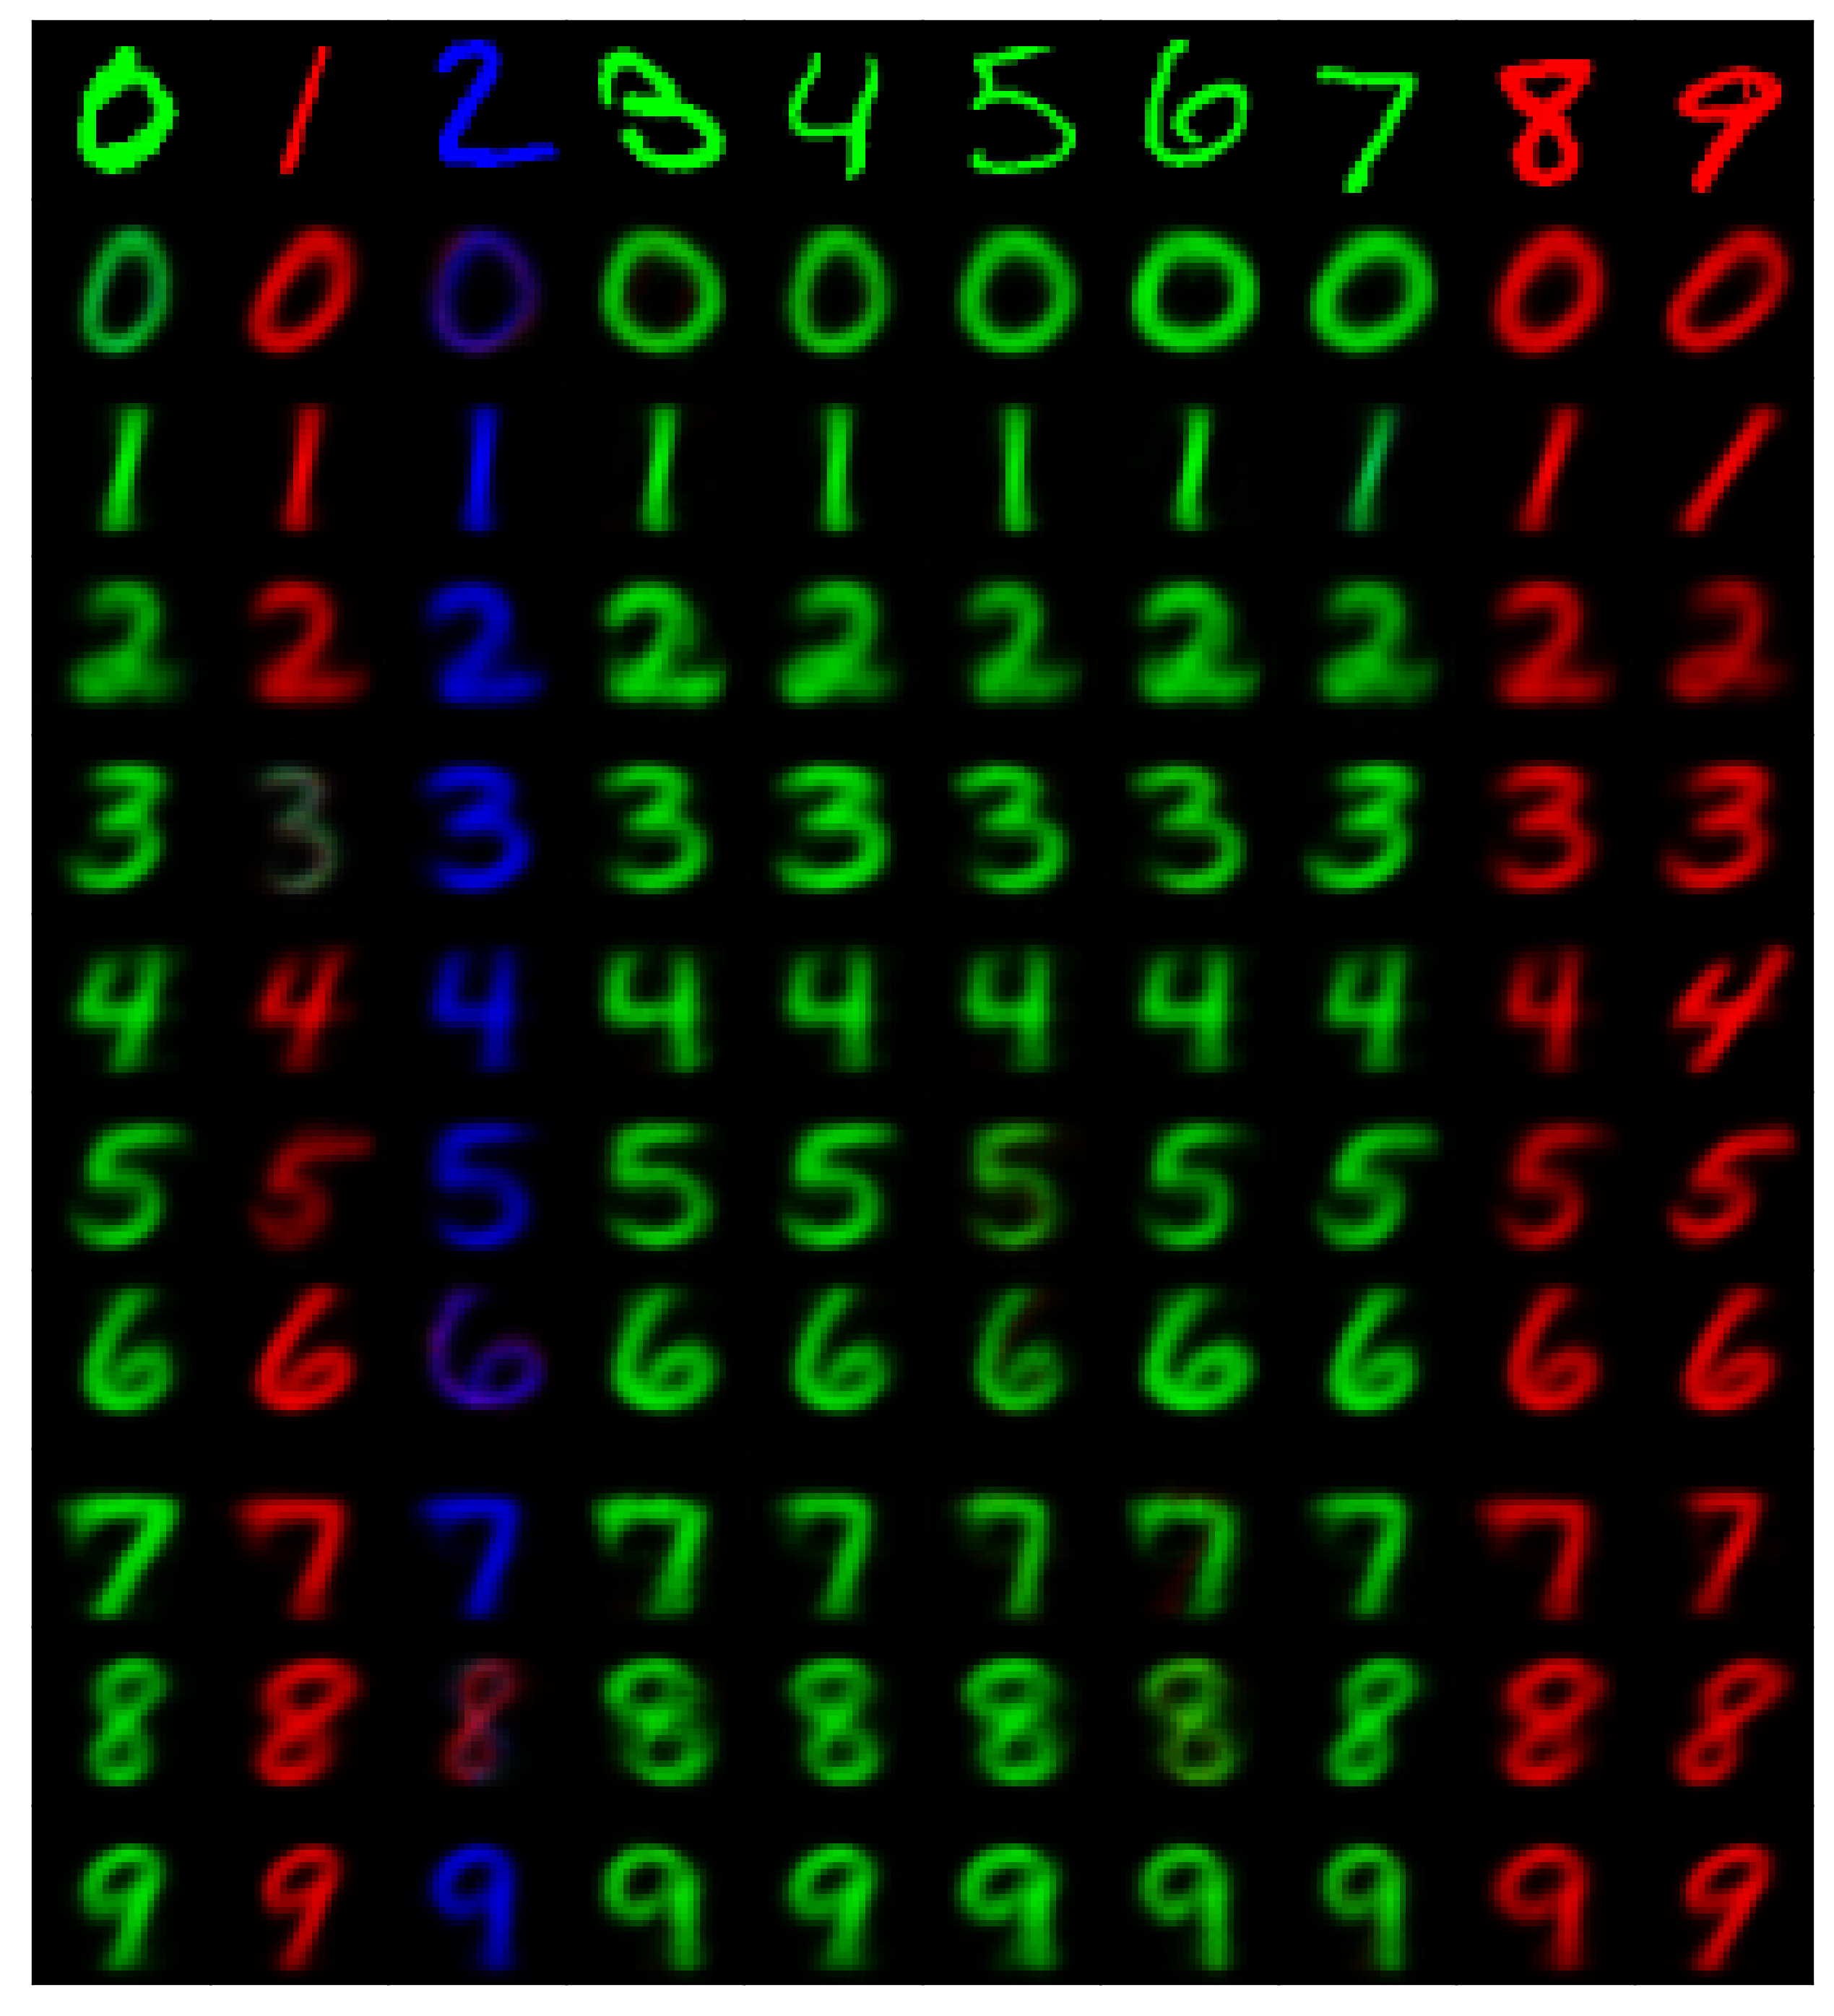

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.0001_alpha_0.7_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:11.2908, u:0.0021, dz:0.1072, edz:-0.0478, prior:0.0000, du:0.1944, gdu:-0.0740
One epoch execution time: 5.95691 seconds
20, mse:11.0811, u:0.0072, dz:0.0979, edz:-0.0513, prior:0.0000, du:0.1879, gdu:-0.0763
One epoch execution time: 0.20578 seconds
40, mse:11.2386, u:0.0011, dz:0.0972, edz:-0.0512, prior:0.0000, du:0.1791, gdu:-0.0814
One epoch execution time: 0.20442 seconds
60, mse:11.1526, u:0.0015, dz:0.0964, edz:-0.0518, prior:0.0000, du:0.1731, gdu:-0.0870
One epoch execution time: 0.24255 seconds
80, mse:11.1665, u:0.0037, dz:0.0959, edz:-0.0520, prior:0.0000, du:0.1621, gdu:-0.0898
One epoch execution time: 0.22896 seconds
Total Execution Time: 0.4569 minutes
Evaluate performance U


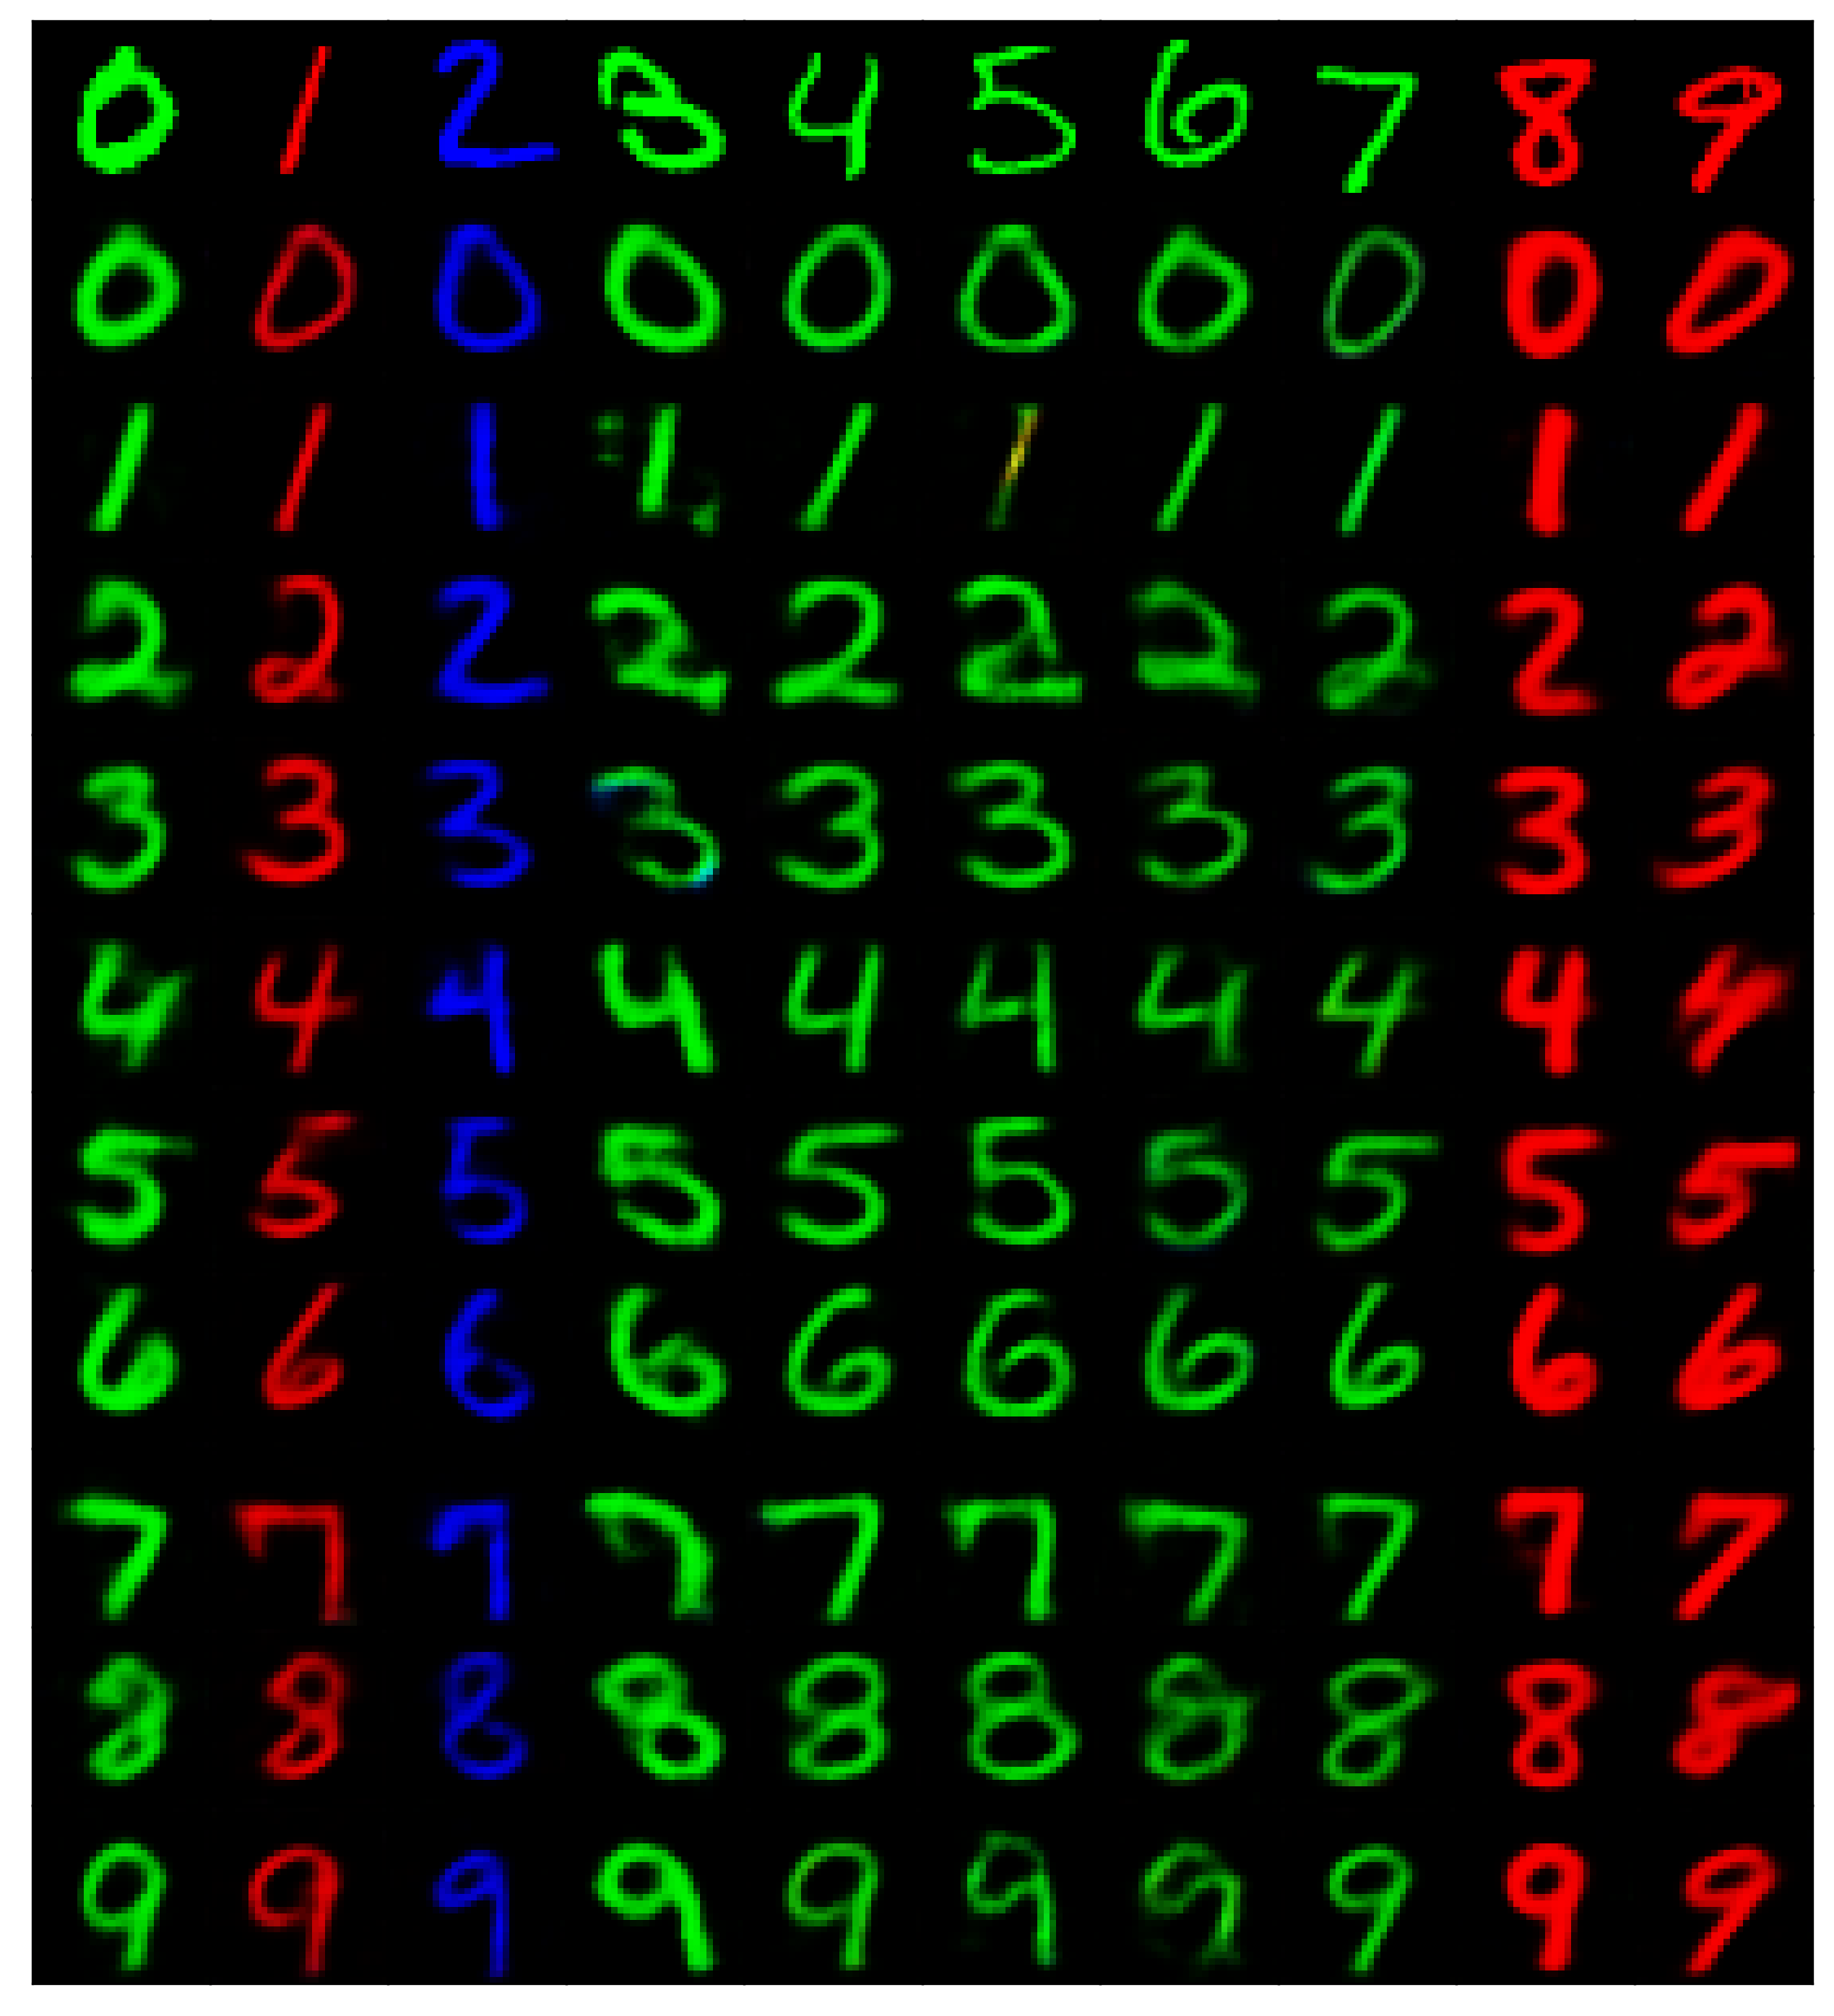

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.1_alpha_0.7_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:12.1856, u:0.0026, dz:0.1292, edz:-0.0544, prior:0.0000, du:0.1719, gdu:-0.0654
One epoch execution time: 6.38411 seconds
20, mse:12.0924, u:0.0027, dz:0.1127, edz:-0.0533, prior:0.0000, du:0.1677, gdu:-0.0658
One epoch execution time: 0.21305 seconds
40, mse:11.7935, u:0.0015, dz:0.1117, edz:-0.0523, prior:0.0000, du:0.1644, gdu:-0.0658
One epoch execution time: 0.22021 seconds
60, mse:12.1808, u:0.0022, dz:0.1113, edz:-0.0517, prior:0.0000, du:0.1621, gdu:-0.0664
One epoch execution time: 0.22391 seconds
80, mse:11.9682, u:0.0028, dz:0.1109, edz:-0.0517, prior:0.0000, du:0.1594, gdu:-0.0666
One epoch execution time: 0.22380 seconds
Total Execution Time: 0.4710 minutes
Evaluate performance U


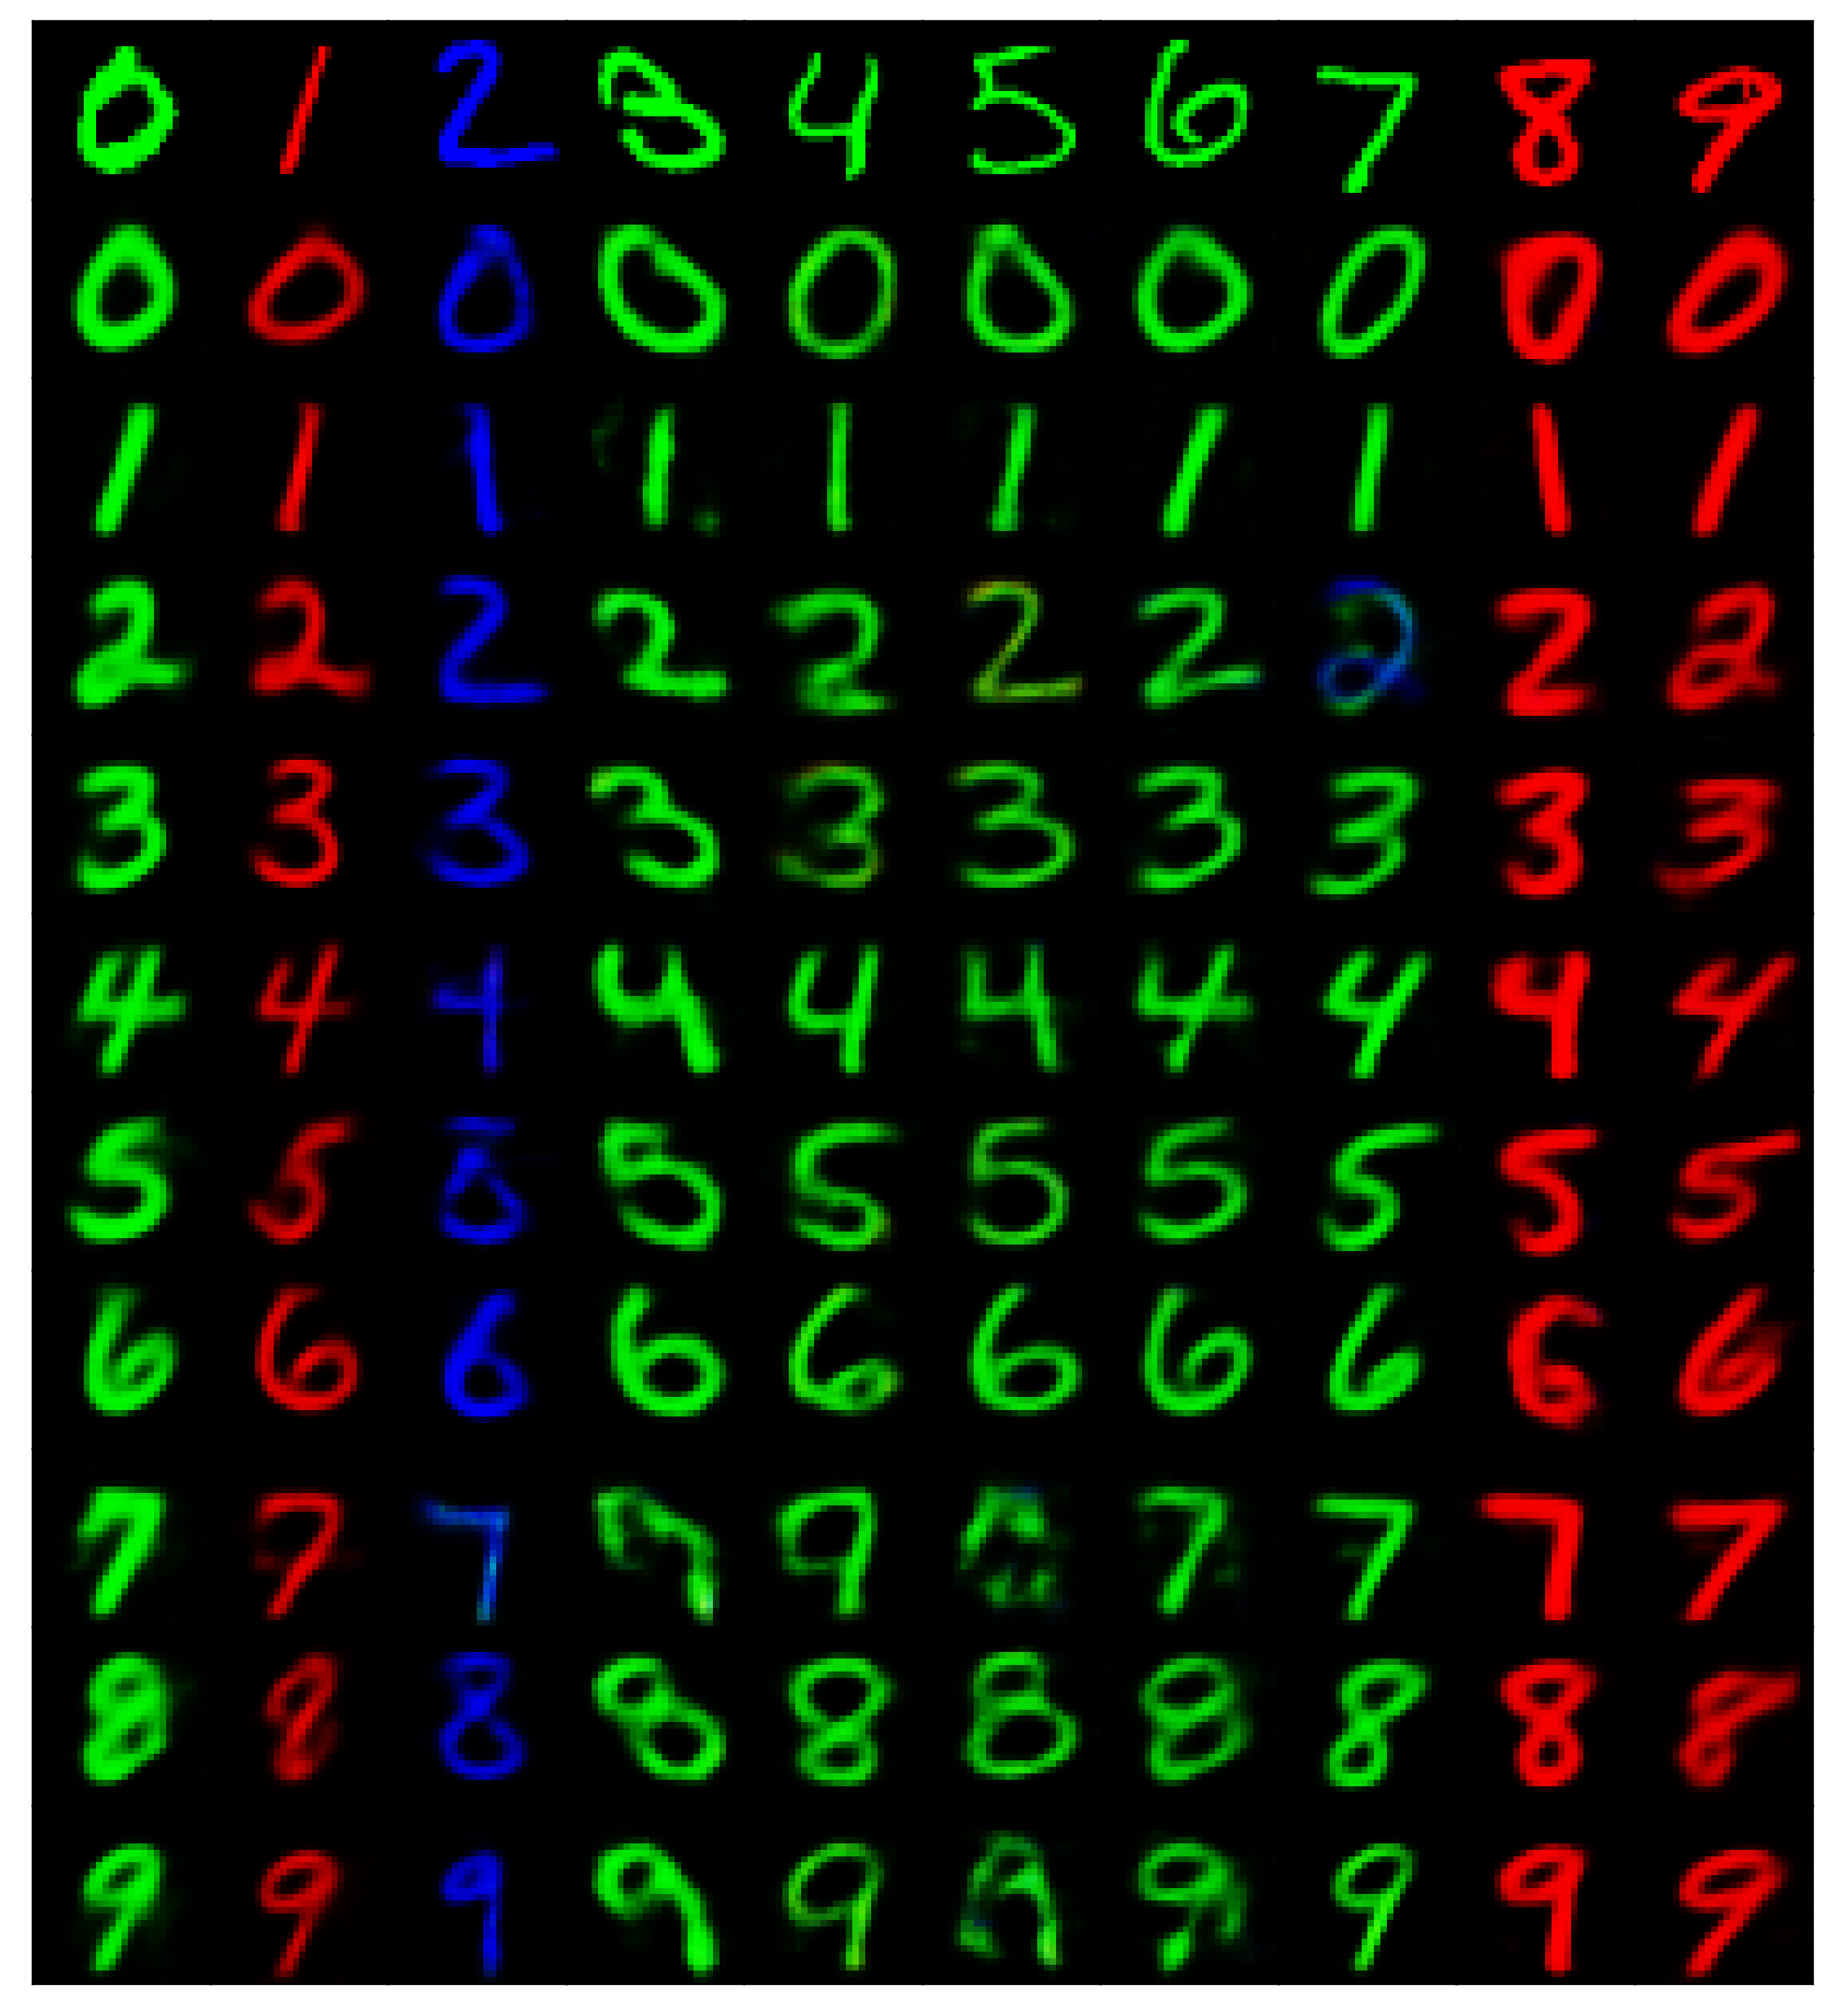

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.3_alpha_0.7_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:13.3580, u:0.0035, dz:0.1671, edz:-0.0711, prior:0.0000, du:0.1485, gdu:-0.0778
One epoch execution time: 5.82643 seconds
20, mse:13.5273, u:0.0043, dz:0.1469, edz:-0.0744, prior:0.0000, du:0.1470, gdu:-0.0720
One epoch execution time: 0.20704 seconds
40, mse:13.2126, u:0.0020, dz:0.1444, edz:-0.0794, prior:0.0000, du:0.1465, gdu:-0.0704
One epoch execution time: 0.21795 seconds
60, mse:13.1569, u:0.0020, dz:0.1421, edz:-0.0824, prior:0.0000, du:0.1460, gdu:-0.0695
One epoch execution time: 0.22541 seconds
80, mse:13.2202, u:0.0016, dz:0.1409, edz:-0.0837, prior:0.0000, du:0.1442, gdu:-0.0699
One epoch execution time: 0.21852 seconds
Total Execution Time: 0.4743 minutes
Evaluate performance U


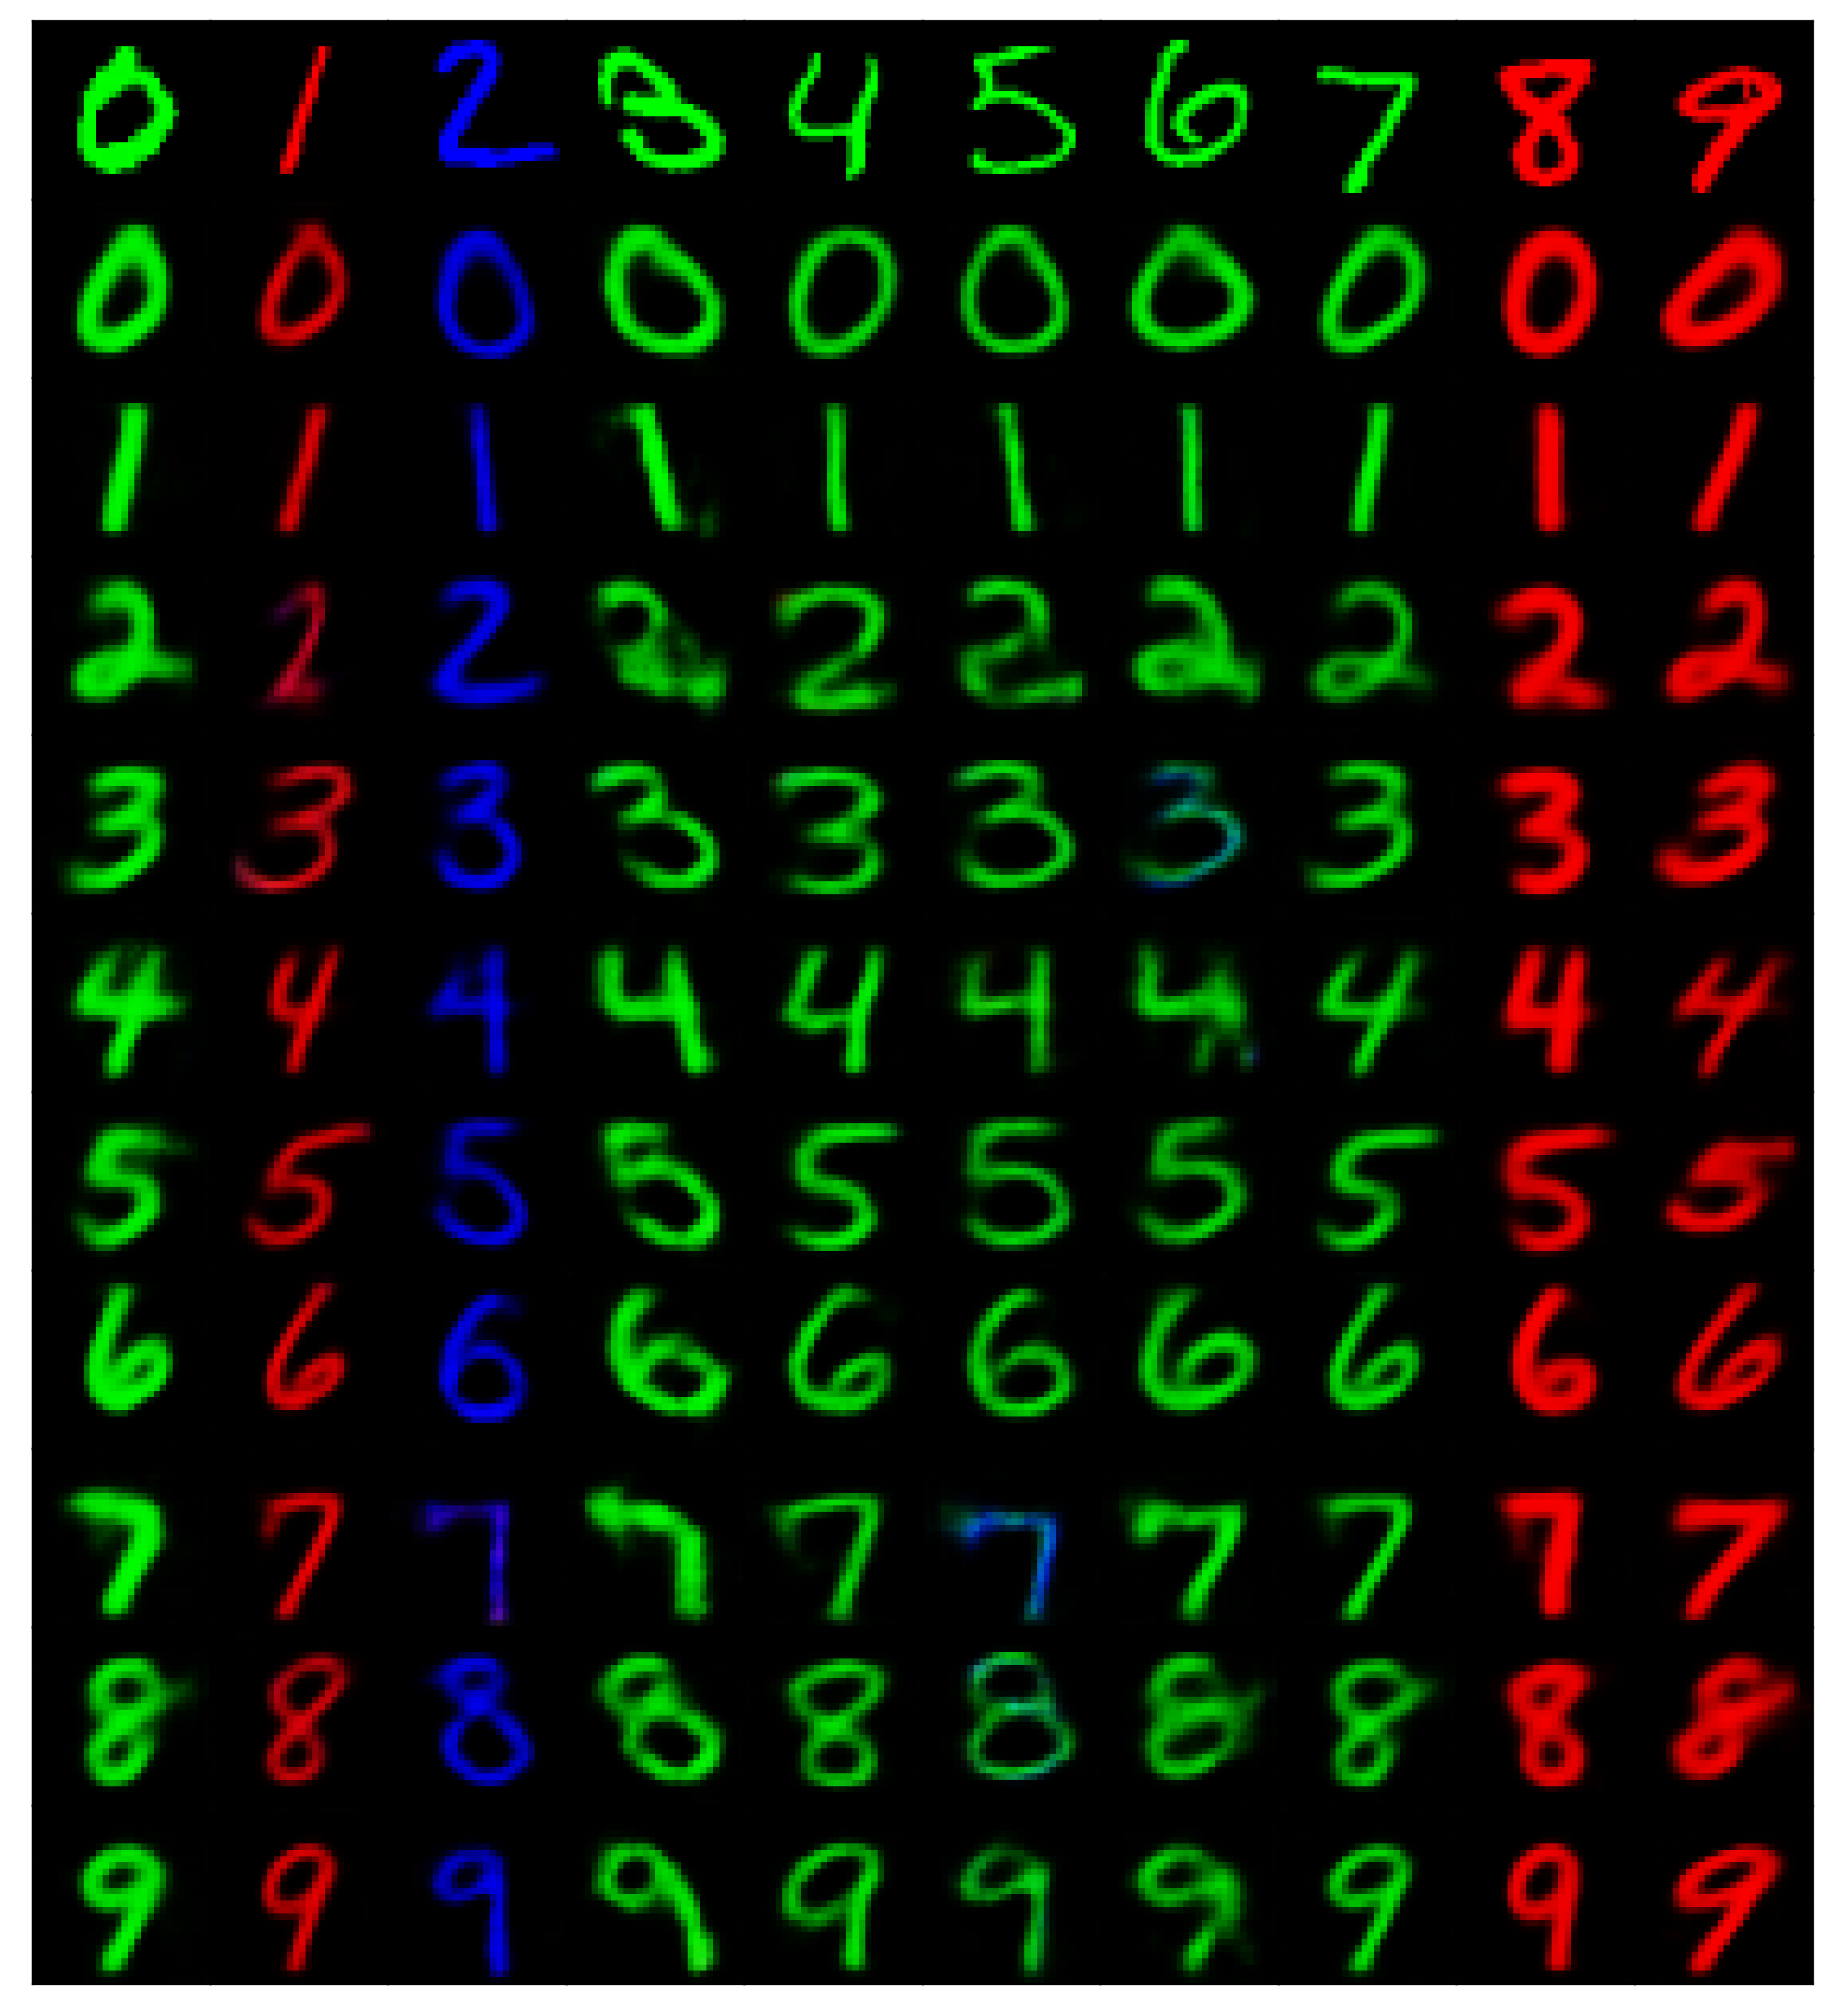

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.5_alpha_0.7_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:14.5357, u:0.0045, dz:0.2094, edz:-0.0947, prior:0.0000, du:0.1417, gdu:-0.0639
One epoch execution time: 6.50301 seconds
20, mse:14.4190, u:0.0069, dz:0.1783, edz:-0.0847, prior:0.0000, du:0.1408, gdu:-0.0638
One epoch execution time: 0.19863 seconds
40, mse:14.4755, u:0.0066, dz:0.1759, edz:-0.0952, prior:0.0000, du:0.1407, gdu:-0.0638
One epoch execution time: 0.21980 seconds
60, mse:14.6862, u:0.0038, dz:0.1728, edz:-0.1013, prior:0.0000, du:0.1411, gdu:-0.0638
One epoch execution time: 0.20623 seconds
80, mse:14.5749, u:0.0094, dz:0.1700, edz:-0.1037, prior:0.0000, du:0.1398, gdu:-0.0634
One epoch execution time: 0.21391 seconds
Total Execution Time: 0.4619 minutes
Evaluate performance U


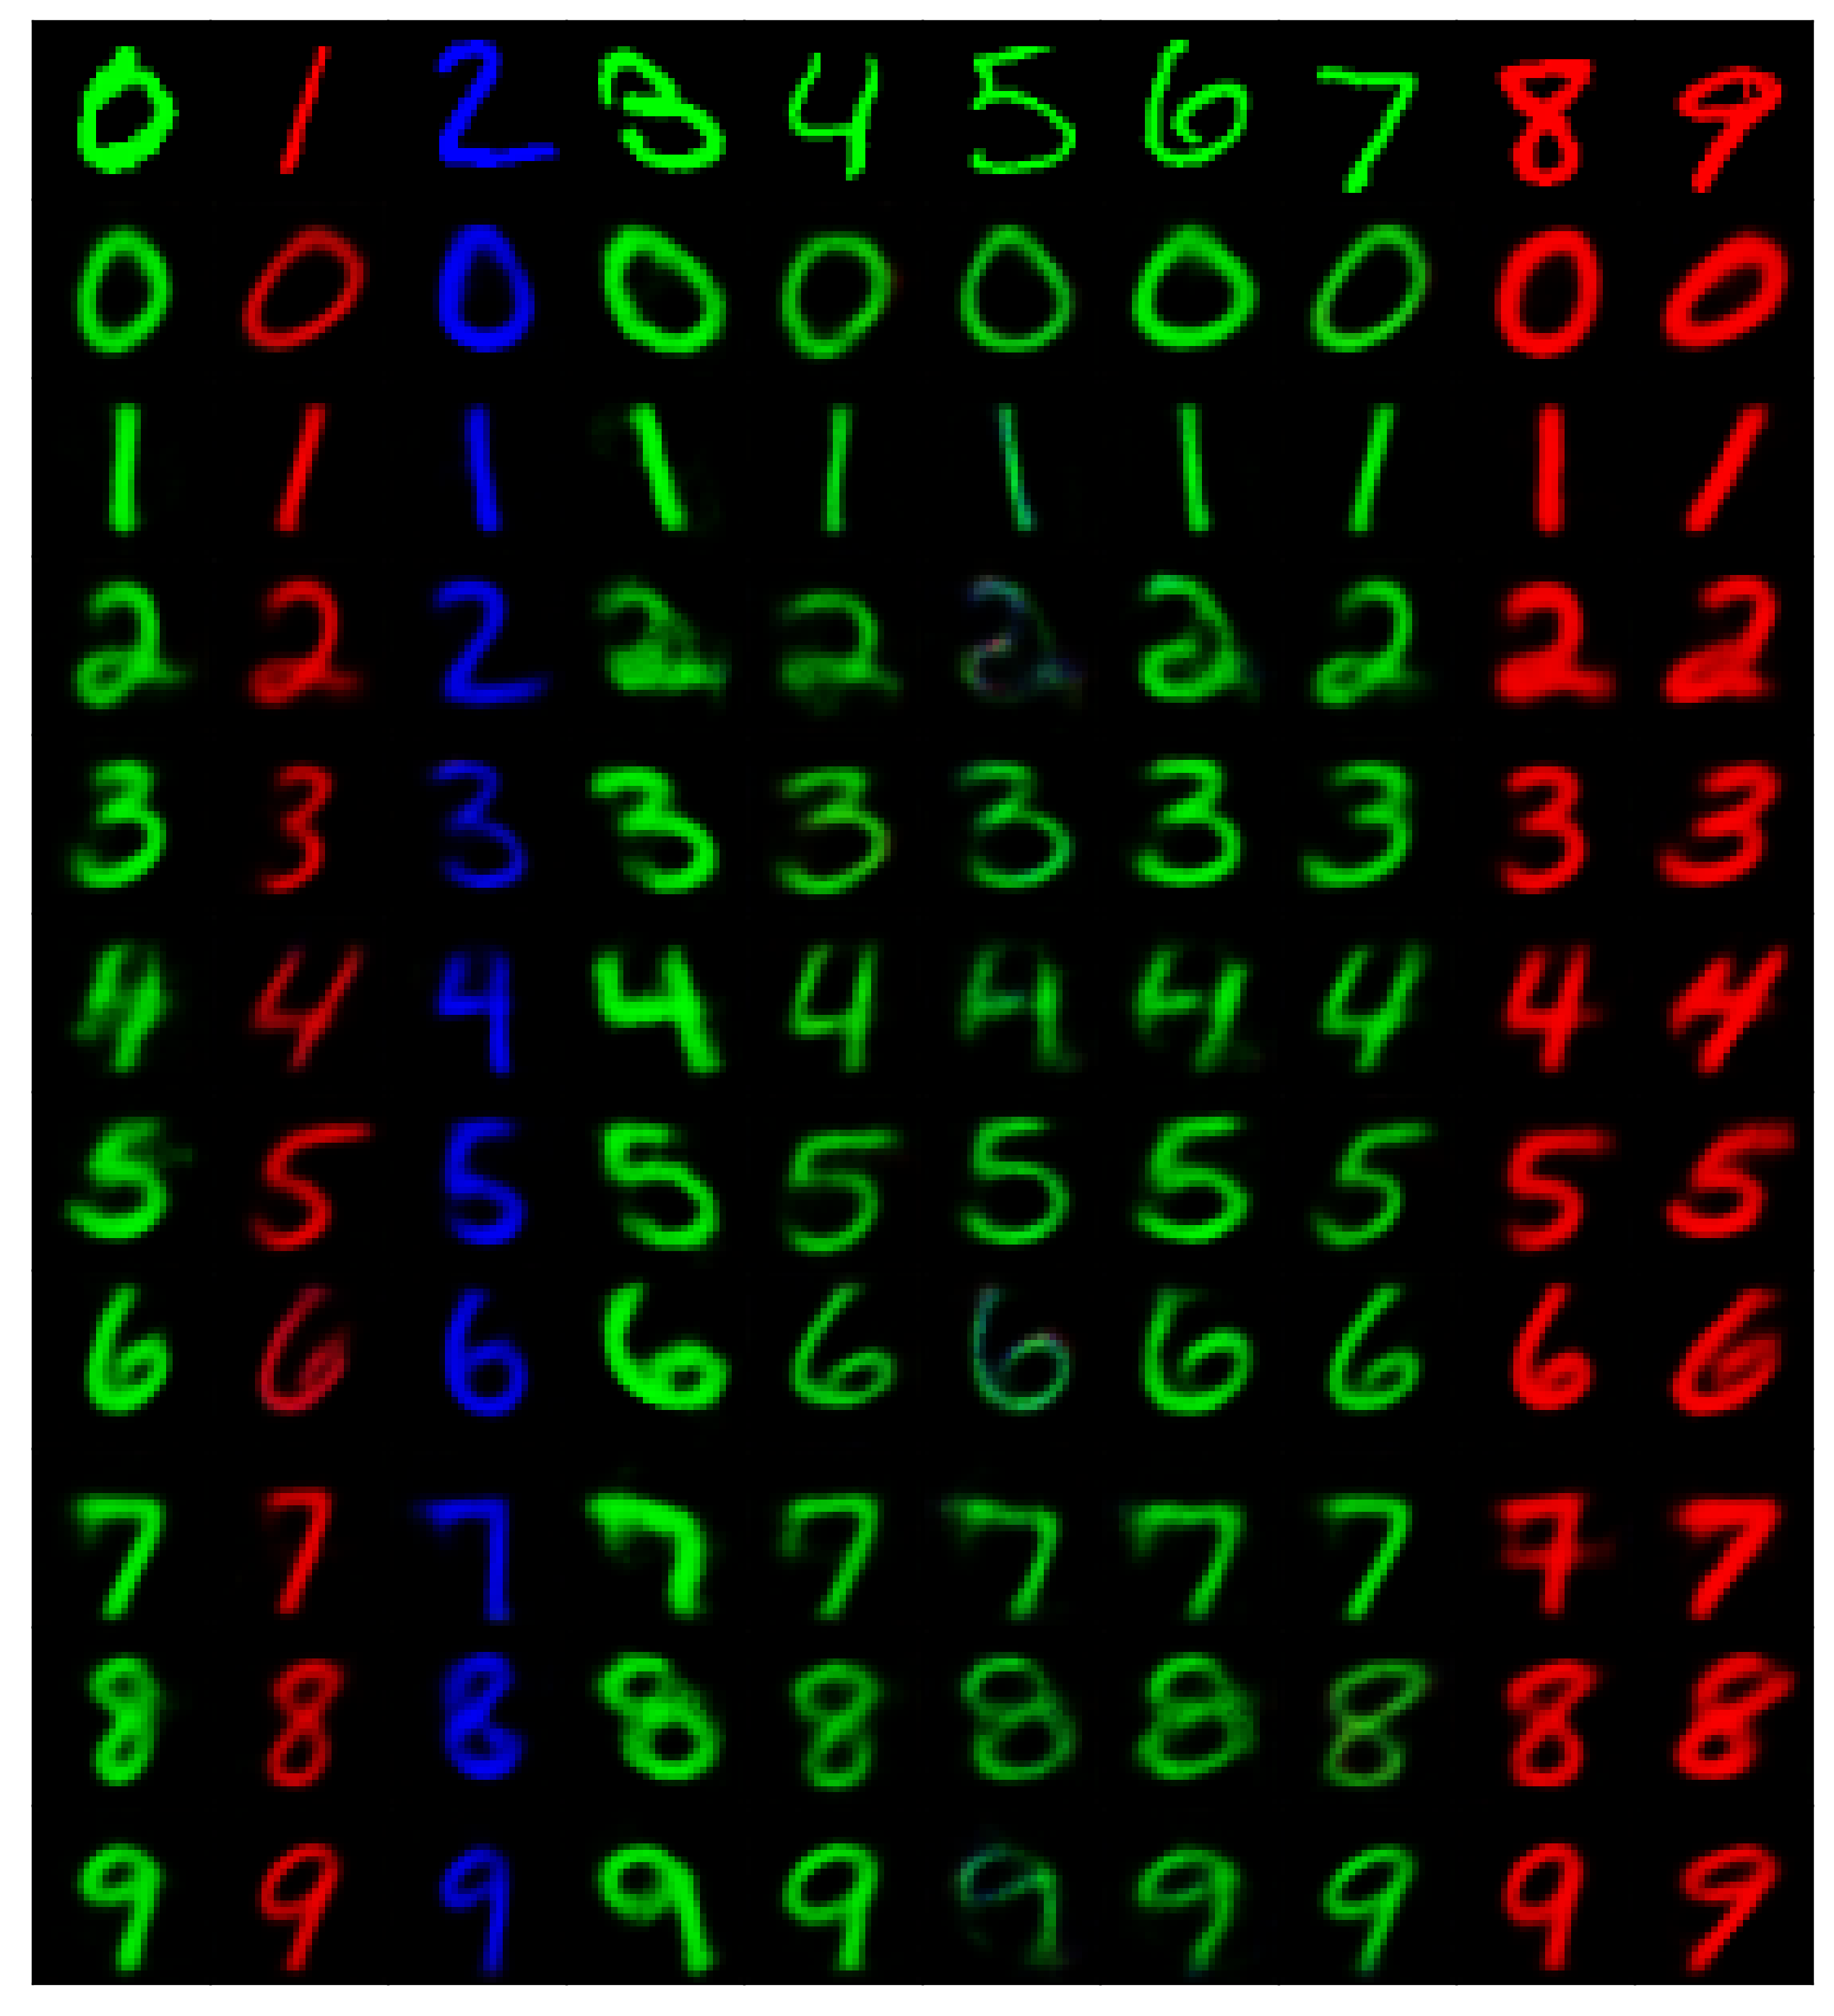

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.8_alpha_0.7_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:16.0079, u:0.0066, dz:0.2311, edz:-0.1049, prior:0.0000, du:0.1507, gdu:-0.0750
One epoch execution time: 6.42860 seconds
20, mse:16.0587, u:0.0035, dz:0.2099, edz:-0.1070, prior:0.0000, du:0.1475, gdu:-0.0701
One epoch execution time: 0.22729 seconds
40, mse:16.4244, u:0.0071, dz:0.2090, edz:-0.1092, prior:0.0000, du:0.1453, gdu:-0.0700
One epoch execution time: 0.21651 seconds
60, mse:16.6786, u:0.0120, dz:0.2078, edz:-0.1108, prior:0.0000, du:0.1411, gdu:-0.0715
One epoch execution time: 0.21442 seconds
80, mse:16.2432, u:0.0118, dz:0.2079, edz:-0.1111, prior:0.0000, du:0.1432, gdu:-0.0730
One epoch execution time: 0.21821 seconds
Total Execution Time: 0.4675 minutes
Evaluate performance U


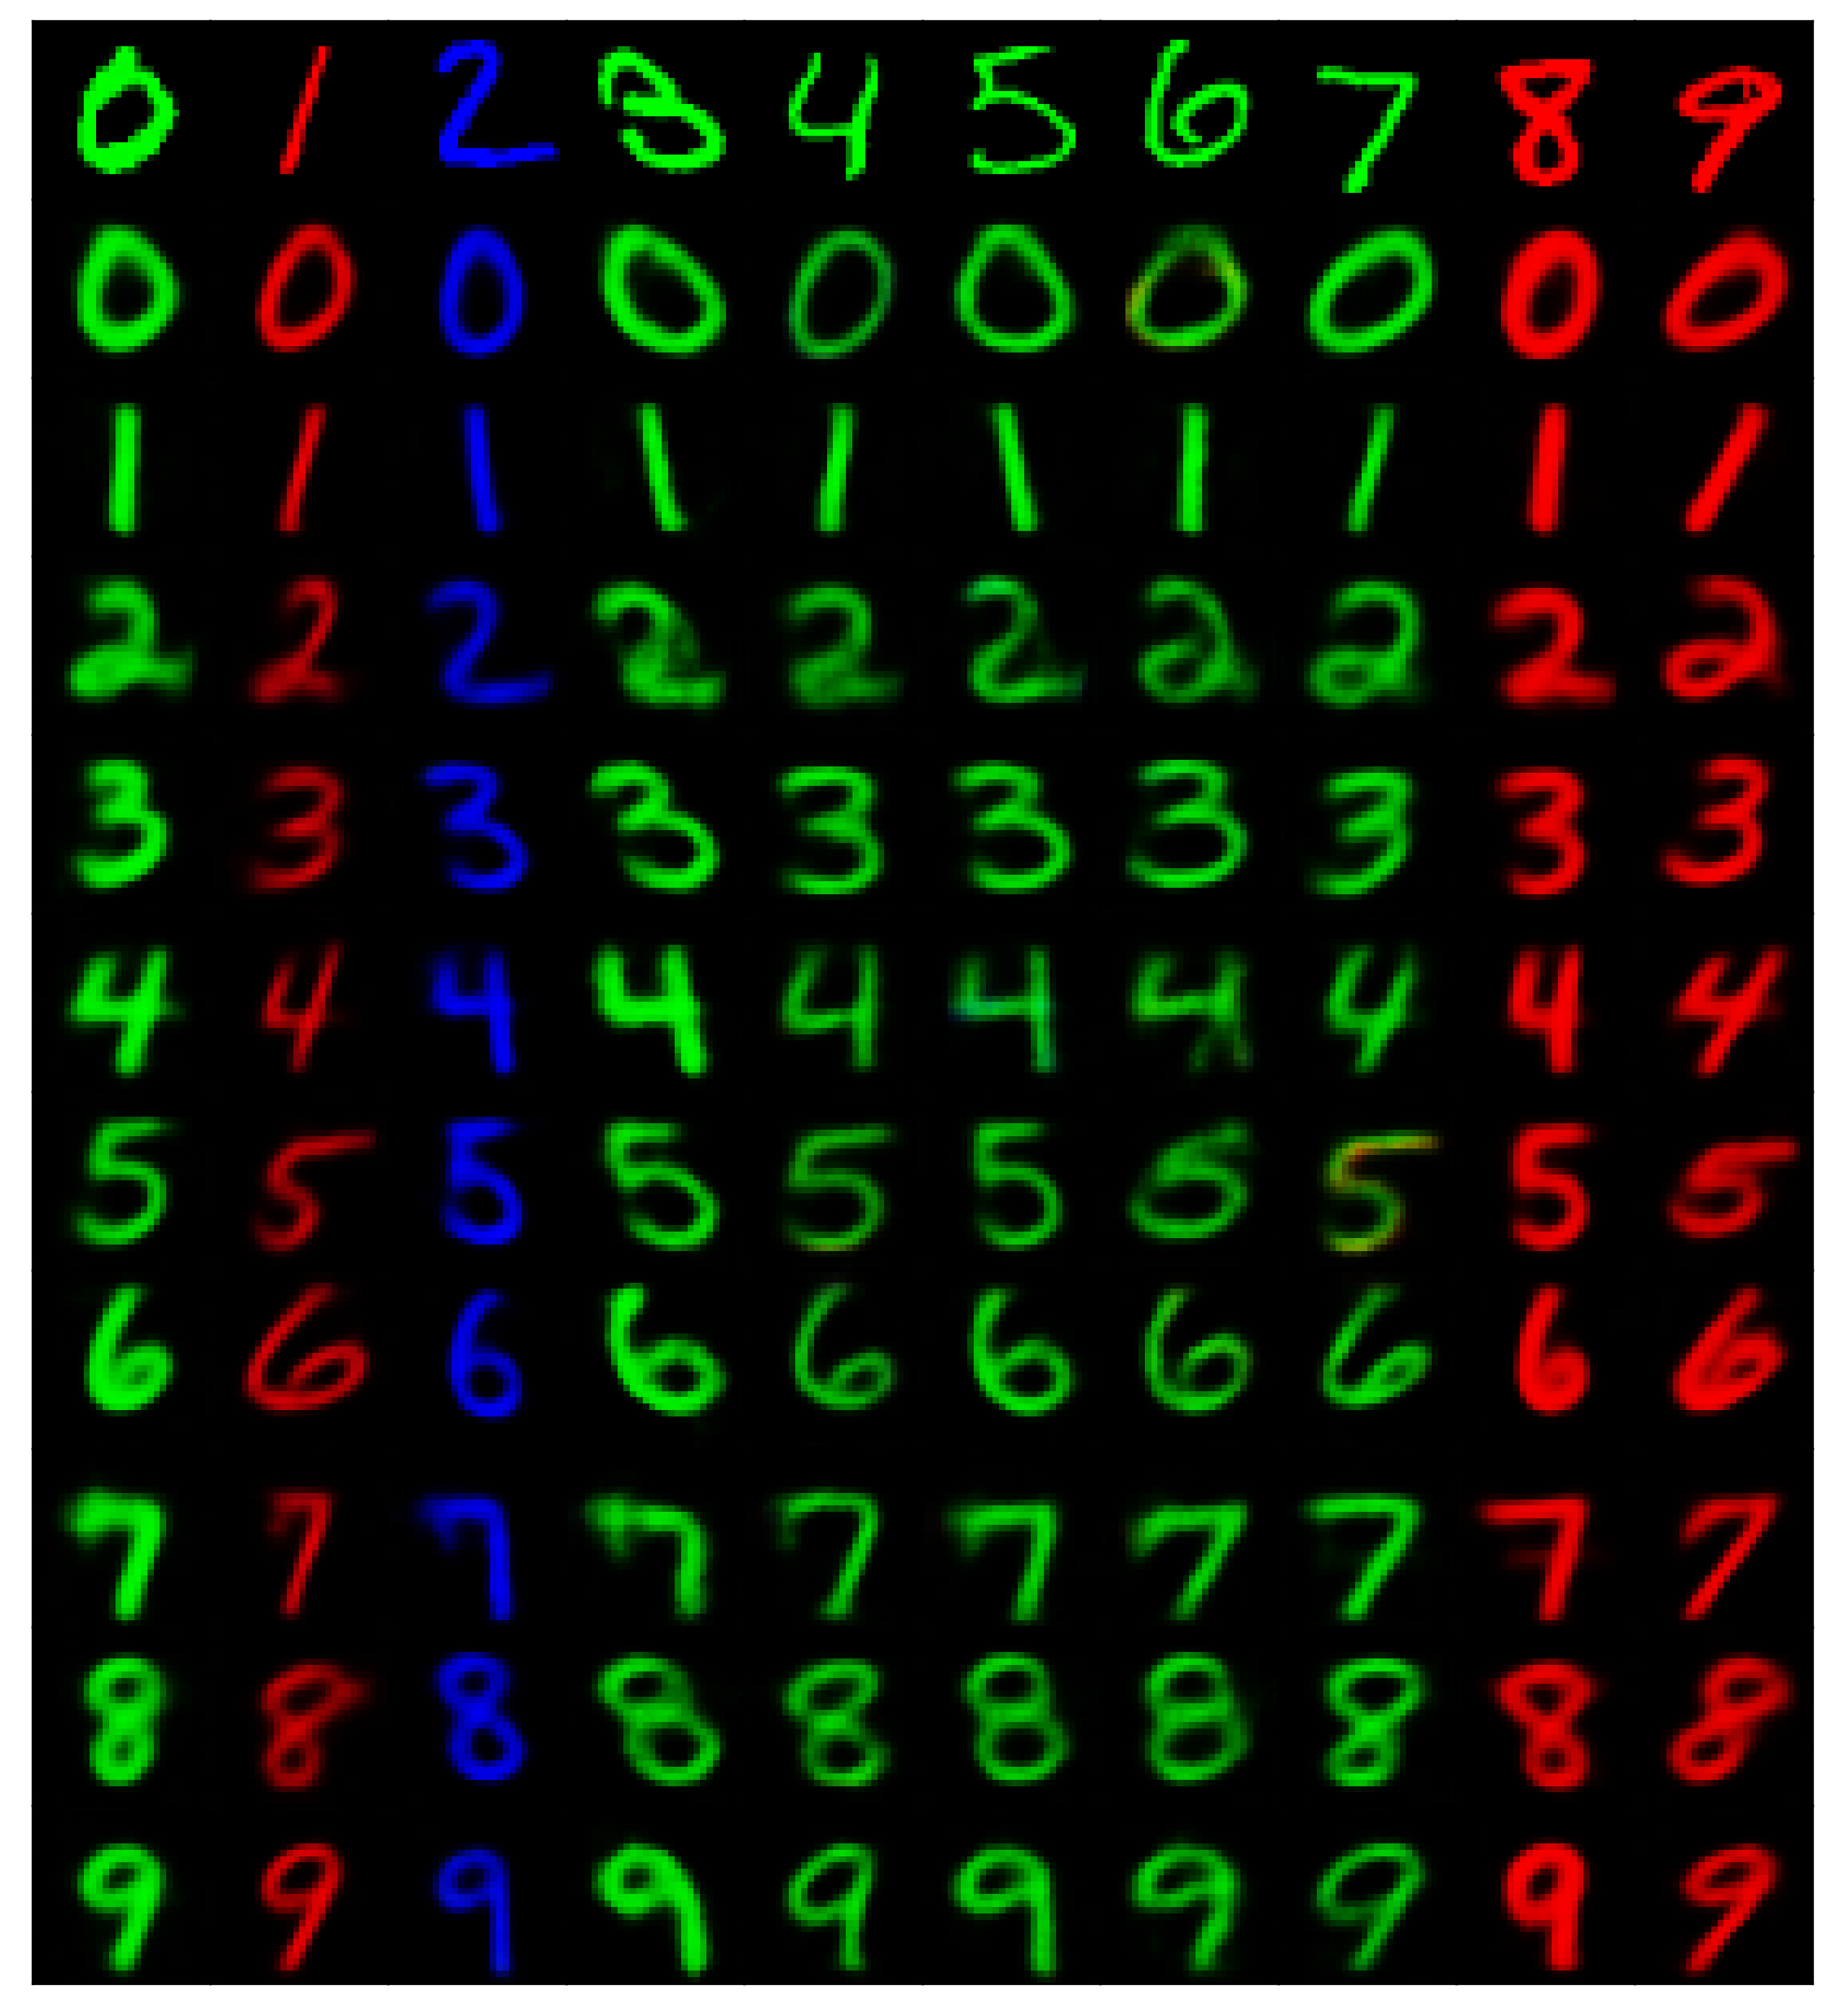

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)
Evaluate Mutual Information I(S,Z)
Pre-Training with d_8_beta_0.95_alpha_0.7_s_class_u_color_Isotropic_biased_supervised_P1
Full model training
0, mse:16.9996, u:0.0076, dz:0.2819, edz:-0.1196, prior:0.0000, du:0.1460, gdu:-0.0797
One epoch execution time: 5.45362 seconds
20, mse:16.9615, u:0.0083, dz:0.2421, edz:-0.1300, prior:0.0000, du:0.1420, gdu:-0.0727
One epoch execution time: 0.19893 seconds
40, mse:16.7592, u:0.0065, dz:0.2379, edz:-0.1410, prior:0.0000, du:0.1408, gdu:-0.0683
One epoch execution time: 0.19520 seconds
60, mse:16.7219, u:0.0052, dz:0.2354, edz:-0.1474, prior:0.0000, du:0.1395, gdu:-0.0659
One epoch execution time: 0.21593 seconds
80, mse:17.1166, u:0.0124, dz:0.2329, edz:-0.1499, prior:0.0000, du:0.1384, gdu:-0.0648
One epoch execution time: 0.19249 seconds
Total Execution Time: 0.4255 minutes
Evaluate performance U


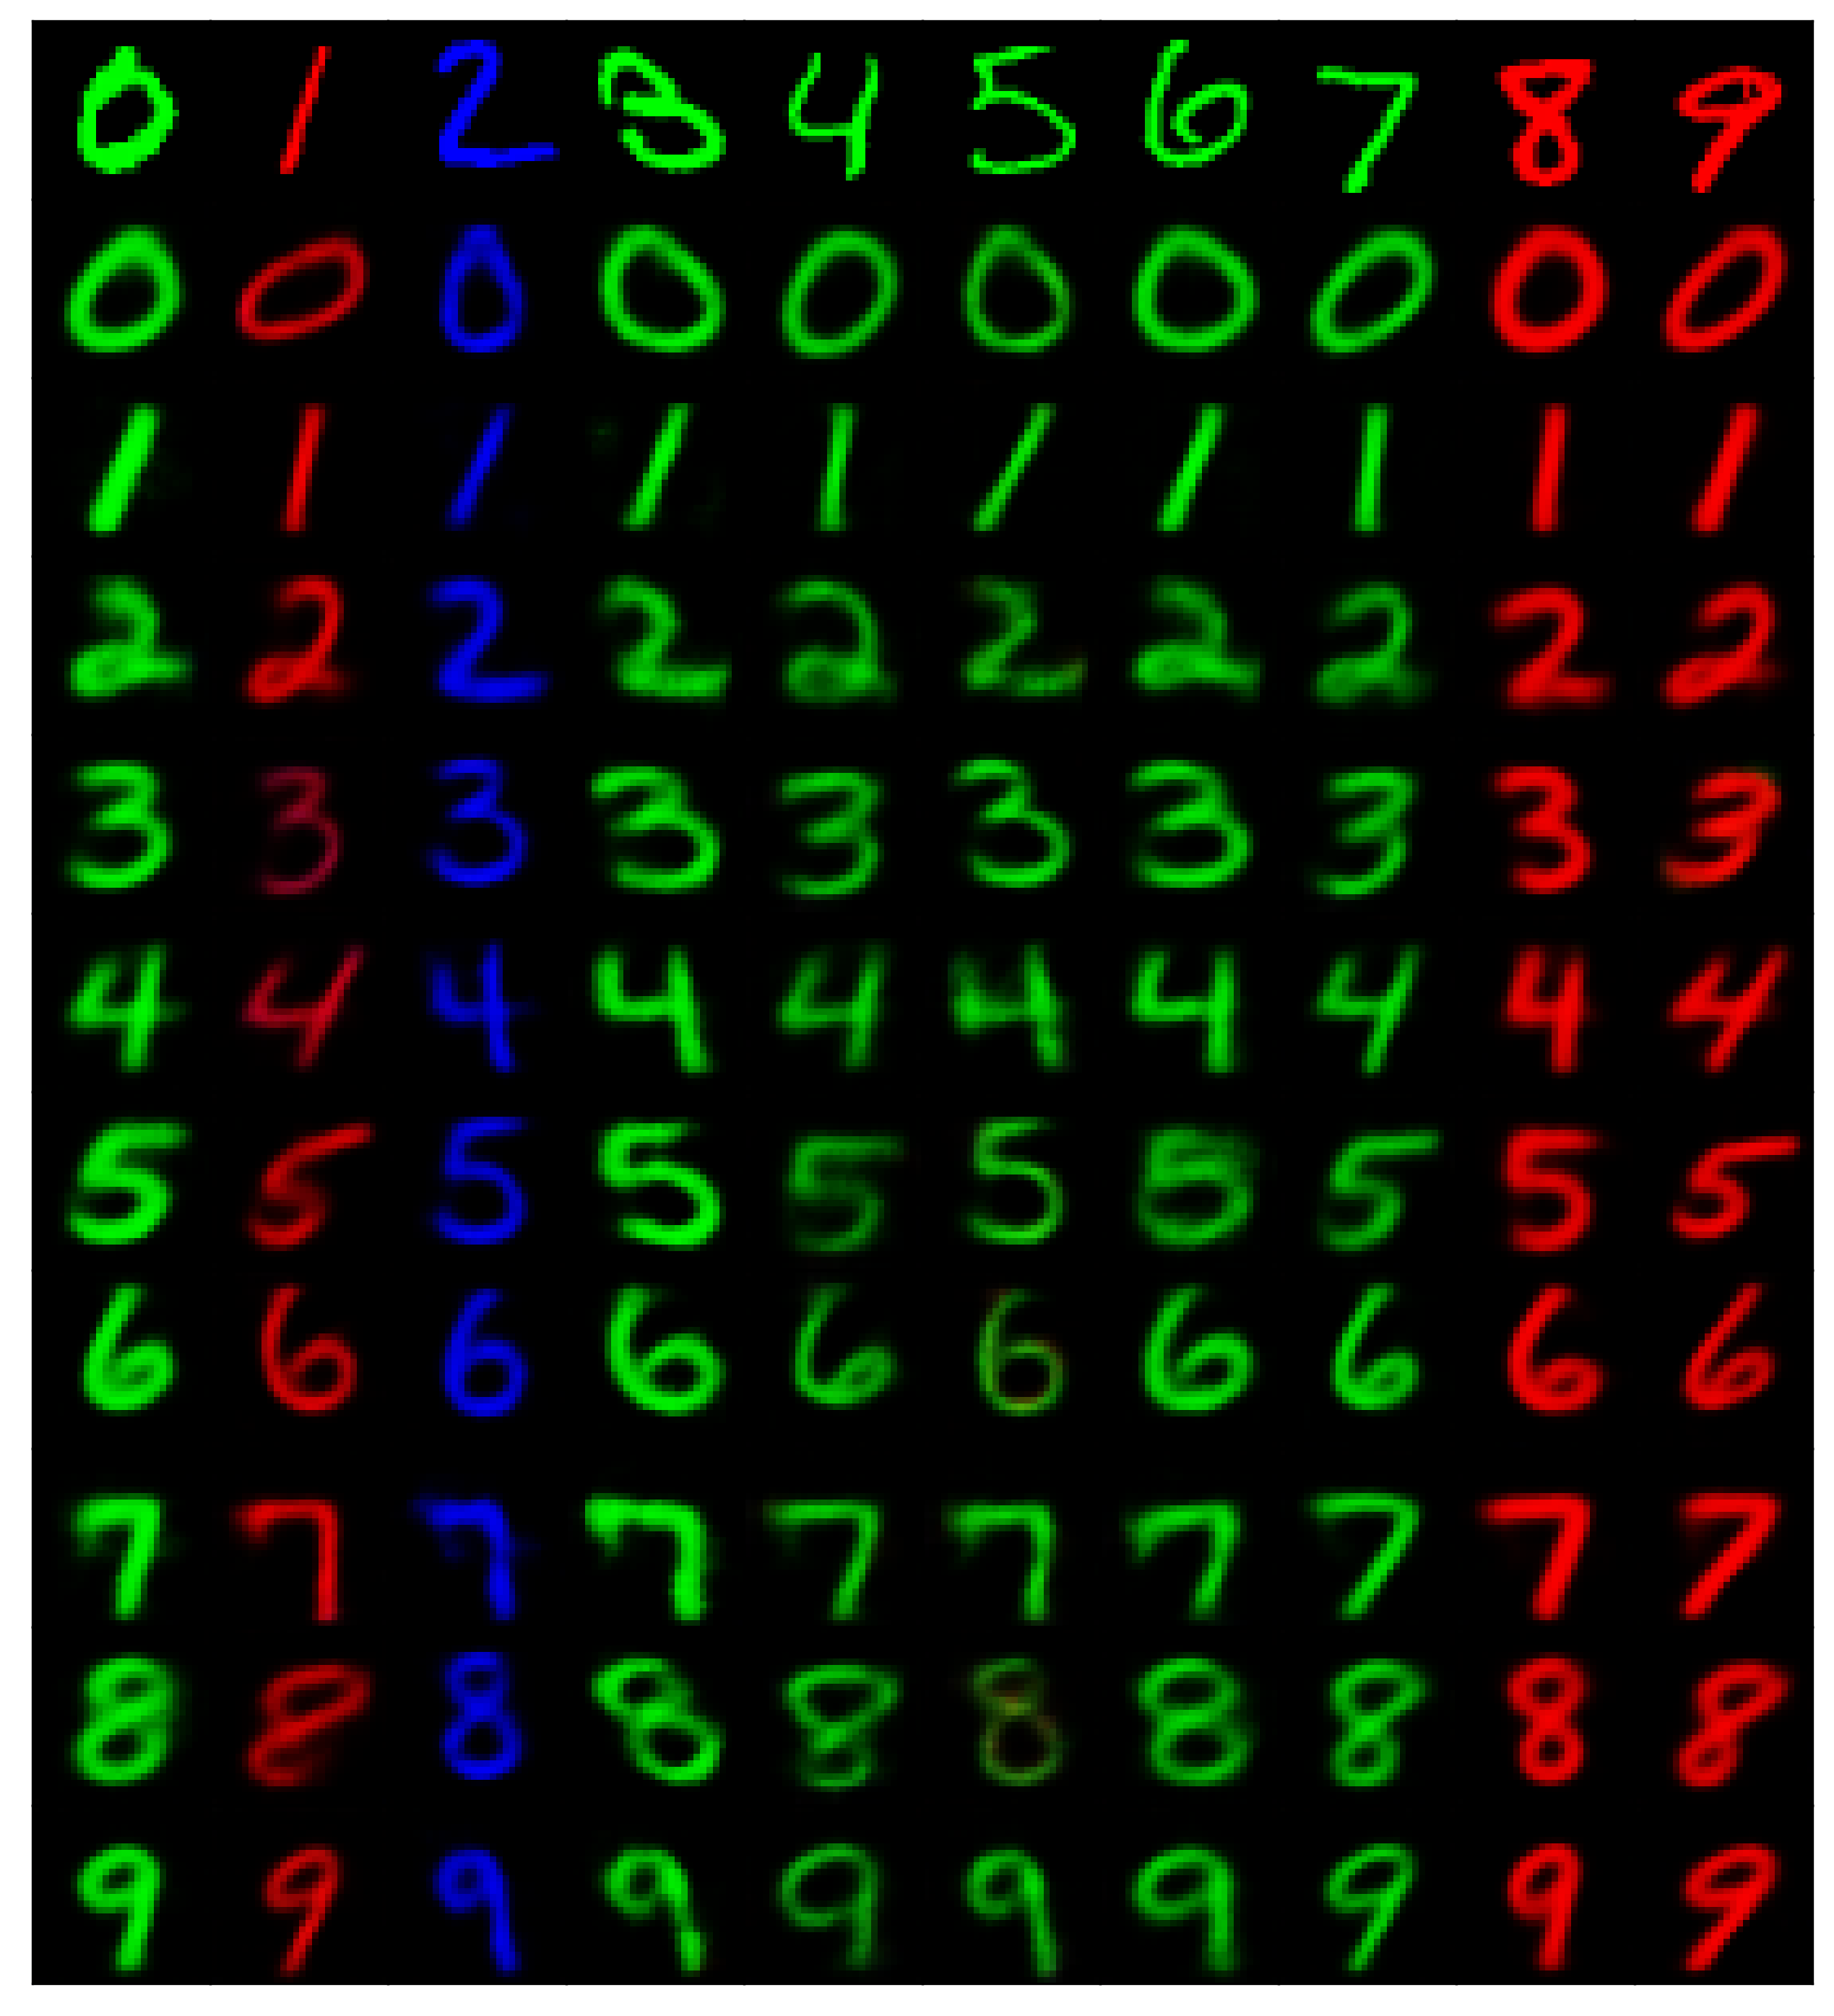

Evaluate performance for S states
Evaluate Mutual Information I(U,Z)


In [ ]:
from utils.mine import MINE
alpha_list = [0.005, 0.2, 0.7, 0.9]
beta_list = [0.0001, 0.1, 0.3, 0.5, 0.8, 0.95]
DIM_Z = [8, 64]

util_acc_tr = np.zeros((len(DIM_Z),len(alpha_list),len(beta_list)))
util_acc_ts = np.zeros((len(DIM_Z),len(alpha_list),len(beta_list)))

sens_mae_tr = np.zeros((DIM_S,len(DIM_Z),len(alpha_list),len(beta_list)))
sens_mae_ts = np.zeros((DIM_S,len(DIM_Z),len(alpha_list),len(beta_list)))
sens_acc_tr = np.zeros((DIM_S,len(DIM_Z),len(alpha_list),len(beta_list)))
sens_acc_ts = np.zeros((DIM_S,len(DIM_Z),len(alpha_list),len(beta_list)))

mi_u_ts = np.zeros((len(DIM_Z),len(alpha_list),len(beta_list)))
mi_u_tr = np.zeros((len(DIM_Z),len(alpha_list),len(beta_list)))
mi_s_ts = np.zeros((len(DIM_Z),len(alpha_list),len(beta_list)))
mi_s_tr = np.zeros((len(DIM_Z),len(alpha_list),len(beta_list)))


s_test_state = np.zeros((x_test.shape[0],DIM_S,DIM_S))
s_train_state = np.zeros((x_train.shape[0],DIM_S,DIM_S))
for i in range(DIM_S):
    s_test_state[:, i, i] = 1
    s_train_state[:, i, i] = 1

for i, dimz in enumerate(DIM_Z):
    for j, alpha in enumerate(alpha_list):
        for k, beta in enumerate(beta_list):
            #Pre training
            encoder, uncertainty_decoder, utility_decoder,autoencoder,z_discriminator,prior_generator,prior_gen_zdiscriminator,encoder_zdiscriminator,u_dircriminator,decoder_udiscriminator = get_full_model(dimz, alpha, beta)
            pre_train_ae(dimz, alpha, beta, force_train=False, max_itr=100, verbose=0)
            
            print("Full model training")
            main_train(dimz, max_itr=100, batch_size=1024, verbose=1)

            print("Evaluate performance U")
            z_test = encoder.predict(x_test)
            z_train = encoder.predict(x_train)
            
            u_test_hat = utility_decoder.predict(z_test)
            u_train_hat = utility_decoder.predict(z_train)
            
            u_test_hat = utility_decoder.predict(z_test)
            u_train_hat = utility_decoder.predict(z_train)
            
            if supervised:
                util_acc_ts[i][j][k] = np.mean(np.argmax(u_test_hat,axis=1)==np.argmax(u_test,axis=1)) * 100
                util_acc_tr[i][j][k] = np.mean(np.argmax(u_train_hat,axis=1)==np.argmax(u_train,axis=1)) * 100
            else:
                util_acc_ts[i][j][k] = np.mean(np.sum(np.square(u_test_hat-u_test), axis=(1,2,3)))
                util_acc_tr[i][j][k] = np.mean(np.sum(np.square(u_train_hat-u_train), axis=(1,2,3)))
            
            save_figures(autoencoder, dimz, alpha, beta)
            
            print("Evaluate performance for S states")
            
            for m in range(DIM_S):
                x_test_hat = uncertainty_decoder.predict([z_test, s_test_state[:,:,m]])
                s_test_hat = s_eval_model.predict(x_test_hat)
                sens_mae_ts[m][i][j][k] = np.mean(np.abs(s_test_hat - s_test_state[:,:,m]))
                sens_acc_ts[m][i][j][k] = np.mean(np.argmax(s_test_hat,axis=1)==m) * 100
                
                x_train_hat = uncertainty_decoder.predict([z_train, s_train_state[:,:,m]])
                s_train_hat = s_eval_model.predict(x_train_hat)
                sens_mae_tr[m][i][j][k] = np.mean(np.abs(s_train_hat - s_train_state[:,:,m]))
                sens_acc_tr[m][i][j][k] = np.mean(np.argmax(s_train_hat,axis=1)==m) * 100
            
            if supervised:
                print("Evaluate Mutual Information I(U,Z)")
                mine = MINE(x_dim=dimz, y_dim=DIM_U)
                _, mi_u_ts[i][j][k] = mine.fit(z_test, u_test, epochs=250, batch_size=1024, verbose=0)
                _, mi_u_tr[i][j][k] = mine.fit(z_train, u_train, epochs=250, batch_size=1024, verbose=0)
            
            print("Evaluate Mutual Information I(S,Z)")
            mine = MINE(x_dim=dimz, y_dim=DIM_S)
            _, mi_s_ts[i][j][k] = mine.fit(z_test, s_test, epochs=250, batch_size=1024, verbose=0)
            _, mi_s_tr[i][j][k] = mine.fit(z_train, s_train, epochs=250, batch_size=1024, verbose=0) 
            
print("Finished!")

In [ ]:
if supervised:
    print(np.mean(np.argmax(u_test_hat,axis=1)==np.argmax(u_test,axis=1)) * 100)
else:
    print(np.mean(np.sum(np.square(u_train_hat-u_train),axis=(1,2,3))))

# Plot results
## Plot accuracy U (or MSE in unsupervised mode) (for each z we save one fig for all betas on the Test data)

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300

linestyles = ['-', '--', '-.', ':']
for i in range(util_acc_ts.shape[0]):
    plt.figure(figsize=(15,8))
    if supervised:
        plt.title(r"Utility attribute's accuracy with $\beta$ $\in$ [0.0001, 0.1, 0.3, 0.5, 0.8, 0.95] " + f'{exp_info}_d={DIM_Z[i]}', fontsize=16)
    else:
        plt.title(r"Utility attribute's MSE with $\beta$ $\in$ [0.0001, 0.1, 0.3, 0.5, 0.8, 0.95] " + f'{exp_info}_d={DIM_Z[i]}', fontsize=16)
    for j in range(util_acc_ts.shape[1]):
        if supervised:
            plt.plot(util_acc_ts[i][j], label=r'Utility Att Acc., Test, $\alpha=$' + f"{alpha_list[j]}", linestyle=linestyles[0], linewidth=2)
#             plt.plot(util_acc_tr[i][j], label=r'Utility Att Acc., Train, $\alpha=$' + f"{alpha_list[j]}", linestyle=linestyles[1], linewidth=3)
        else:
            plt.plot(util_acc_ts[i][j], label=r'Utility Att MSE., Test, $\alpha=$' + f"{alpha_list[j]}", linestyle=linestyles[0], linewidth=2)
#             plt.plot(util_acc_ts[i][j], label=r'Utility Att MSE., Train, $\alpha=$' + f"{alpha_list[j]}", linestyle=linestyles[1], linewidth=3)


    plt.legend(prop={'size': 10})
    plt.grid()
    plt.xticks(list(range(len(beta_list))), beta_list, fontsize=18, rotation=90)
    plt.xlabel(r'$\beta$', fontsize=24)
    if supervised:
        plt.ylabel(r'Accuracy of the $\mathbf{U}$', fontsize=16)
        plt.savefig(f'./saved_figures/chart_colored_mnist_acc_d_{DIM_Z[i]}_{exp_info}.eps', format='eps', bbox_inches='tight')
        plt.savefig(f'./saved_figures/chart_colored_mnist_acc_d_{DIM_Z[i]}_{exp_info}.png', format='png', bbox_inches='tight')
    else:
        plt.ylabel(r'Mean Square Error (MSE) of the $\mathbf{U}$', fontsize=16)
        plt.savefig(f'./saved_figures/chart_colored_mnist_mse_u_d_{DIM_Z[i]}_{exp_info}.eps', format='eps', bbox_inches='tight')
        plt.savefig(f'./saved_figures/chart_colored_mnist_mse_u_d_{DIM_Z[i]}_{exp_info}.png', format='png', bbox_inches='tight')
    plt.show()

## Plot accuracy U (for each z and alpha we save and plot a figure on the Test and Train data)

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300

linestyles = ['-', '--', '-.', ':']
for i in range(util_acc_ts.shape[0]):
    plt.figure(figsize=(15,8))
    for j in range(util_acc_ts.shape[1]):
        if supervised:
            plt.title(r"Utility attribute's accuracy with $\beta$ $\in$ [0.0001, 0.1, 0.3, 0.5, 0.8, 0.95] " + f'{exp_info}_d={DIM_Z[i]}_alpha={alpha_list[j]}', fontsize=16)
            plt.plot(util_acc_ts[i][j], label=r'Utility Att Acc., Test', linestyle=linestyles[0], linewidth=2)
            plt.plot(util_acc_tr[i][j], label=r'Utility Att Acc., Train', linestyle=linestyles[1], linewidth=3)
        else:
            plt.title(r"Utility attribute's MSE with $\beta$ $\in$ [0.0001, 0.1, 0.3, 0.5, 0.8, 0.95] " + f'{exp_info}_d={DIM_Z[i]}_alpha={alpha_list[j]}', fontsize=16)
            plt.plot(util_acc_ts[i][j], label=r'Utility Att MSE., Test', linestyle=linestyles[0], linewidth=2)
            plt.plot(util_acc_tr[i][j], label=r'Utility Att MSE., Train', linestyle=linestyles[1], linewidth=3)


        plt.legend(prop={'size': 10})
        plt.grid()
        plt.xticks(list(range(len(beta_list))), beta_list, fontsize=18, rotation=90)

        plt.xlabel(r'$\beta$', fontsize=24)
        if supervised:
            plt.ylabel(r'Accuracy of the $\mathbf{U}$', fontsize=16)
            plt.savefig(f'./saved_figures/chart_colored_mnist_acc_d_{DIM_Z[i]}_alpha_{alpha_list[j]}_{exp_info}.eps', format='eps', bbox_inches='tight')
            plt.savefig(f'./saved_figures/chart_colored_mnist_acc_d_{DIM_Z[i]}_alpha_{alpha_list[j]}_{exp_info}.png', format='png', bbox_inches='tight')
        else:
            plt.ylabel(r'Mean Square Error (MSE) of the $\mathbf{U}$', fontsize=16)
            plt.savefig(f'./saved_figures/chart_colored_mnist_mse_u_d_{DIM_Z[i]}_alpha_{alpha_list[j]}_{exp_info}.eps', format='eps', bbox_inches='tight')
            plt.savefig(f'./saved_figures/chart_colored_mnist_mse_u_d_{DIM_Z[i]}_alpha_{alpha_list[j]}_{exp_info}.png', format='png', bbox_inches='tight')
        plt.show()

## Plot accuracy S

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300

linestyles = ['-', '--', '-.', ':']
for i in range(sens_acc_ts.shape[1]):
    plt.figure(figsize=(15,8))
    plt.title(r'Sensitive attribute accuracy with $\beta$ $\in$ [0.0001, 0.1, 0.3, 0.5, 0.8, 0.95] ' + f'{exp_info}_d={DIM_Z[i]}', fontsize=16)
    for j in range(sens_mae_ts.shape[2]):
        for k in range(DIM_S):
            plt.plot(sens_acc_ts[k][i][j], label=r'Sensitive Att Acc., Test, $\alpha=$' + f'{alpha_list[j]}, s = {k}', linestyle=linestyles[0], linewidth=2)
#             plt.plot(sens_acc_ts[k][i][j], label=r'Sensiitive Att Acc., Train, $\alpha=$' + f'{alpha_list[j]}, s = {k}', linestyle=linestyles[1], linewidth=3)


    plt.legend(prop={'size': 10})
    plt.grid()
    plt.xticks(list(range(len(beta_list))), beta_list, fontsize=18, rotation=90)
    plt.xlabel(r'$\beta$', fontsize=24)
    plt.ylabel(r'Accuracy on the $\mathbf{S}$', fontsize=16)
    plt.savefig(f'./saved_figures/chart_colored_mnist_acc_s_d_{DIM_Z[i]}_{exp_info}.eps', format='eps', bbox_inches='tight')
    plt.savefig(f'./saved_figures/chart_colored_mnist_acc_s_d_{DIM_Z[i]}_{exp_info}.png', format='png', bbox_inches='tight')
    plt.show()

## Plot Mean absolute error (MAE) on all sensitivity states

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300

linestyles = ['-', '--', '-.', ':']
for i in range(sens_mae_ts.shape[1]):
    plt.figure(figsize=(15,8))
    plt.title(r'Sensitive attribute MAE with $\beta$ $\in$ [0.0001, 0.1, 0.3, 0.5, 0.8, 0.95] ' + f'{exp_info}_d={DIM_Z[i]}', fontsize=16)
    for j in range(sens_mae_ts.shape[2]):
        for k in range(DIM_S):
            plt.plot(sens_mae_ts[k][i][j], label=r'Sensitive Att MAE., Test, $\alpha=$' + f'{alpha_list[j]}, s = {k}', linestyle=linestyles[0], linewidth=2)


    plt.legend(prop={'size': 10})
    plt.grid()
    plt.xticks(list(range(len(beta_list))), beta_list, fontsize=18, rotation=90)
    plt.xlabel(r'$\beta$', fontsize=24)
    plt.ylabel(r'Mean Absolute Error (MAE) of the $\mathbf{S}$', fontsize=16)
    plt.savefig(f'./saved_figures/chart_colored_mnist_mae_d_{DIM_Z[i]}_{exp_info}.eps', format='eps', bbox_inches='tight')
    plt.savefig(f'./saved_figures/chart_colored_mnist_mae_d_{DIM_Z[i]}_{exp_info}.png', format='png', bbox_inches='tight')
    plt.show()

## Plot mutual information between Z and S

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


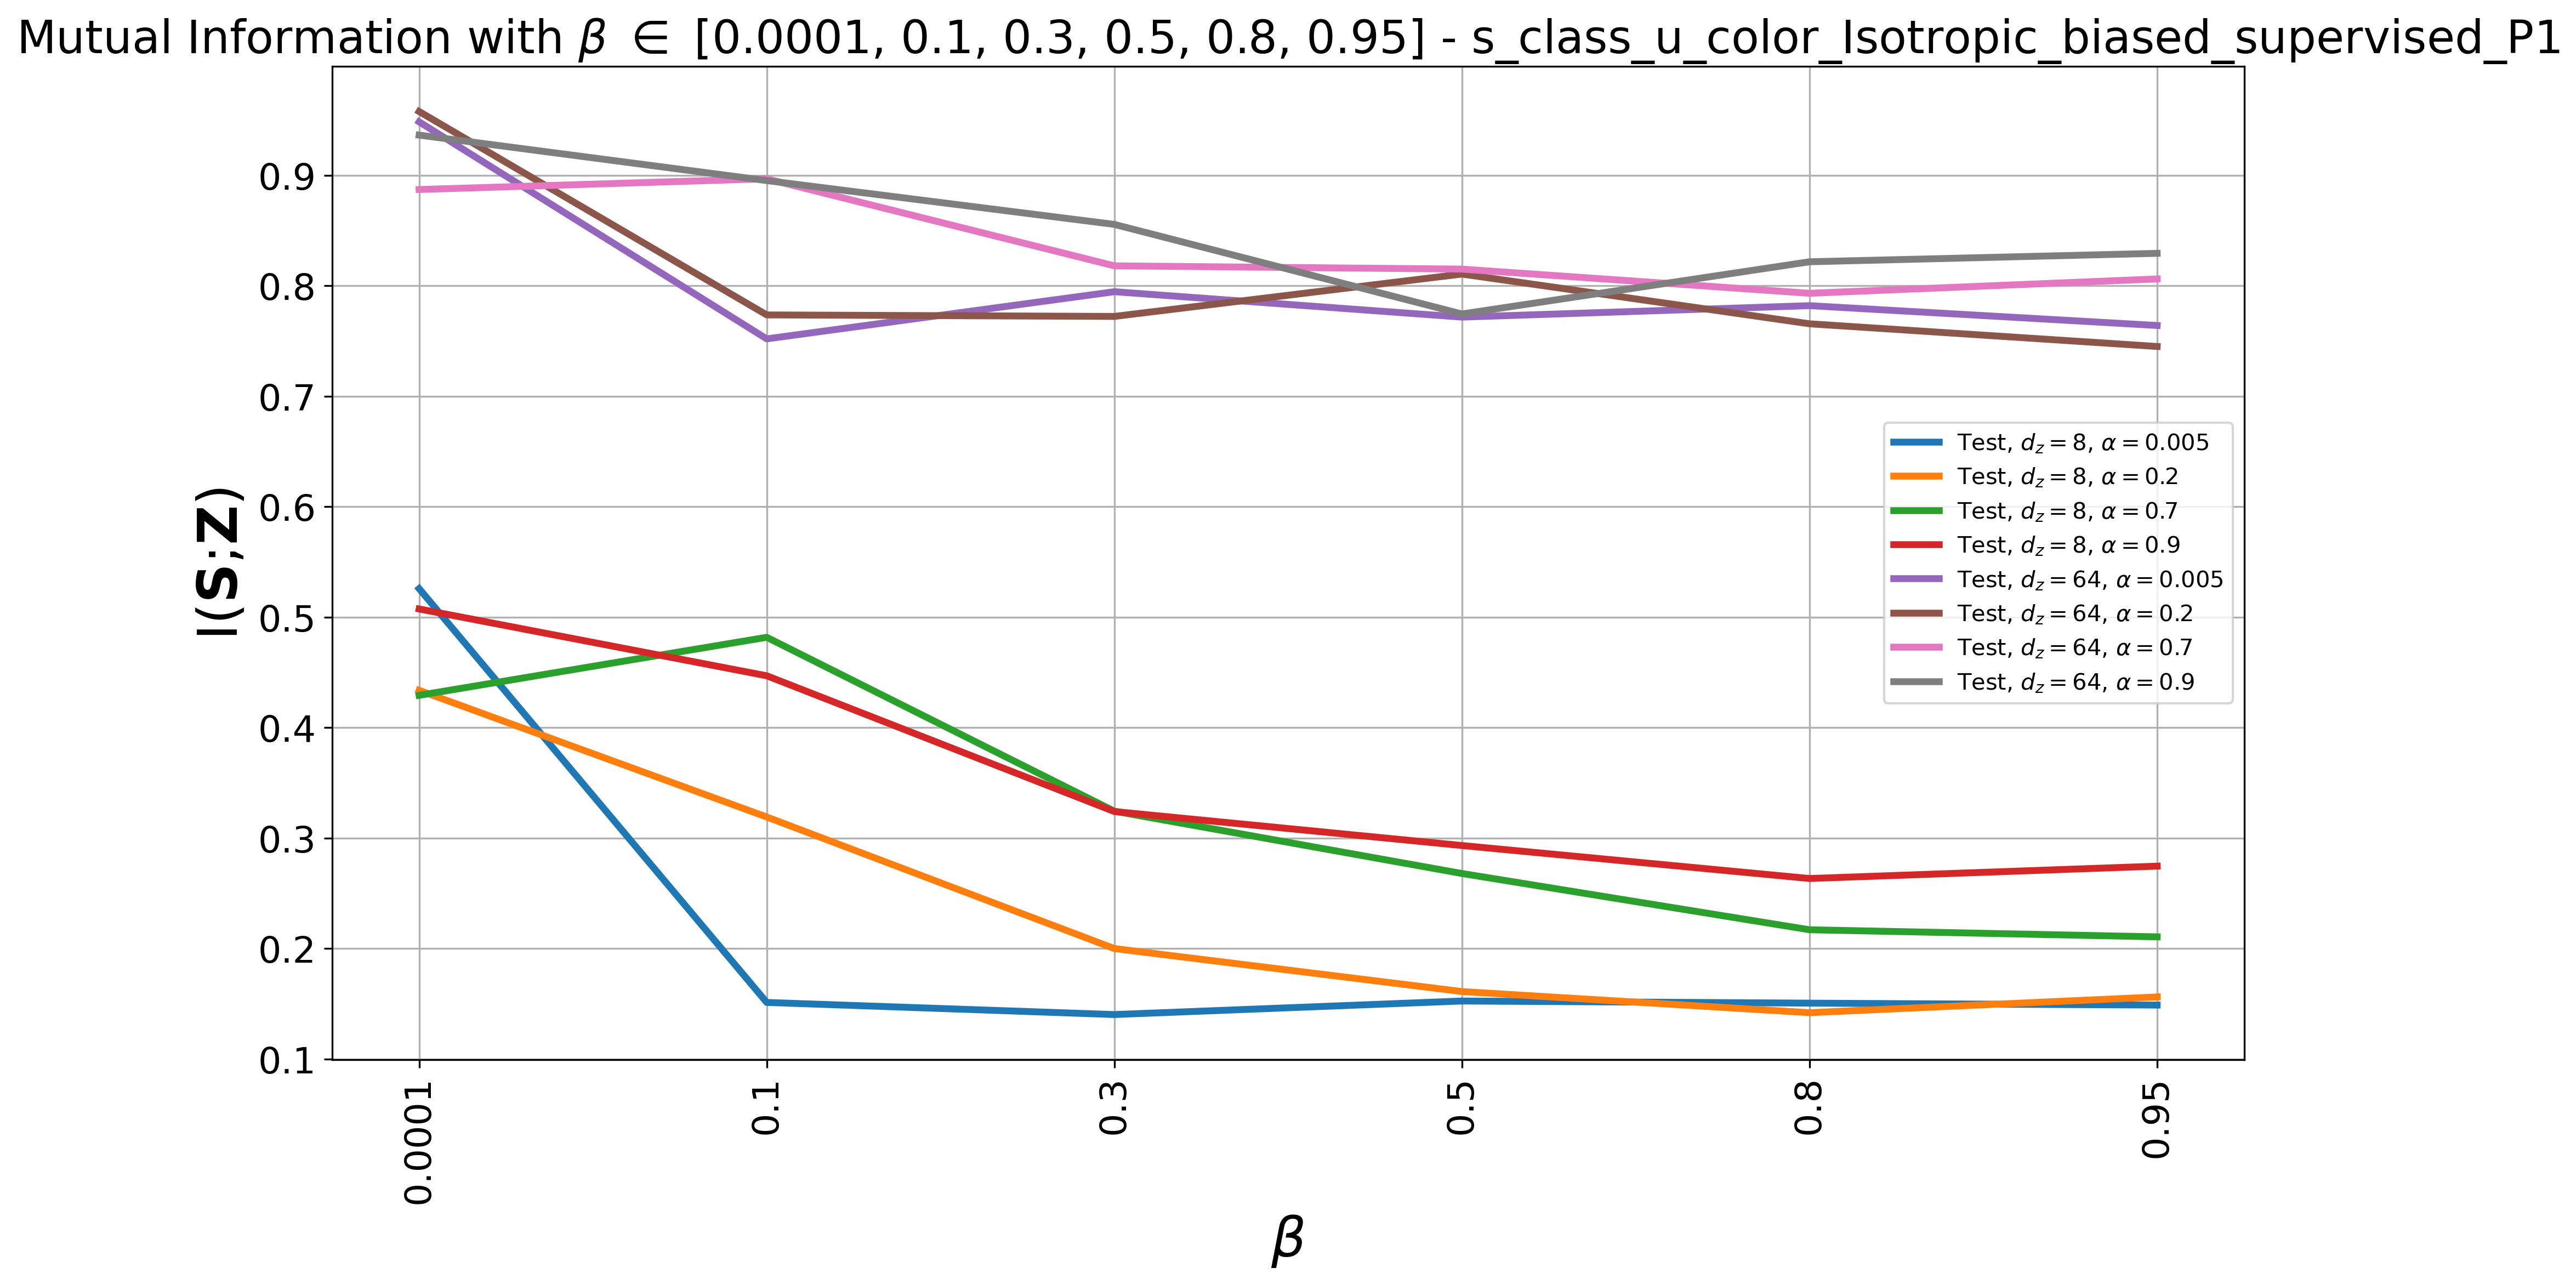

In [32]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(15,8))
plt.title(r'Mutual Information with $\beta$ $\in$ [0.0001, 0.1, 0.3, 0.5, 0.8, 0.95]' + f' - {exp_info}', fontsize=20)
linestyles = ['-', '--', '-.', ':']
colors = ['b', 'r', 'g', 'c']
for i in range(mi_s_ts.shape[0]):
    for j in range(mi_s_ts.shape[1]):
        plt.plot(mi_s_ts[i][j], label=r'Test, $d_z=$' + f'{DIM_Z[i]}' + r', $\alpha=$' + f"{alpha_list[j]}", linestyle=linestyles[0] ,linewidth=3)
#         plt.plot(mi_s_tr[i][j], label=r'Train, $d_z=$' + f'{DIM_Z[i]}' + r', $\alpha=$' + f"{alpha_list[j]}", linestyle=linestyles[1], c=colors[j%len(colors)] ,linewidth=3)
        
# plt.xscale('linear')
plt.xlabel(r'$\beta$', fontsize=24)
plt.xticks(list(range(len(beta_list))), beta_list, rotation=90)

plt.ylabel(r'I($\mathbf{S}$;$\mathbf{Z}$)', fontsize=24)
plt.legend(prop={'size': 10})
plt.grid()
plt.savefig(f'./saved_figures/chart_colored_mnist_mi_zs_{exp_info}.eps', format='eps', bbox_inches='tight')
plt.savefig(f'./saved_figures/chart_colored_mnist_mi_zs_{exp_info}.png', format='png', bbox_inches='tight')
plt.show()

## Plot mutual information between Z and U

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


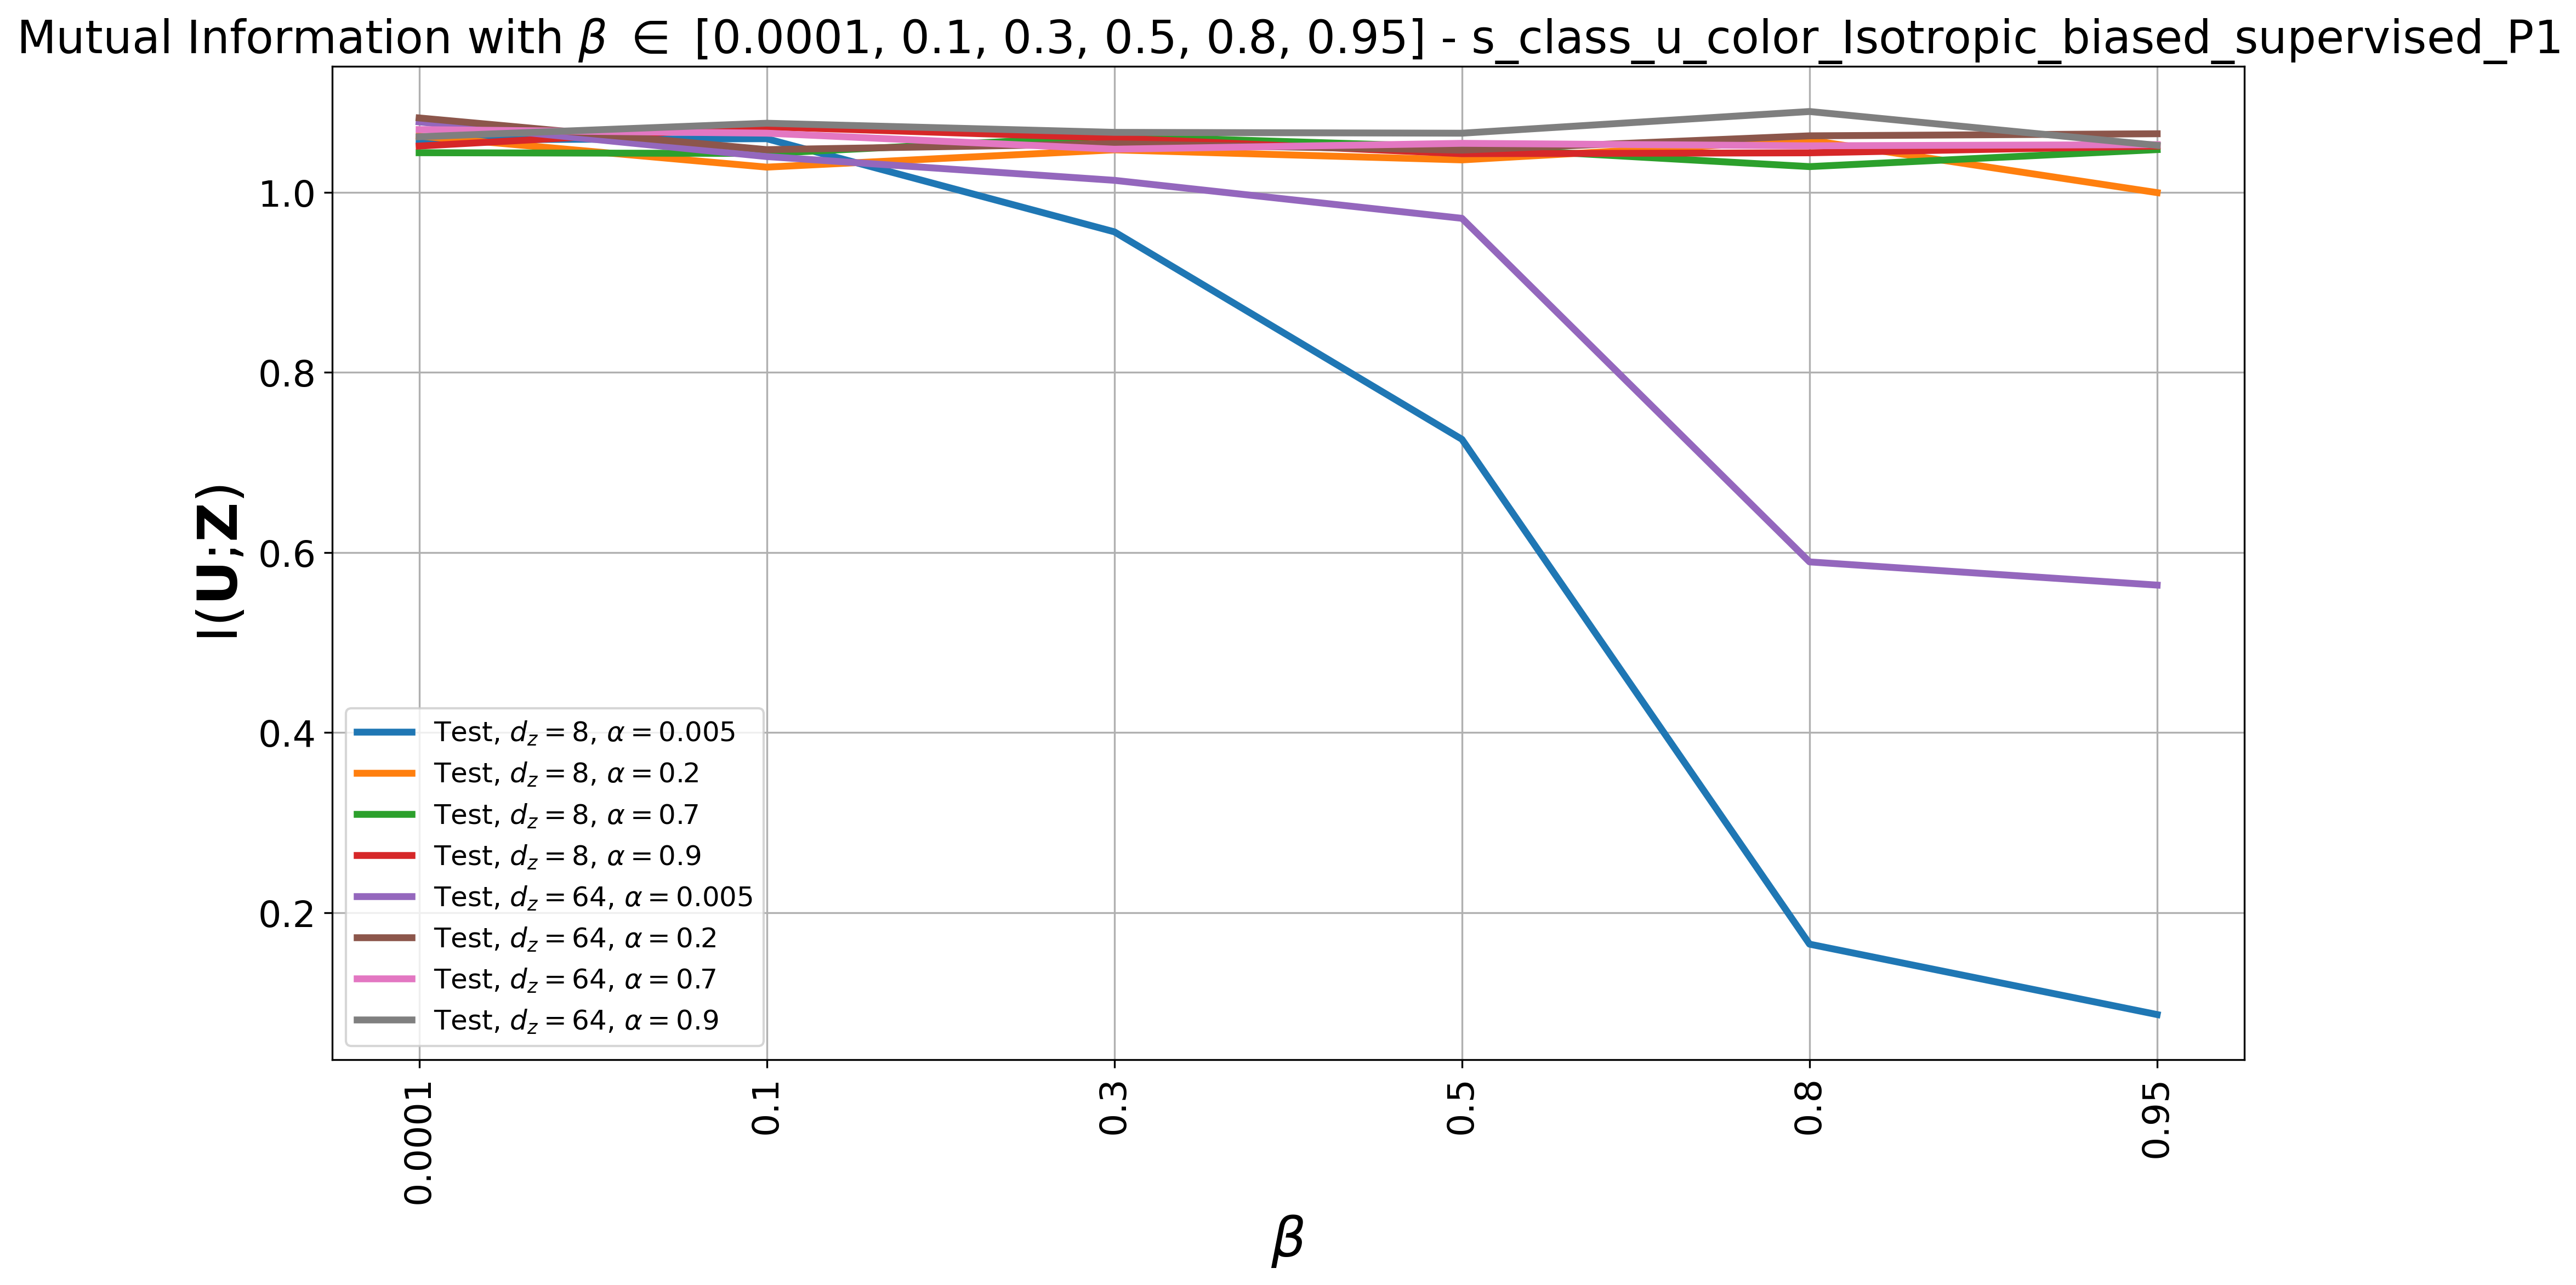

In [33]:
if supervised:
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['figure.dpi'] = 300
    plt.figure(figsize=(15,8))
    plt.title(r'Mutual Information with $\beta$ $\in$ [0.0001, 0.1, 0.3, 0.5, 0.8, 0.95]' + f' - {exp_info}', fontsize=20)
    linestyles = ['-', '--', '-.', ':']
    colors = ['b', 'r', 'g', 'c']
    for i in range(mi_u_ts.shape[0]):
        for j in range(mi_u_ts.shape[1]):
            plt.plot(mi_u_ts[i][j], label=r'Test, $d_z=$' + f'{DIM_Z[i]}' + r', $\alpha=$' + f"{alpha_list[j]}", linestyle=linestyles[0] ,linewidth=3)
    #         plt.plot(mi_u_tr[i][j], label=r'Train, $d_z=$' + f'{DIM_Z[i]}' + r', $\alpha=$' + f"{alpha_list[j]}", linestyle=linestyles[1], c=colors[j%len(colors)] ,linewidth=3)

    # plt.xscale('linear')
    plt.xlabel(r'$\beta$', fontsize=24)
    plt.xticks(list(range(len(beta_list))), beta_list, rotation=90)

    plt.ylabel(r'I($\mathbf{U}$;$\mathbf{Z}$)', fontsize=24)
    plt.legend(prop={'size': 12})
    plt.grid()
    plt.savefig(f'./saved_figures/chart_colored_mnist_mi_zu_{exp_info}.eps', format='eps', bbox_inches='tight')
    plt.savefig(f'./saved_figures/chart_colored_mnist_mi_zu_{exp_info}.png', format='png', bbox_inches='tight')
    plt.show()

In [ ]:
_, u_test_hat = autoencoder.predict([x_test, s_test])
if supervised:
    print("Acc = ",np.mean(np.argmax(u_test_hat,axis=1)==np.argmax(u_test,axis=1)) * 100)
else:
    print("MSE = ", np.mean(np.sum(np.square(u_train_hat-u_train), axis=(1,2,3))))

# Save results values to file

In [ ]:
import scipy.io as sio
sio.savemat(f'./saved_data/acc_colored_mnist_{exp_info}.mat', {'util_acc_ts':util_acc_ts, 'util_acc_tr':util_acc_tr, 'sens_acc_ts':sens_acc_ts, 'sens_acc_tr':sens_acc_tr, 'sens_mae_ts':sens_mae_ts, 'sens_mae_tr':sens_mae_tr})
sio.savemat(f'./saved_data/mi_colored_mnist_{exp_info}.mat', {'mi_s_ts':mi_s_ts, 'mi_s_tr':mi_s_tr, 'mi_u_ts':mi_u_ts, 'mi_u_tr':mi_u_tr})

# Load results from file

In [ ]:
import scipy.io as sio
mat_contents  = sio.loadmat(f'./saved_data/acc_colored_mnist_{exp_info}.mat')
util_acc_ts = mat_contents['util_acc_ts']
util_acc_tr = mat_contents['util_acc_tr']
sens_acc_ts = mat_contents['sens_acc_ts']
sens_acc_tr = mat_contents['sens_acc_tr']
sens_mae_ts = mat_contents['sens_mae_ts']
sens_mae_tr = mat_contents['sens_mae_tr']


mat_contents  = sio.loadmat(f'./saved_data/mi_colored_mnist_{exp_info}.mat')
mi_s_tr = mat_contents['mi_s_tr']
mi_s_ts = mat_contents['mi_s_ts']
mi_u_ts = mat_contents['mi_u_ts']
mi_u_tr = mat_contents['mi_u_tr']